In [1]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(modelr))
library(stringr)

In [2]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [3]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

# Assumptions of the regression model

For the model in Section 7.1 predicting presidental vote share from the economy, discuss each of the assumptions in the numbered list in Section 11.1.
For each assumption, state where it is made (implicitly of explicitly) in the model, whether it seems reasonable, and how you might address violations of the assumptions.

In [4]:
filename <- "./data/ElectionsEconomy/hibbs.dat"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat')
hibbs <- read.table("./data/ElectionsEconomy/hibbs.dat", header=TRUE)

In [5]:
hibbs_model <- stan_glm(vote ~ growth, data=hibbs, refresh=0)

The underlying data comes from [Douglas A. Hibbs "Bread and Peace" model](https://douglas-hibbs.com/background-information-on-bread-and-peace-voting-in-us-presidential-elections/).

Even just focusing on growth there's a hidden parameter here: the growth is a geometrically *weighted* average of annualized quarterly real income (i.e. CPI adjusted) growth rates.
The weight parameter is determined from the data.

## Validity

The underlying model is relating the share of the US incumbents two-party preferred vote to real income growth; putting forward the hypothesis that if people are earning more money on average they are more likely to vote in the incumbent.
For this question the data is valid.

The underlying target variable is US election results, which is somewhat a representative of future elections.
The two party preferred vote is a very valid and reliable measure.

The variable of weighted average of annualized quarterly real income growth rate is reasonably valid.
Income growth rate is measured (somehow) by the Beurau of Labor Statistics.
Real growth is a little slippery; CPI changes its definition over time and doesn't exactly measure growth, but is a good proxy.
The weight could be thought of as a parameter in the model; it is valid if it would be stable over time.

## Representativeness

By construction the (weighted average of) annualized quarterly real income growth rate is representative of the overall US Population.

Not everyone in the US Population votes (or is eligible) to vote in an election. [Voter turnout](https://en.wikipedia.org/wiki/Voter_turnout_in_United_States_presidential_elections) tends to be in the range 50-60% of the population. Voter turnout is [correlated with income](https://en.wikipedia.org/wiki/Voter_turnout_in_United_States_presidential_elections#Income) but since we're talking about growth rates I don't think it should be a large problem.
The data is reasonable representative.

## Additivity and linearity

Looking at the data linearity seems like a reasonable approximation over the range of values in the data.

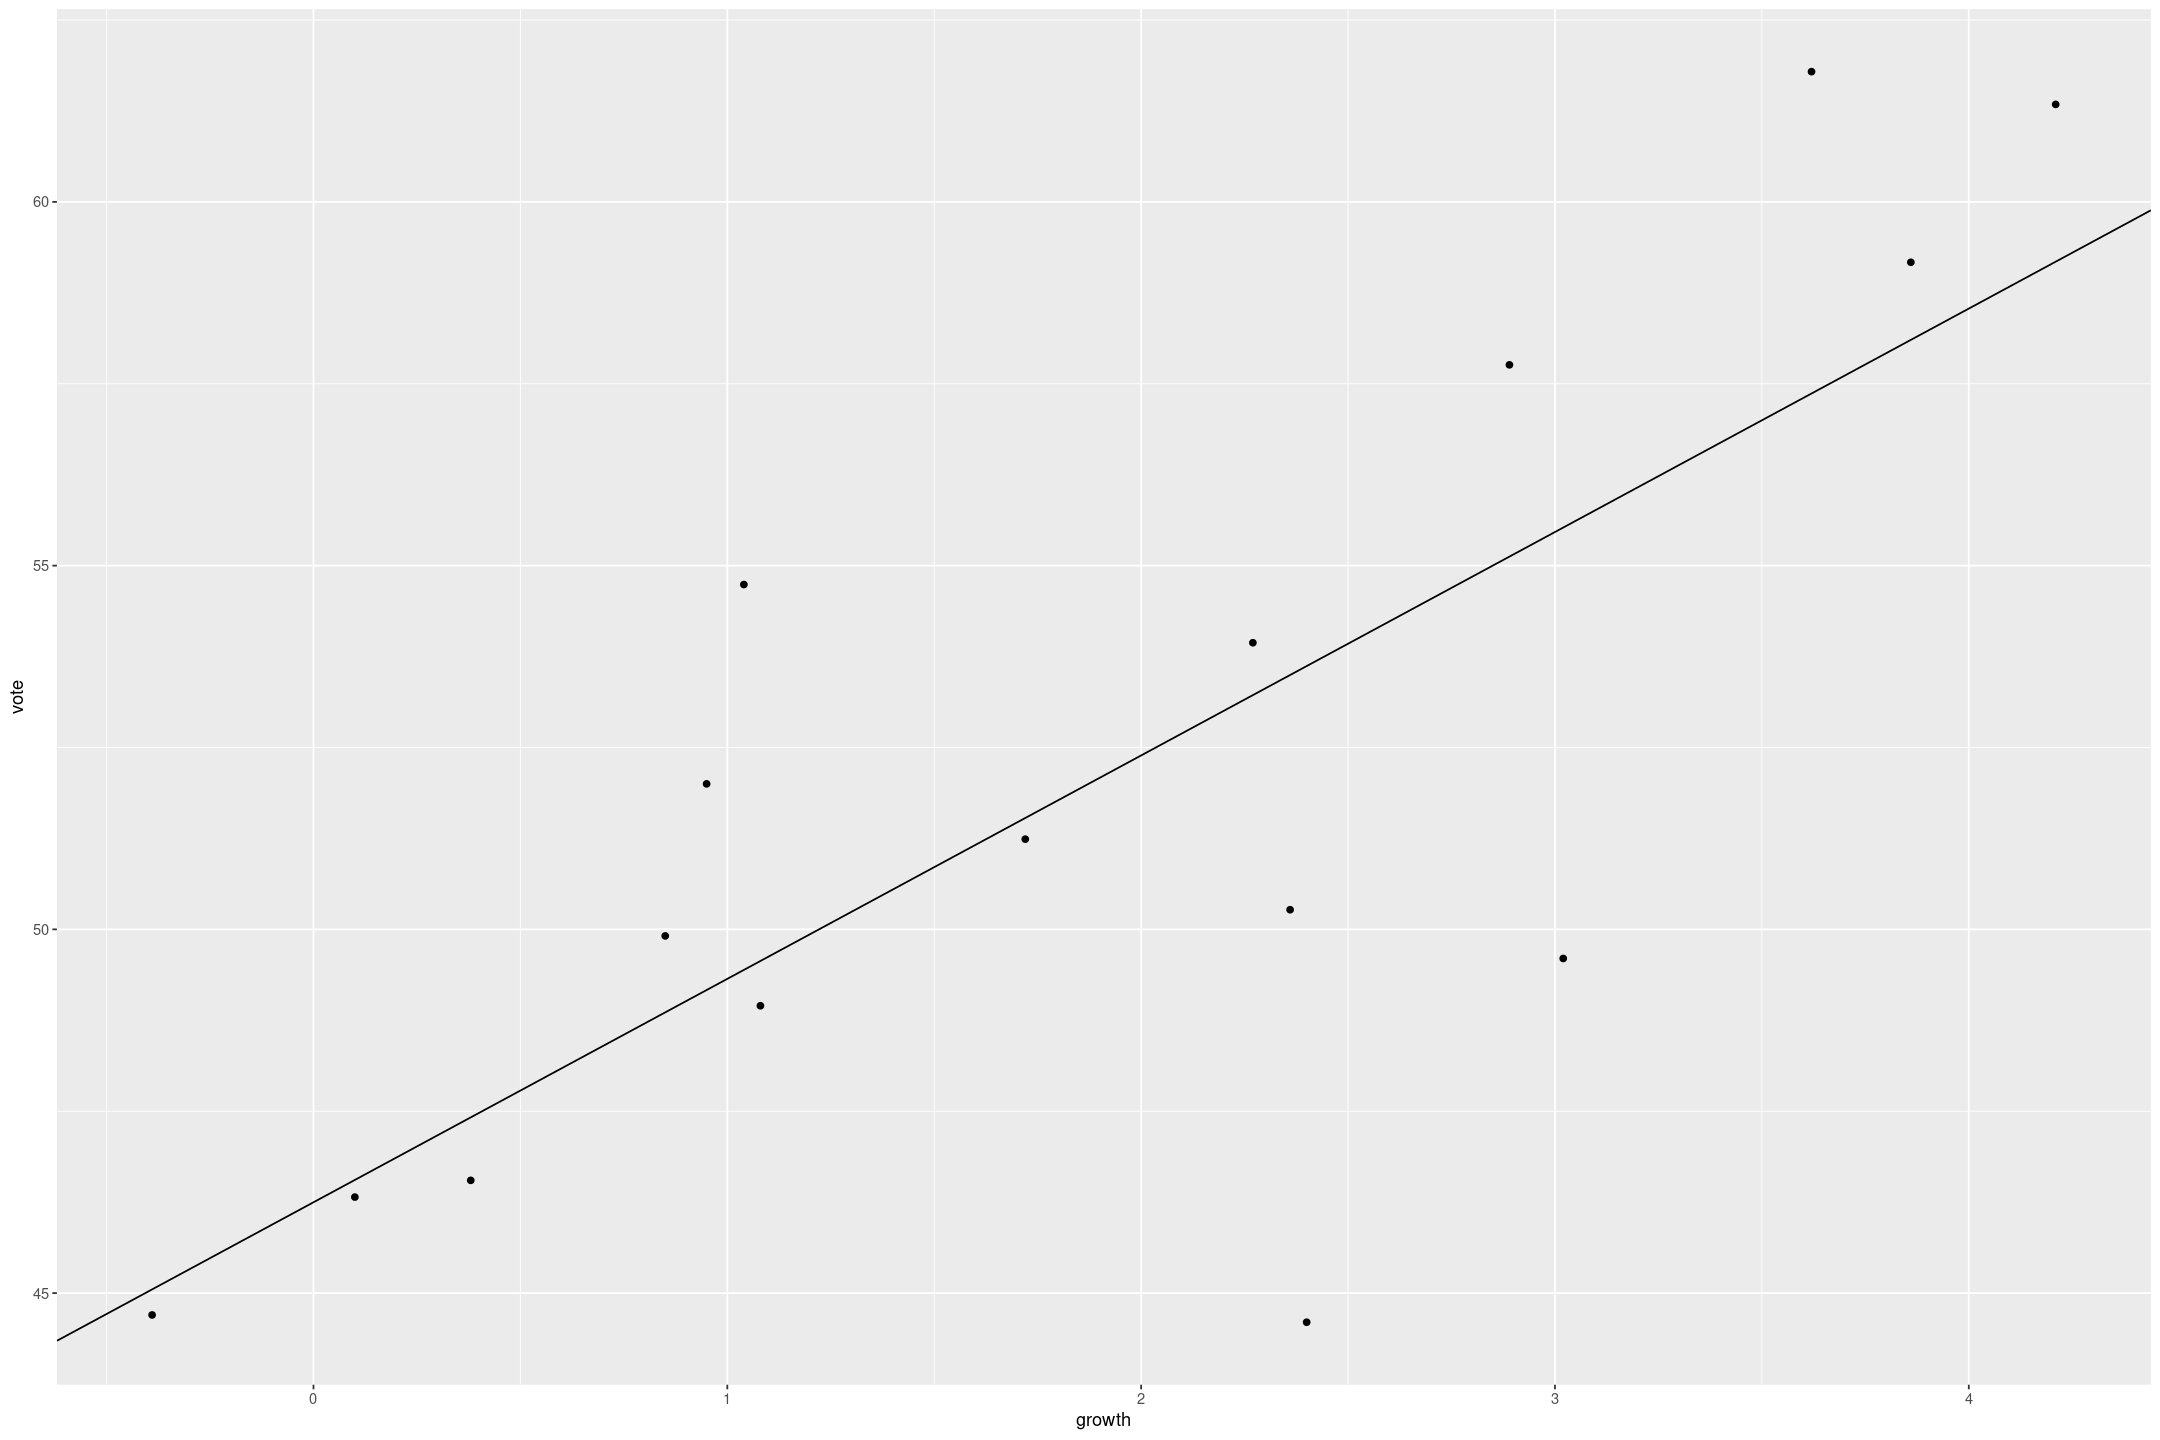

In [6]:
hibbs %>% 
gf_point(vote ~ growth) %>%
gf_abline(intercept=~coef(hibbs_model)['(Intercept)'], slope=~coef(hibbs_model)['growth'])

## Independence of errors

In this case the residual plot will look the same when using the predictions or the growth due to linearity (compare with section 11.3).

In this case it does look like the errors are independent.

In [7]:
hibbs <- hibbs %>% 
add_predictions(hibbs_model) %>% 
add_residuals(hibbs_model)

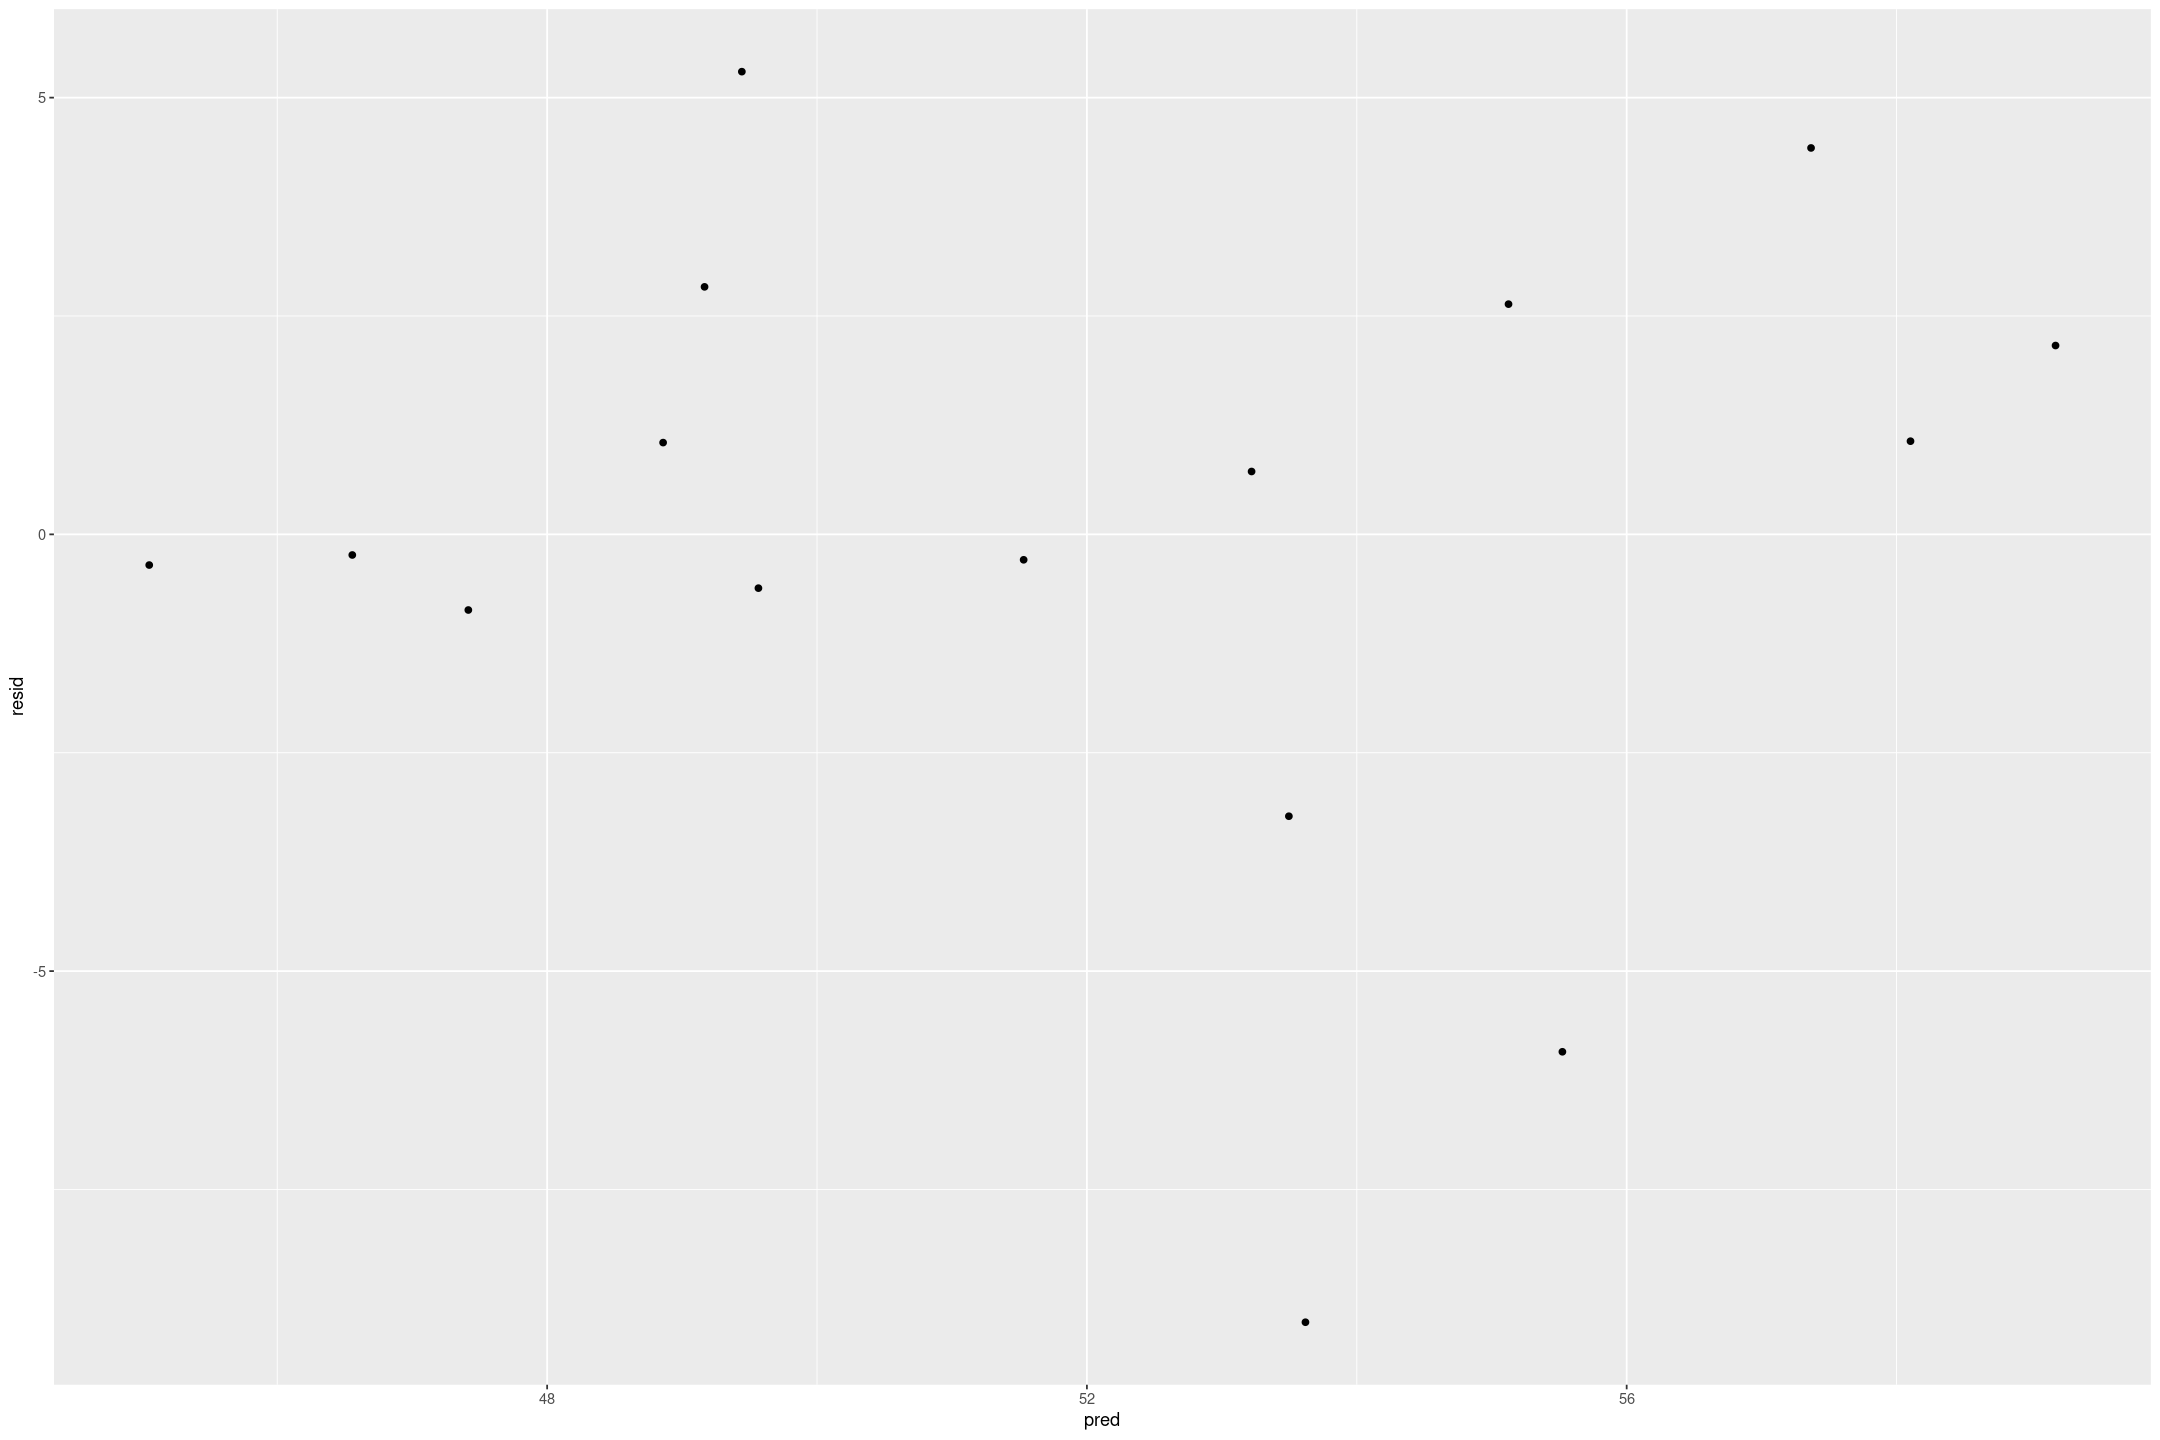

In [8]:
hibbs %>% gf_point(resid ~ pred)

Fitting a linear model the coefficient is zero and highly uncertain - there doesn't seem to be a pattern.

In [9]:
stan_glm(resid ~ pred, data=hibbs, refresh=0)

stan_glm
 family:       gaussian [identity]
 formula:      resid ~ pred
 observations: 16
 predictors:   2
------
            Median MAD_SD
(Intercept)  0.3   11.6  
pred         0.0    0.2  

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.8    0.7   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

Fitting some random normal data, it's hard to distinguish.

In [10]:
resid_sd <- sd(hibbs$resid)

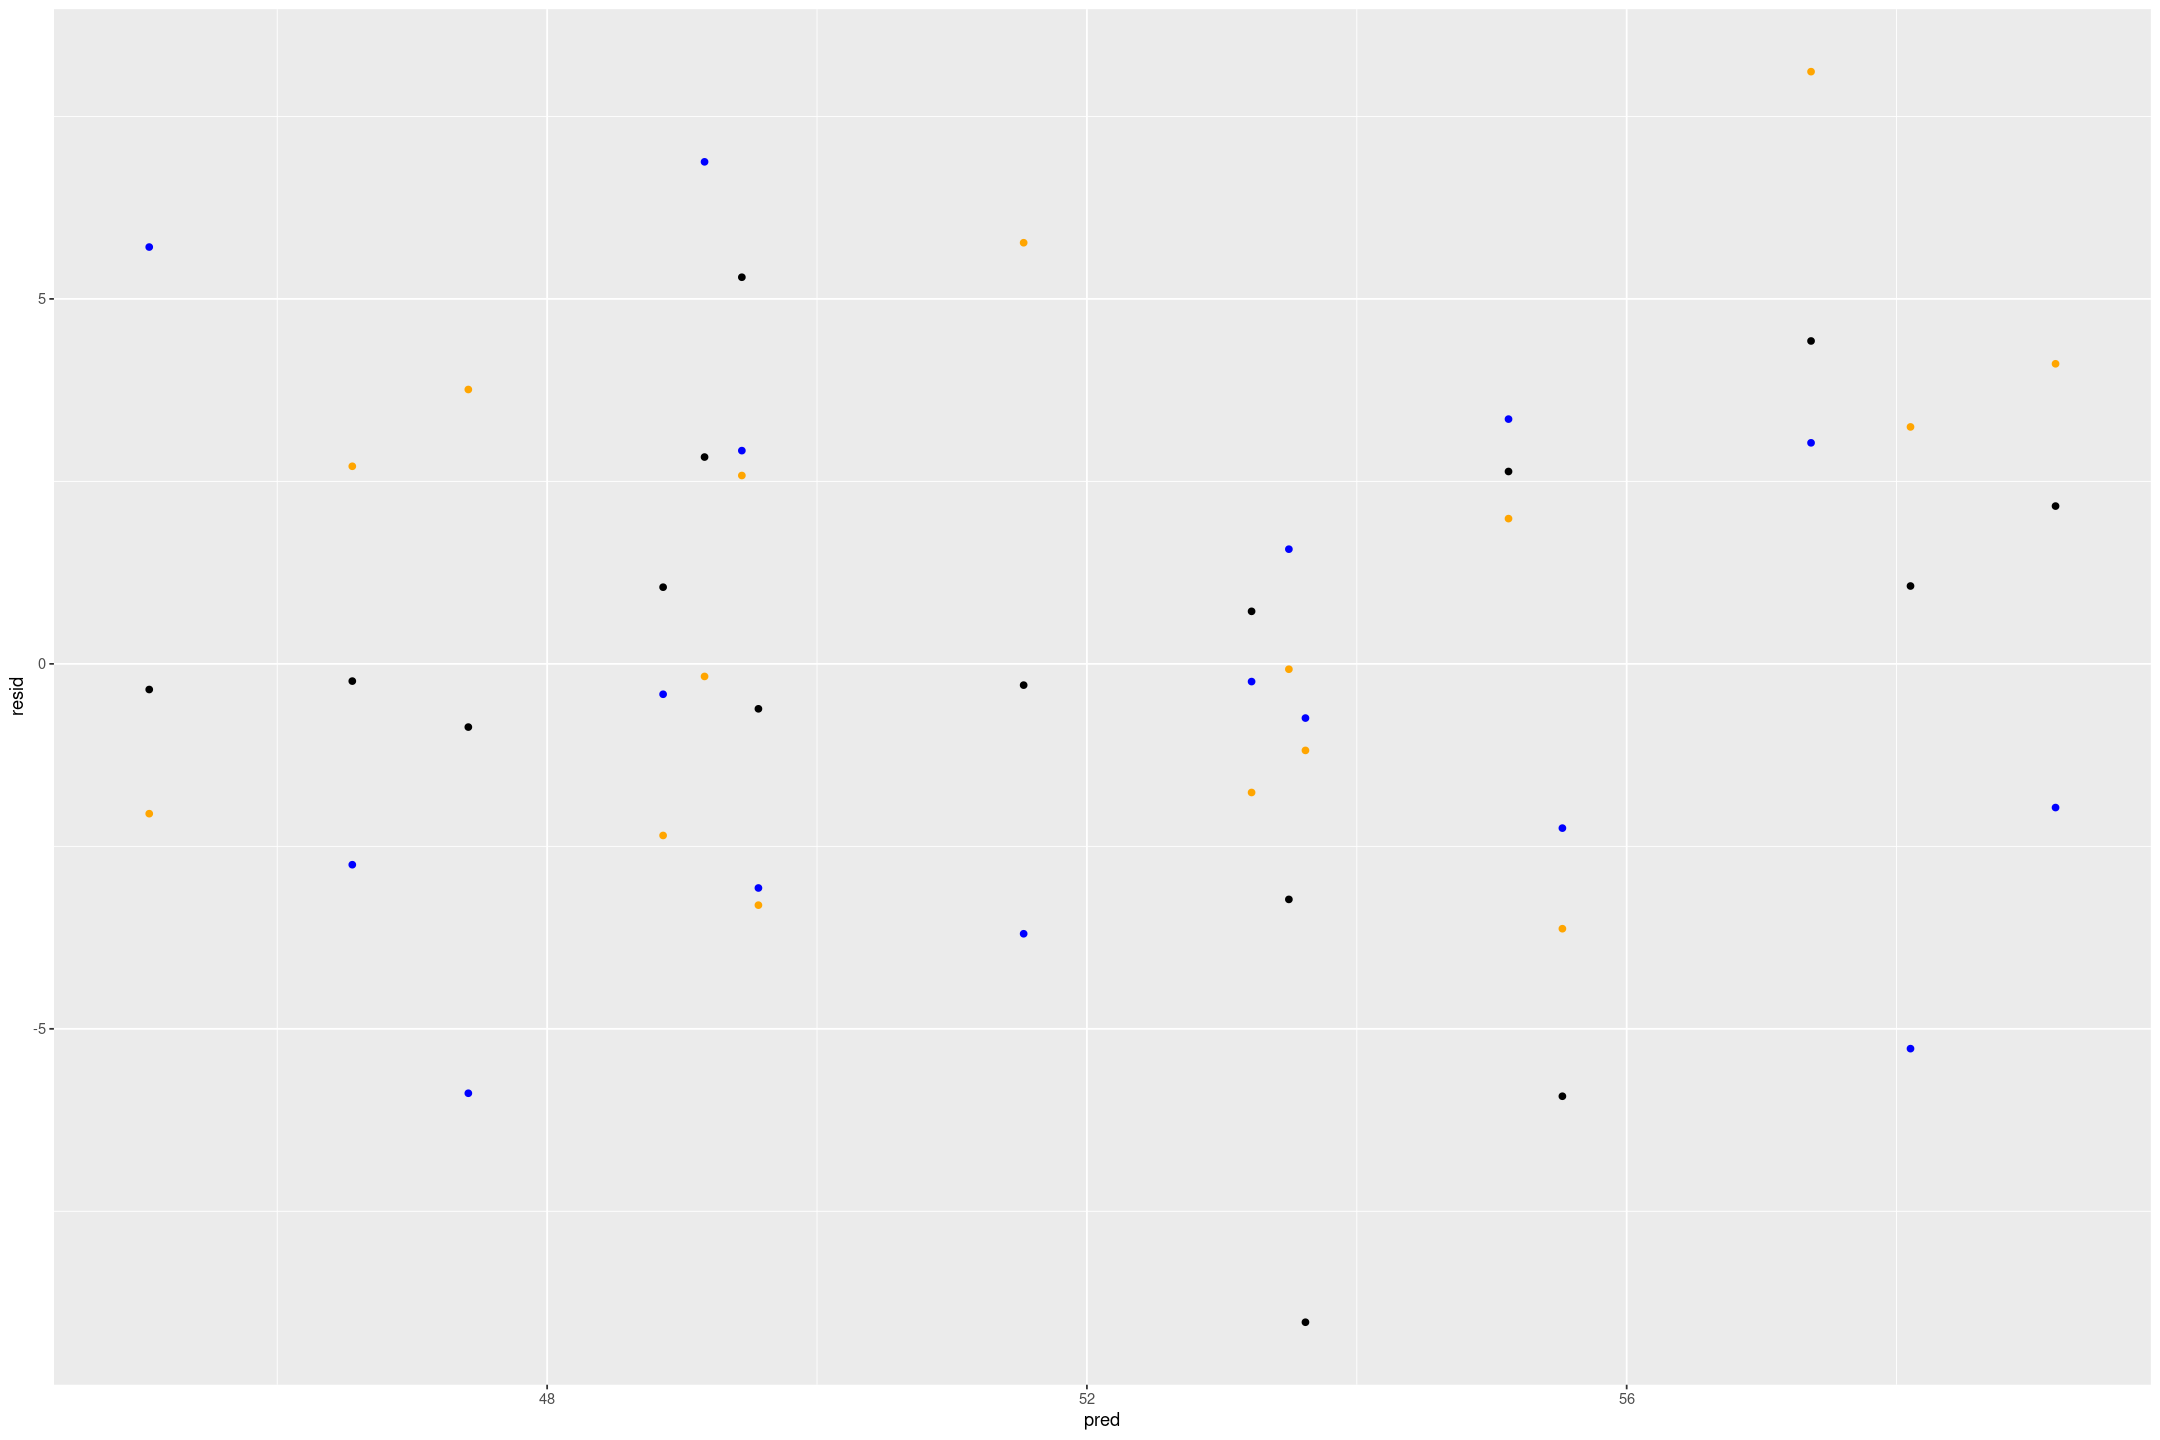

In [11]:
hibbs %>% 
gf_point(resid ~ pred) %>%
gf_point(resid_sd*rnorm(nrow(hibbs)) ~ pred, col='blue') %>%
gf_point(resid_sd*rnorm(nrow(hibbs)) ~ pred, col='orange') 

## Equal variance of errors

The first few predictions look like they have lower variance, but it's hard to tell.

There may be a little bit of increased variance with increased growth/predictions, but it's hard to tell.

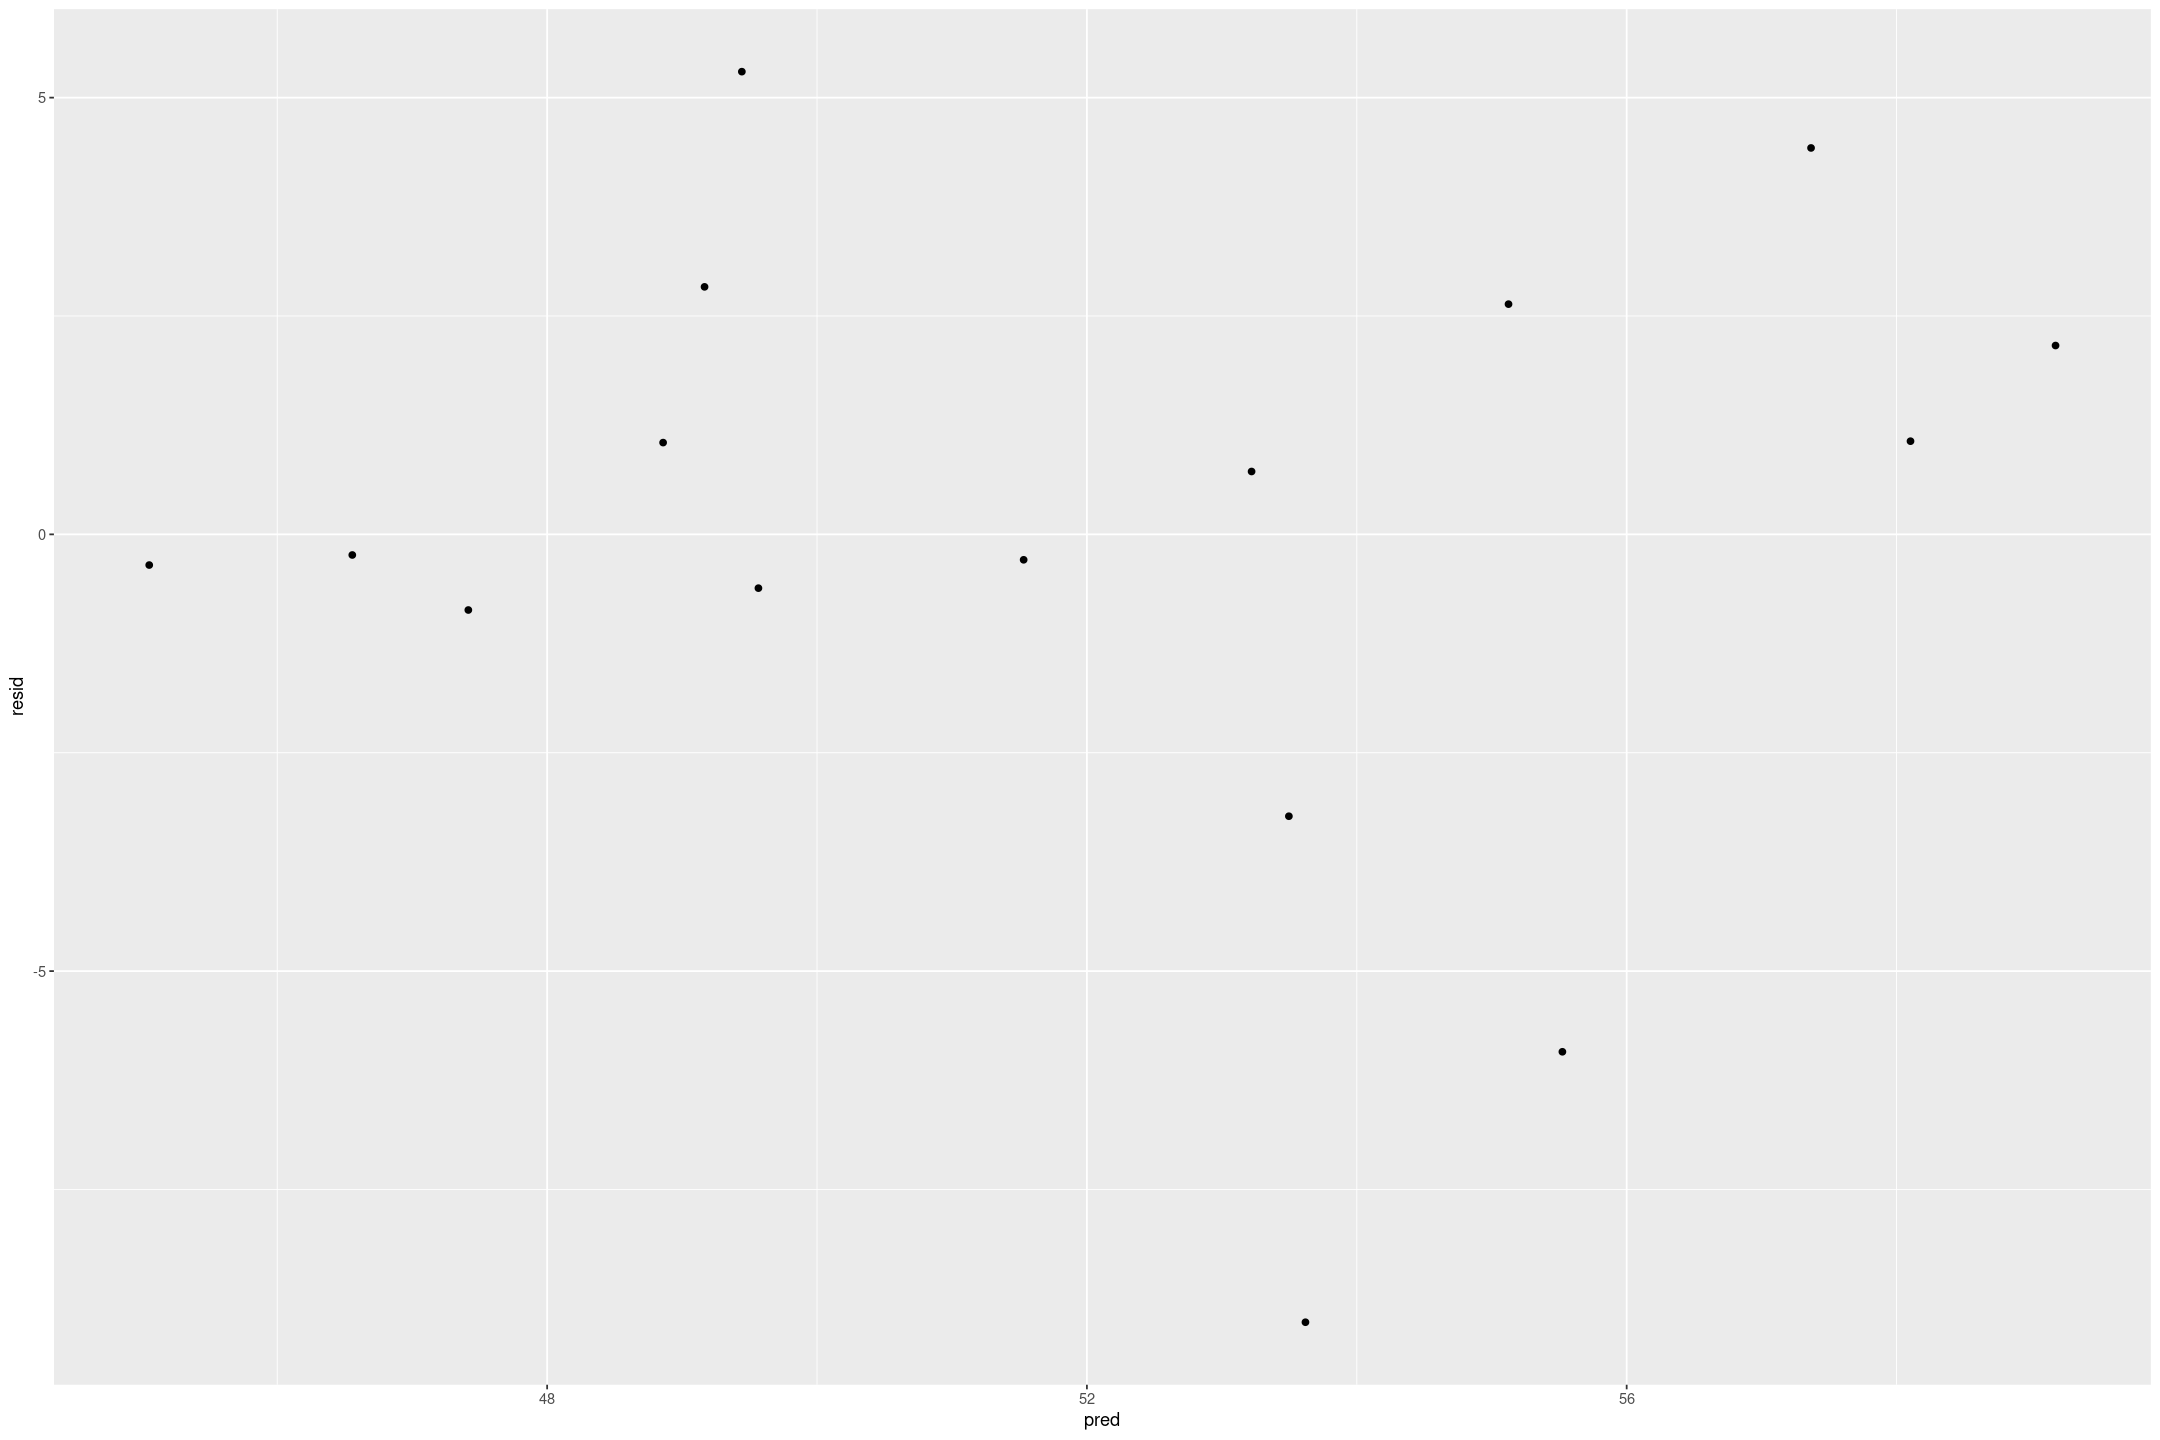

In [12]:
hibbs %>% gf_point(resid ~ pred)

## Normality of errors

It really is hard to say with 15 data points if the distribution is normal.

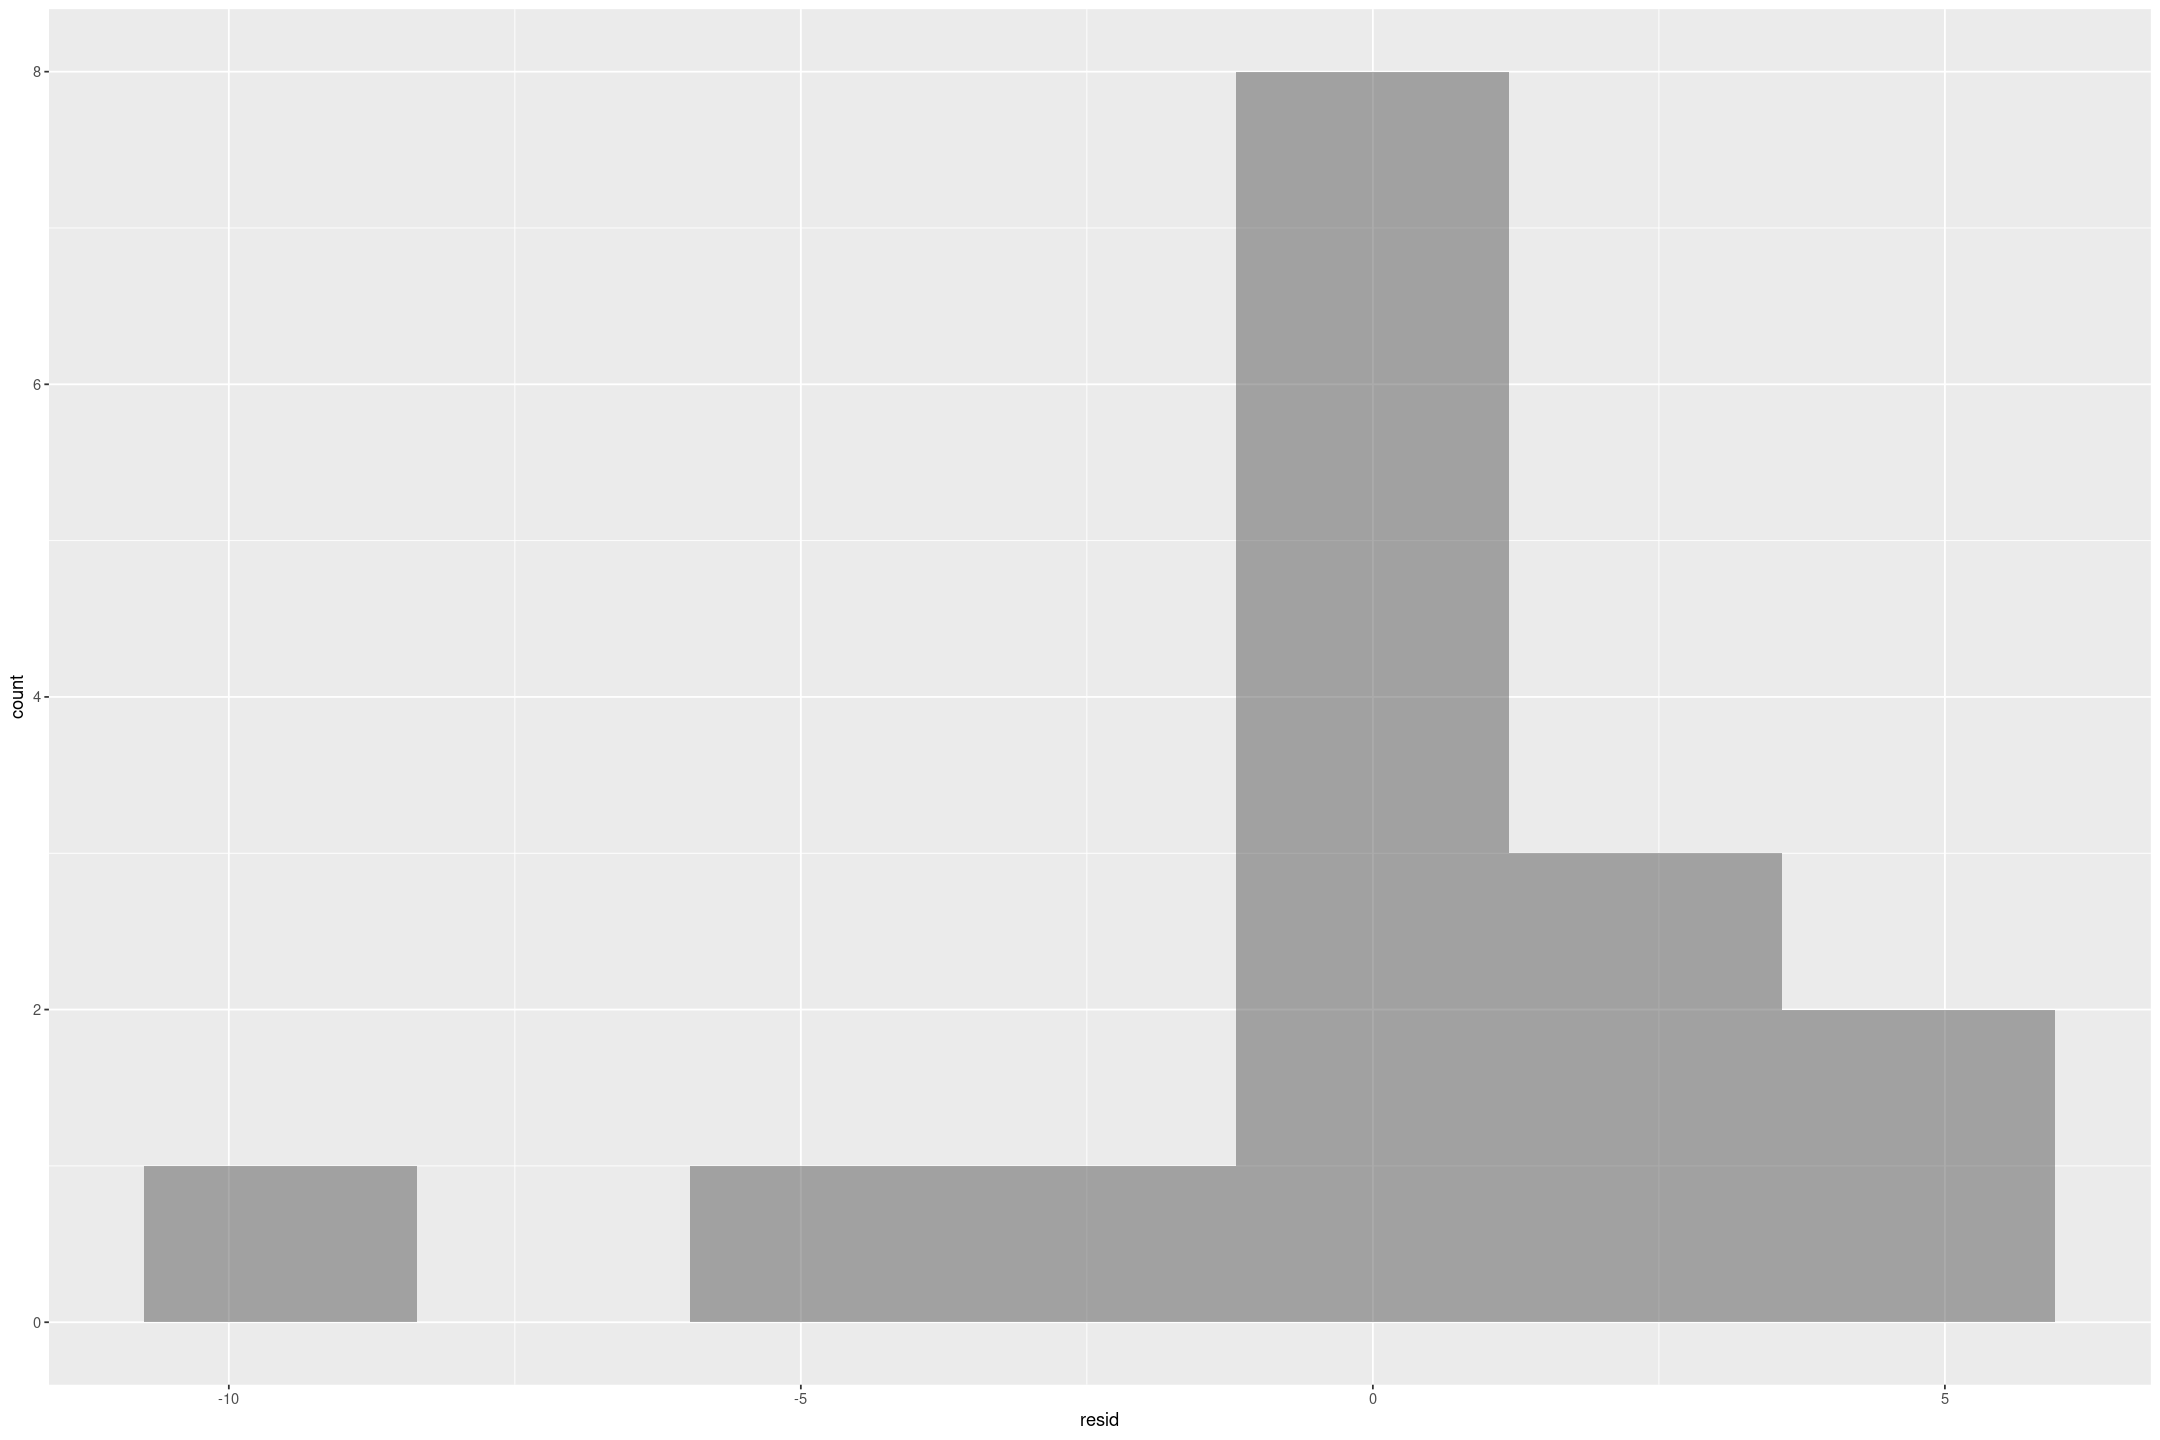

In [13]:
hibbs %>% gf_histogram(~resid, bins=7)

It's not obviously different from some of these

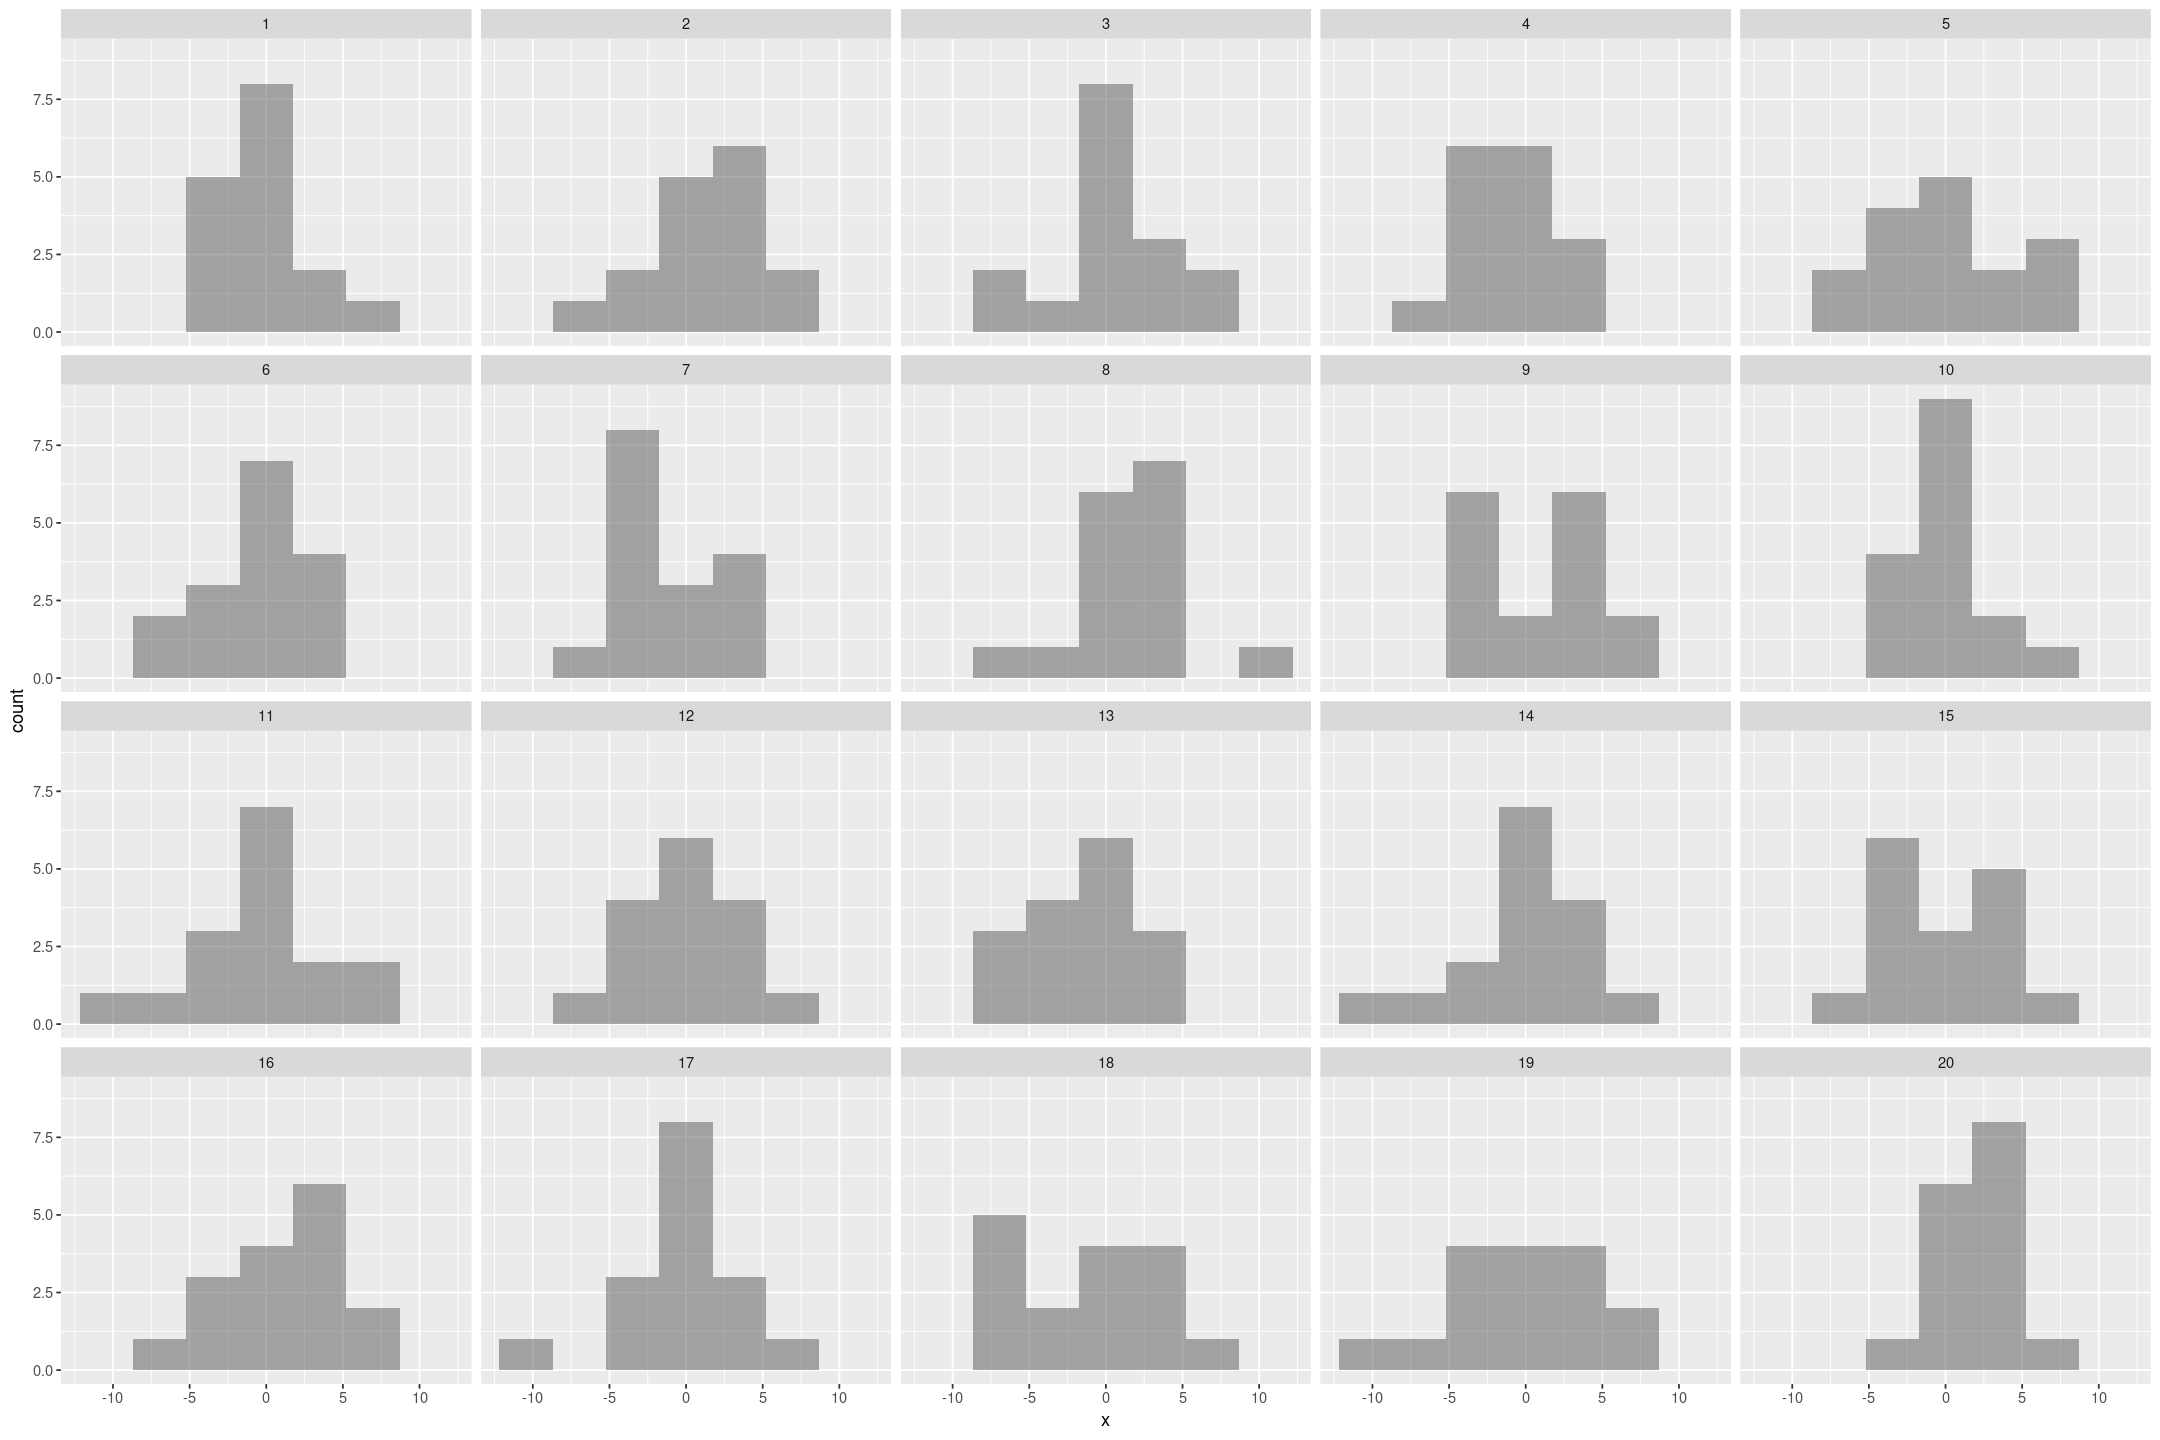

In [14]:
n_sample = 20
tibble(x=resid_sd*rnorm(nrow(hibbs)*n_sample), sample=rep(1:n_sample, nrow(hibbs))) %>%
gf_histogram(~x | sample, bins=7)

Or these

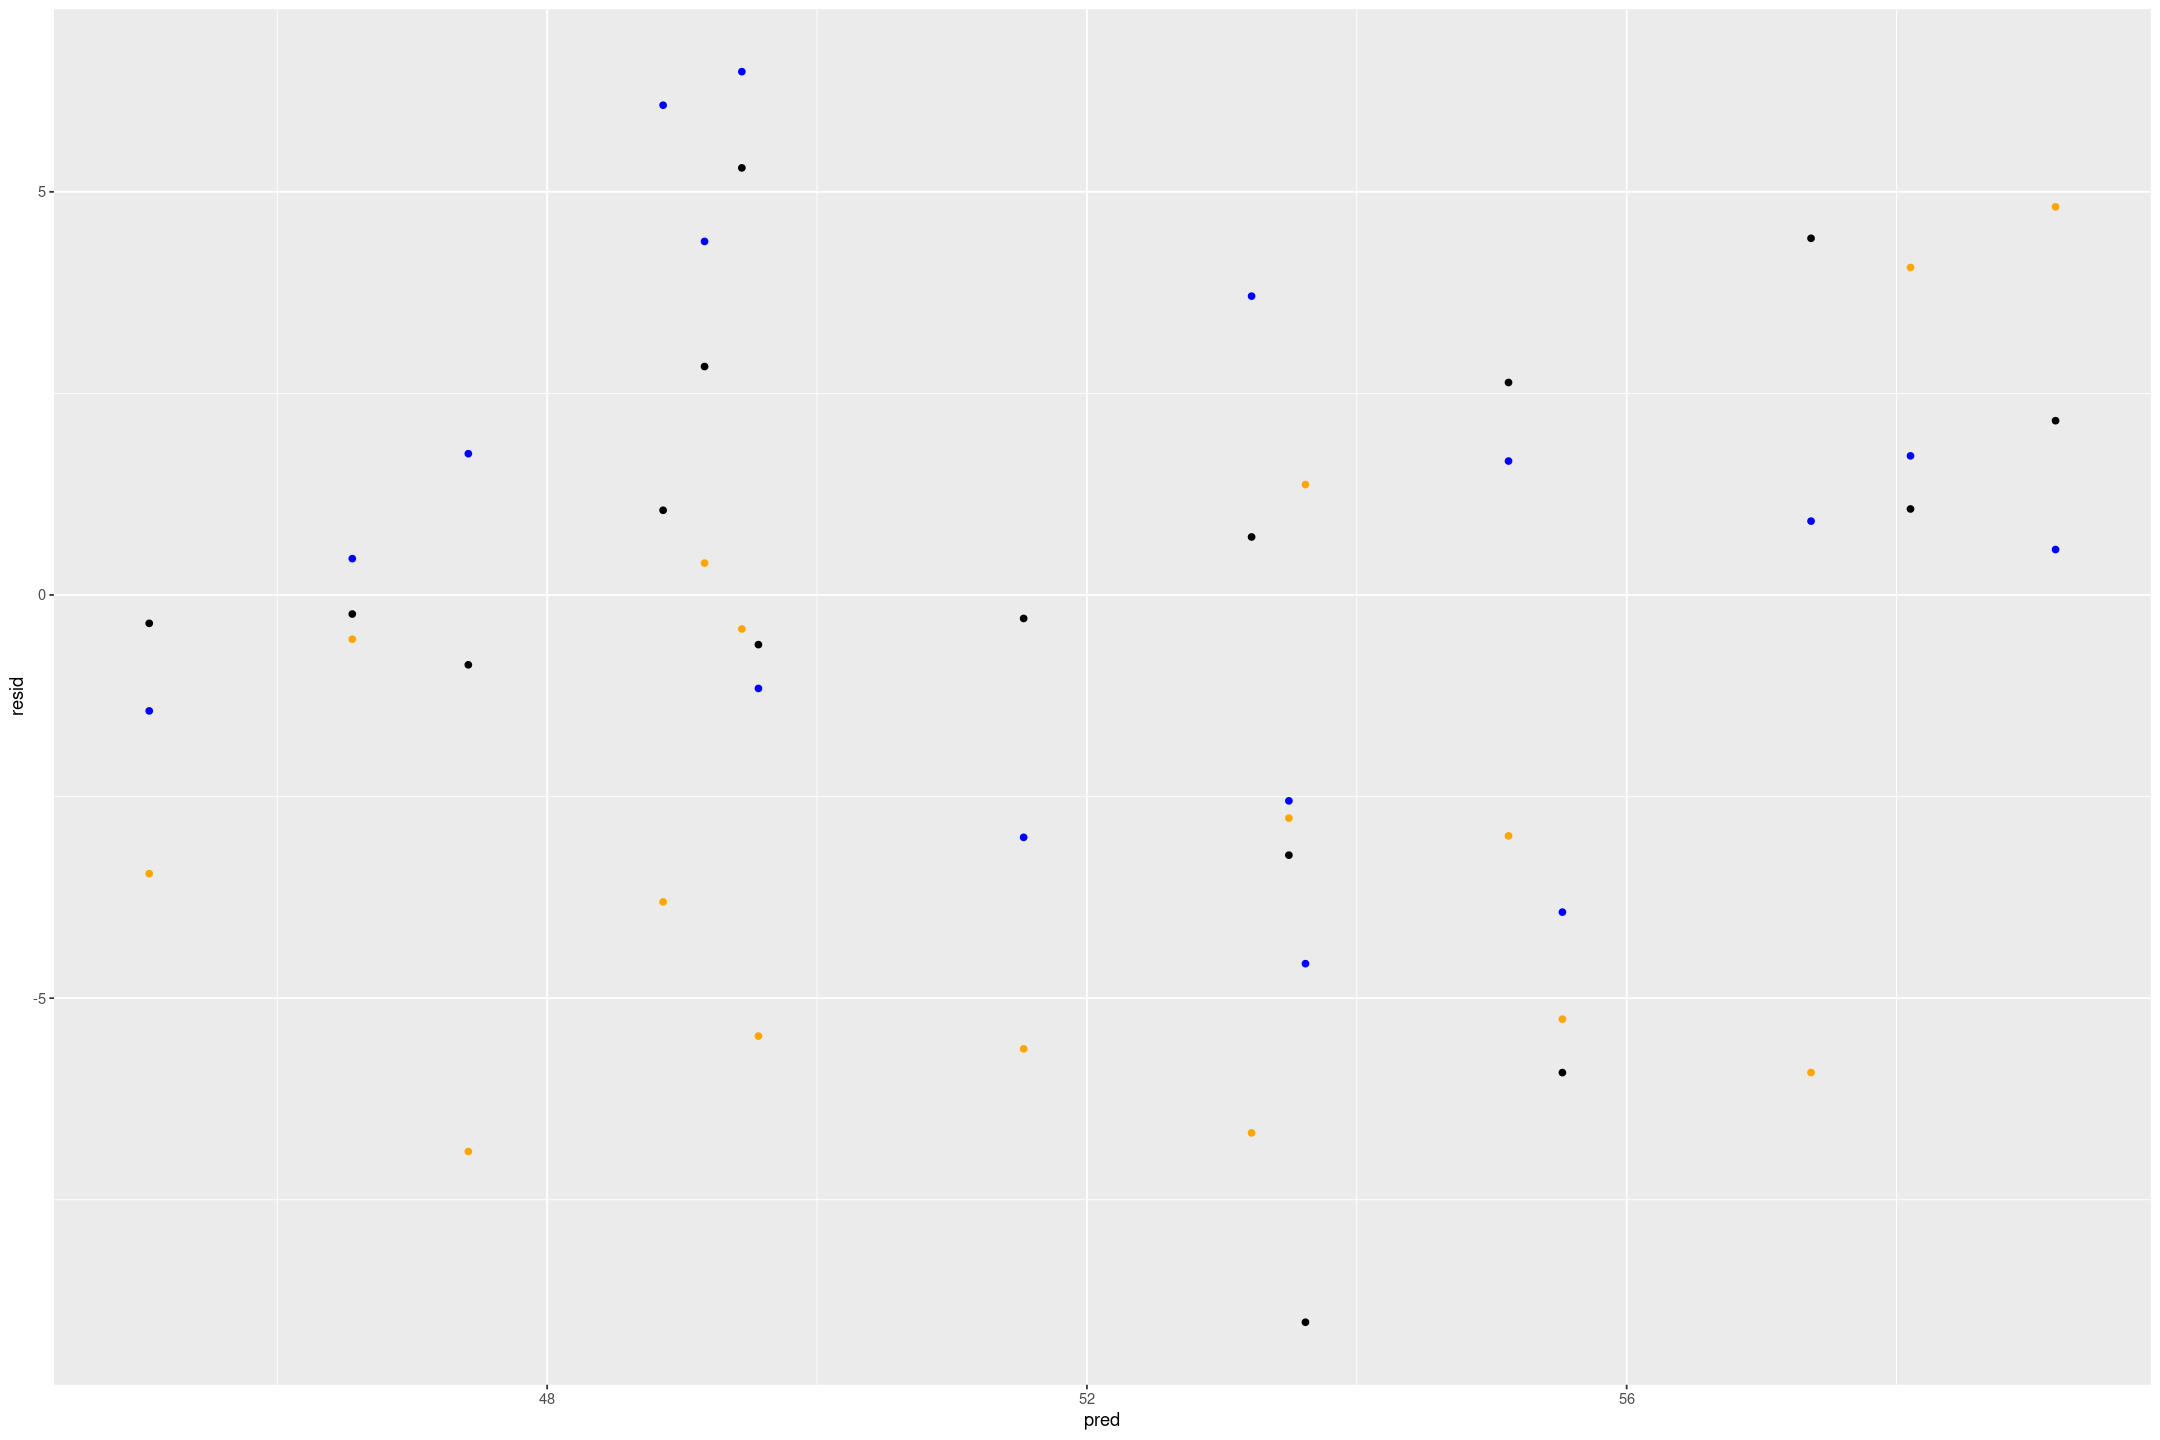

In [15]:
hibbs %>% 
gf_point(resid ~ pred) %>%
gf_point(resid_sd*rnorm(nrow(hibbs)) ~ pred, col='blue') %>%
gf_point(resid_sd*rnorm(nrow(hibbs)) ~ pred, col='orange') 

# Descriptive and causal inference

##  Growth as Descriptive variable
For the model in Section 7.1 predicting presidential vote share from the economy, describe the coefficient for economic growth in purely descriptive, non-causal terms.

In [16]:
hibbs_model

stan_glm
 family:       gaussian [identity]
 formula:      vote ~ growth
 observations: 16
 predictors:   2
------
            Median MAD_SD
(Intercept) 46.2    1.6  
growth       3.1    0.7  

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.9    0.7   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

When comparing two elections where the (weighted average of) annualized quarterly real income growth differs by 1%, the two party prefered vote is on average 3 points higher for the incumbent party in the election with higher growth.

These elections have, on average, had the incumbent party 3 points higher in a 2-party preferred vote when the real income growth is 1% higher.

## Issues with causal interpretation
Explain the difficulties of interpreting that coefficient as the effect of economic growth on the incumbent party's vote share.

There isn't enough evidence for a causal interpretation of the data.

For example income growth may be correlated with policies the incumbent party has enacted, and its the consideration of the policies that have led to a higher two-party preferred vote (though this explanation is, in my opinion, unlikely).

It is very difficult to test whether economic growth is a causal factor, because it's (nearly?) impossible to change economic growth in isolation of other factors.

# Coverage of confidence intervals

Consider the following proceduce

* Set n=100 and draw n continuous variables $x_i$ uniformly distributed between 0 and 10. Then simulate data from the model $ y_i = a + bx_i + \rm{error}_i $ for $ i = 1,\ldots,n$, with a=2, b=3, and independent errors from a normal distribution.
* Regress y on x. Look at the median and mad sd of b. Check to see if the interval formed by the median $ \pm 2$ mad sd includes the true value, b=3.
* Repeat the above 2 steps 1000 times.

In [17]:
run_simulation <- function() {
    n <- 100
    x <- runif(n, 0, 10)
    y <- 2 + 3*x + rnorm(n)

    model <- stan_glm(y ~ x, data=data.frame(x,y), refresh=0)

    x_median <- coef(model)[['x']]
    x_se <- se(model)[['x']]
    
    (x_median - 2*x_se < 3) & (x_median + 2*x_se > 3)
}

In [18]:
start_time <- Sys.time()
samples <- replicate(1000, run_simulation()) 
Sys.time() - start_time

Time difference of 4.819698 mins

## Coverage
True of false: the interval should contain the true value approximately 950 times.
Explain your answer.

In each regression we're taking a sample of data and trying to estimate b.

If the distribution of our regression coefficients is a normal distribution centred on b, and the MAD sd is a good approximation for its standard deviation, then the coverage would be around 95%. In this circumstance the interval should contain the true value approximately 950 times.

Given our equation:

$$ y_i = a + b x_i + \epsilon_i $$

and plugging it into the least squares estimate for b (which `stan_glm` approximates):

$$ \hat{b} = \frac{\sum_{i=1}^{n} (x_i - \bar{x}) y_i}{\sum_{i=1}^{n}(x_i - \bar{x})^2} $$

gives after simplifying:

$$ \hat{b} = b + \frac{\sum_{i=1}^{n} (x_i - \bar{x}) \epsilon_i}{\sum_{i=1}^{n}(x_i - \bar{x})^2} $$

This last term can be rewritten as a correlation:

$$ \hat{b} = b + \rho(x, \epsilon) \frac{\sigma_{\epsilon}}{\sigma_x} $$

Let's check this.

In [19]:
n <- 100
x <- runif(n, 0, 10)
eps <- rnorm(n)
y <- 2 + 3*x + eps

model <- stan_glm(y ~ x, data=data.frame(x,y), refresh=0)

x_median <- coef(model)[['x']]

In [20]:
x_median

[1] 2.972336

In [21]:
3 + cor(x, eps) * sd(eps) / sd(x)

[1] 2.972

So it all boils down to is the random $ \rho(x, \epsilon) \frac{\sigma_{\epsilon}}{\sigma_x} $ normal given that $\epsilon$ is?

I'm not sure how to prove this!

For large sample size it vanishes.

In [22]:
simulate_error <- function() {
    x <- runif(n, 0, 10)
    eps <- rnorm(n)
    cor(x, eps) * sd(eps) / sd(x)
}

It looks normalish

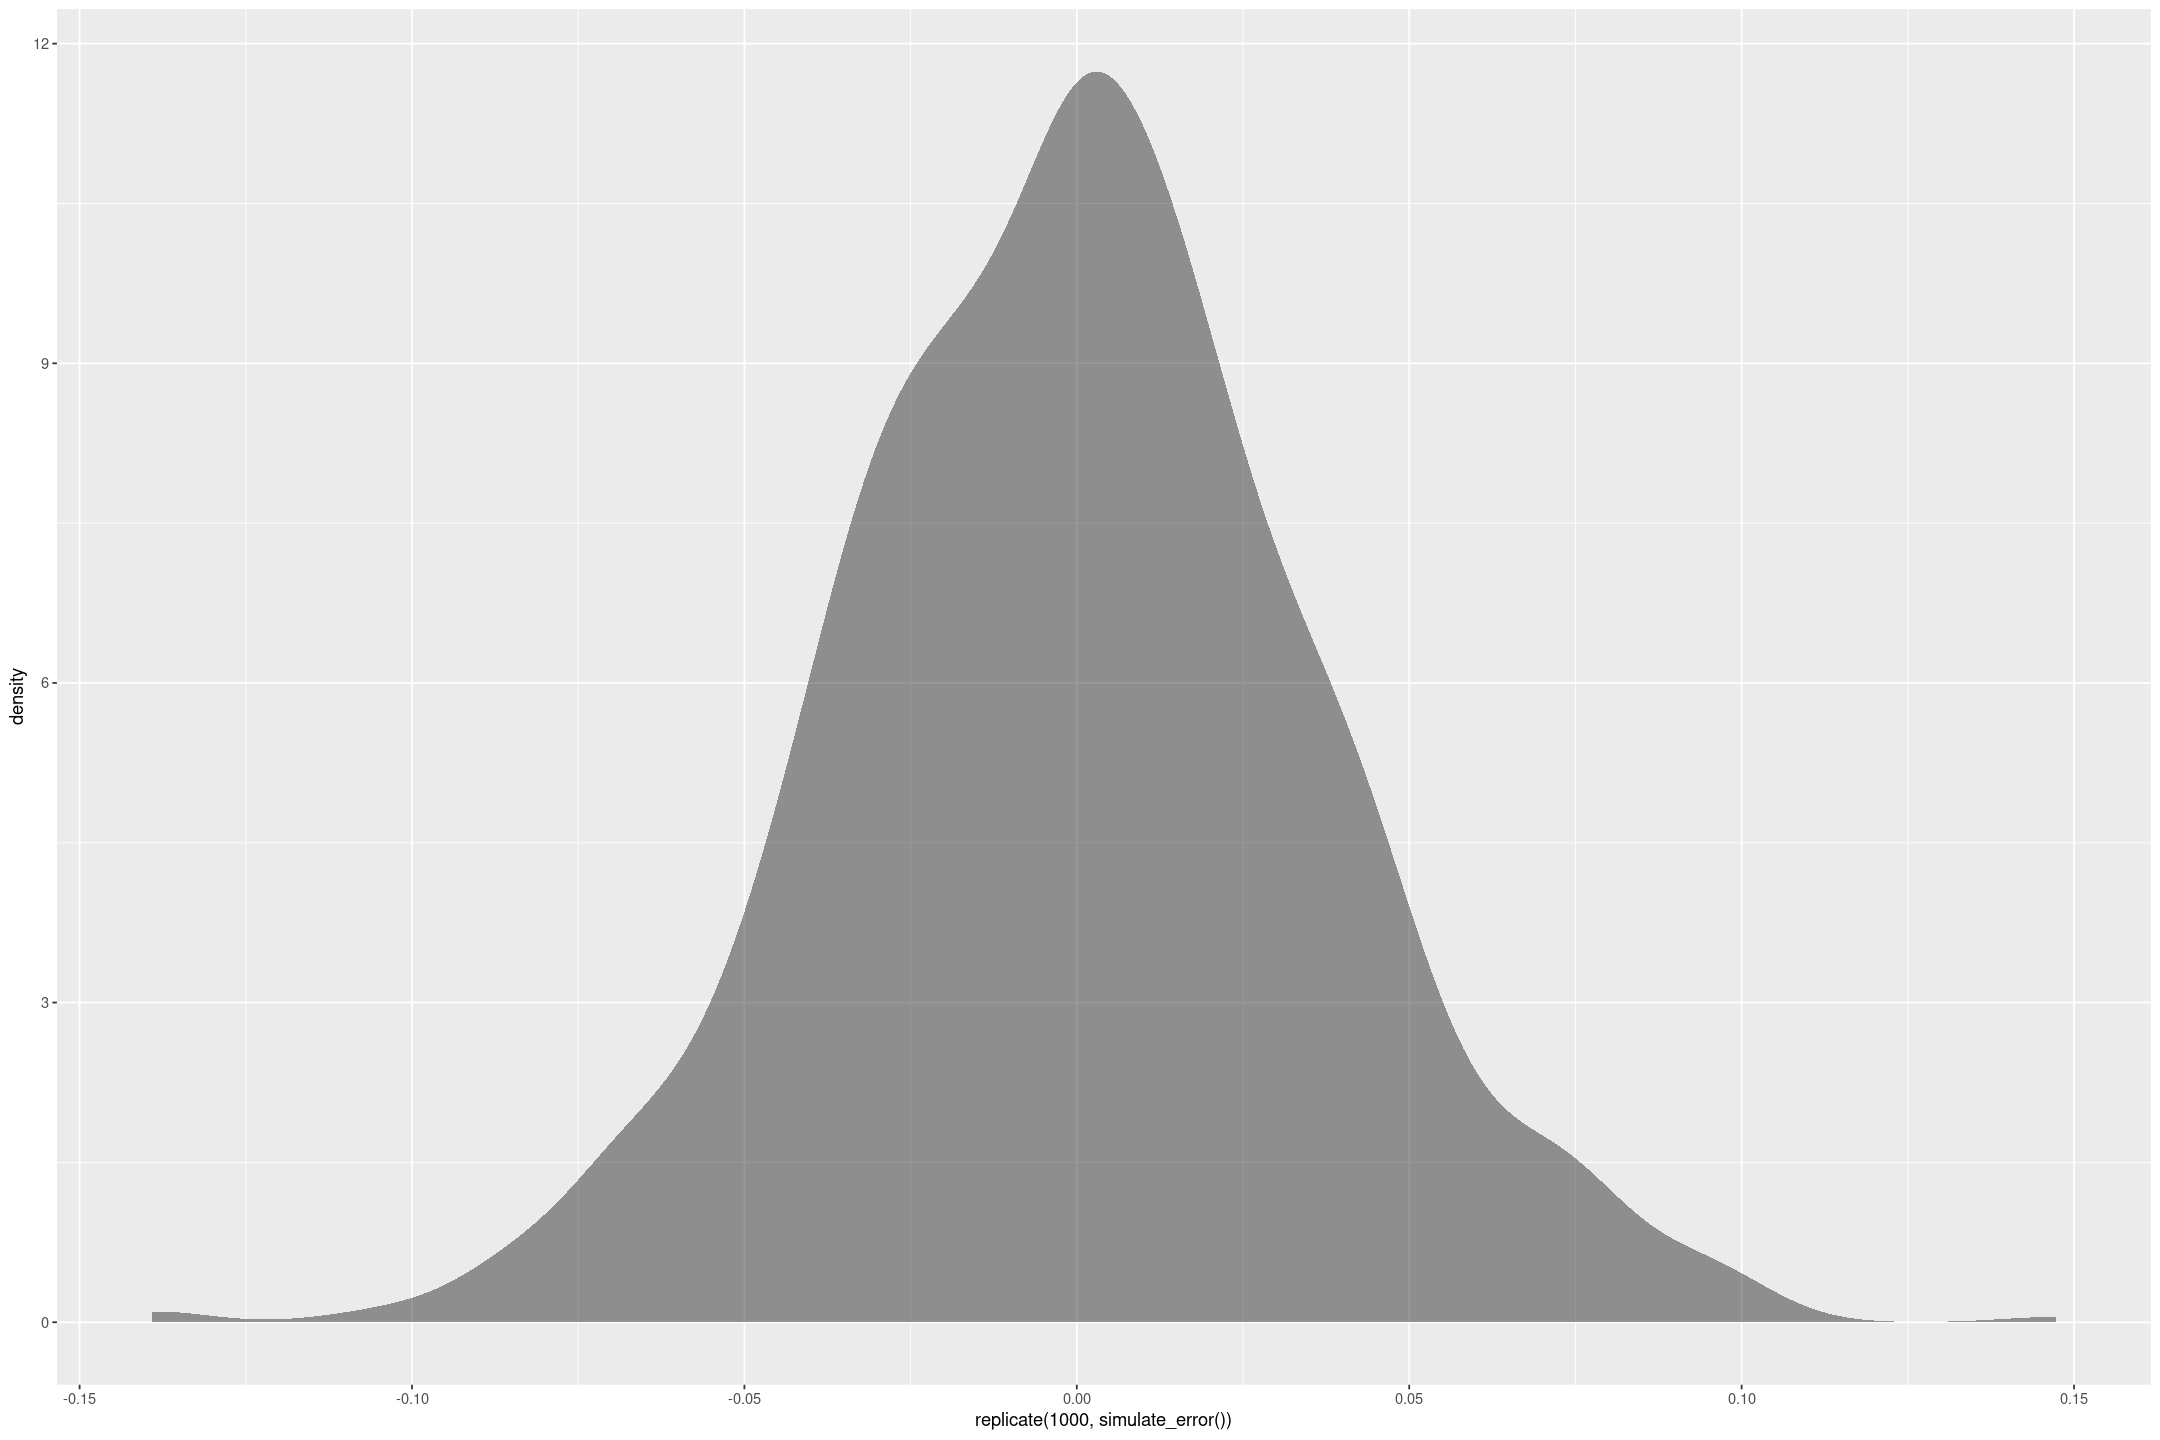

In [23]:
gf_density(~replicate(1000, simulate_error()))

And in practice the coverage is near 95%

In [24]:
mean(samples)

[1] 0.94

## Coverage for non-normal error distributions
Same as above, except the error distribution is bimodal, not normal.
True or false: the interval should contain the true value approximately 950 times.
Explain your answer.

Let's try it and see what the coefficients look like.

First generate our bimodal error.

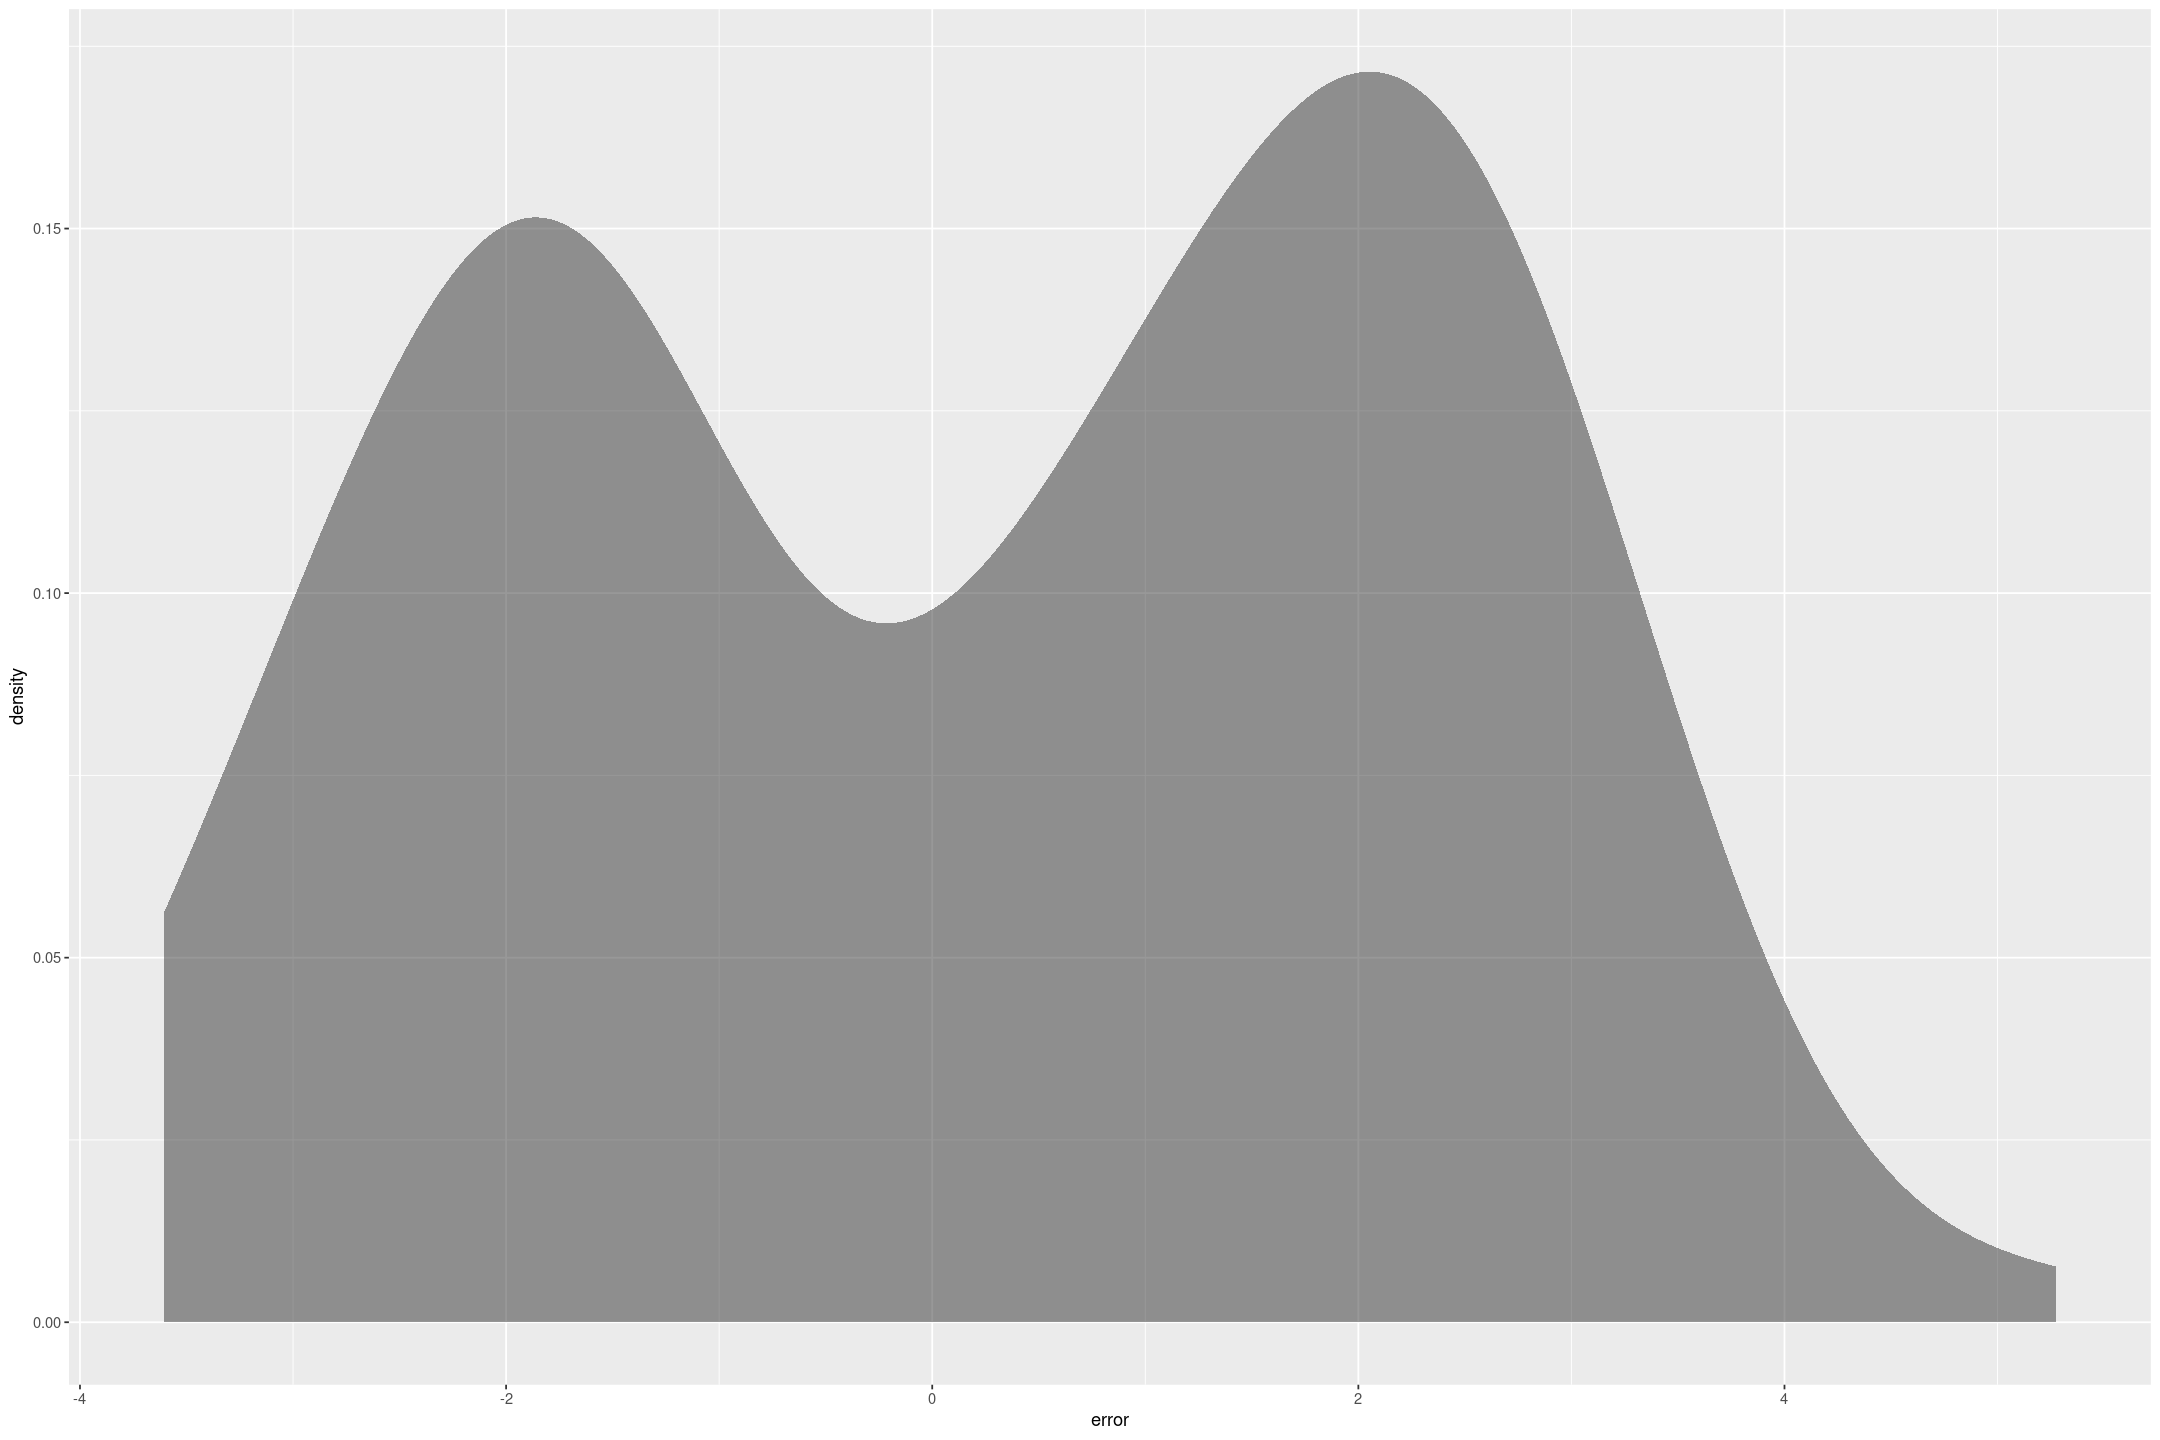

In [25]:
n <- 100
error <- if_else(sample(c(TRUE,FALSE), n, TRUE), rnorm(n, -2), rnorm(n, 2))
gf_density(~error)

In [26]:
simulate_error <- function() {
    x <- runif(n, 0, 10)
    eps <- if_else(sample(c(TRUE,FALSE), n, TRUE), rnorm(n, -2), rnorm(n, 2))
    cor(x, eps) * sd(eps) / sd(x)
}

Well, look at that - it's looking pretty normalish!

I predict - for this distribution, yes it will.

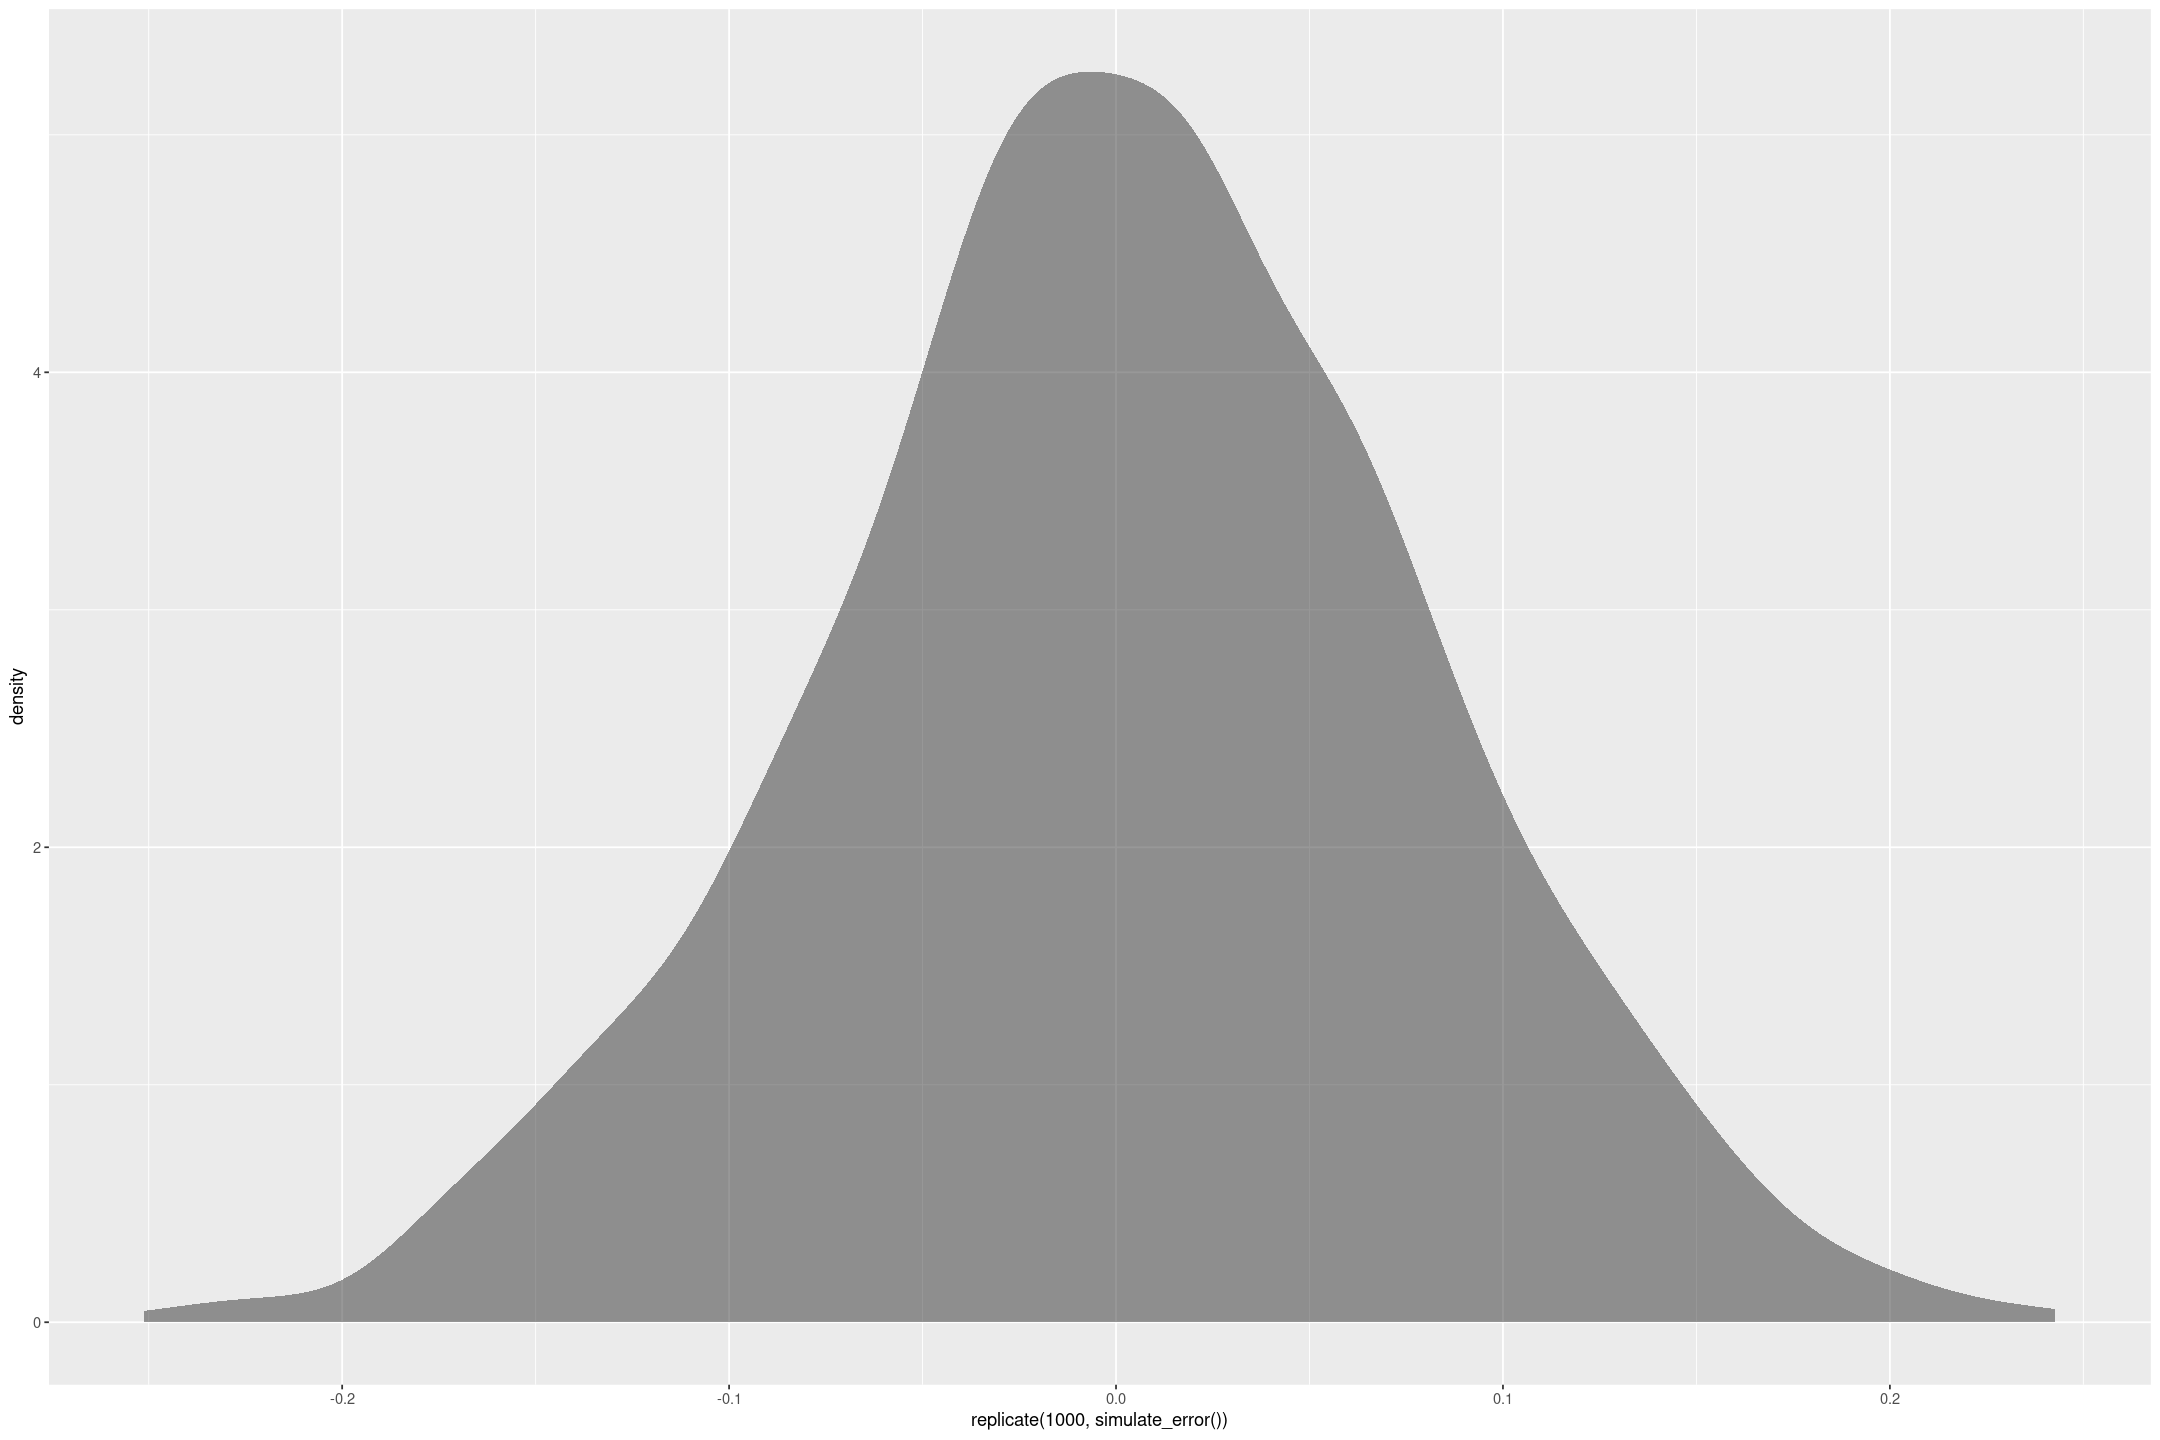

In [27]:
gf_density(~replicate(1000, simulate_error()))

In [28]:
run_simulation <- function() {
    n <- 100
    x <- runif(n, 0, 10)
    eps <- if_else(sample(c(TRUE,FALSE), n, TRUE), rnorm(n, -2), rnorm(n, 2))
    y <- 2 + 3*x + eps

    model <- stan_glm(y ~ x, data=data.frame(x,y), refresh=0)

    x_median <- coef(model)[['x']]
    x_se <- se(model)[['x']]
    
    (x_median - 2*x_se < 3) & (x_median + 2*x_se > 3)
}

In [29]:
start_time <- Sys.time()
bimodal_samples <- replicate(100, run_simulation()) 
Sys.time() - start_time

Time difference of 28.09553 secs

And look at that.

In [30]:
mean(bimodal_samples)

[1] 0.93

### What about a distribution with more outliers?
Let's try a t-distribution with more extreme outliers.

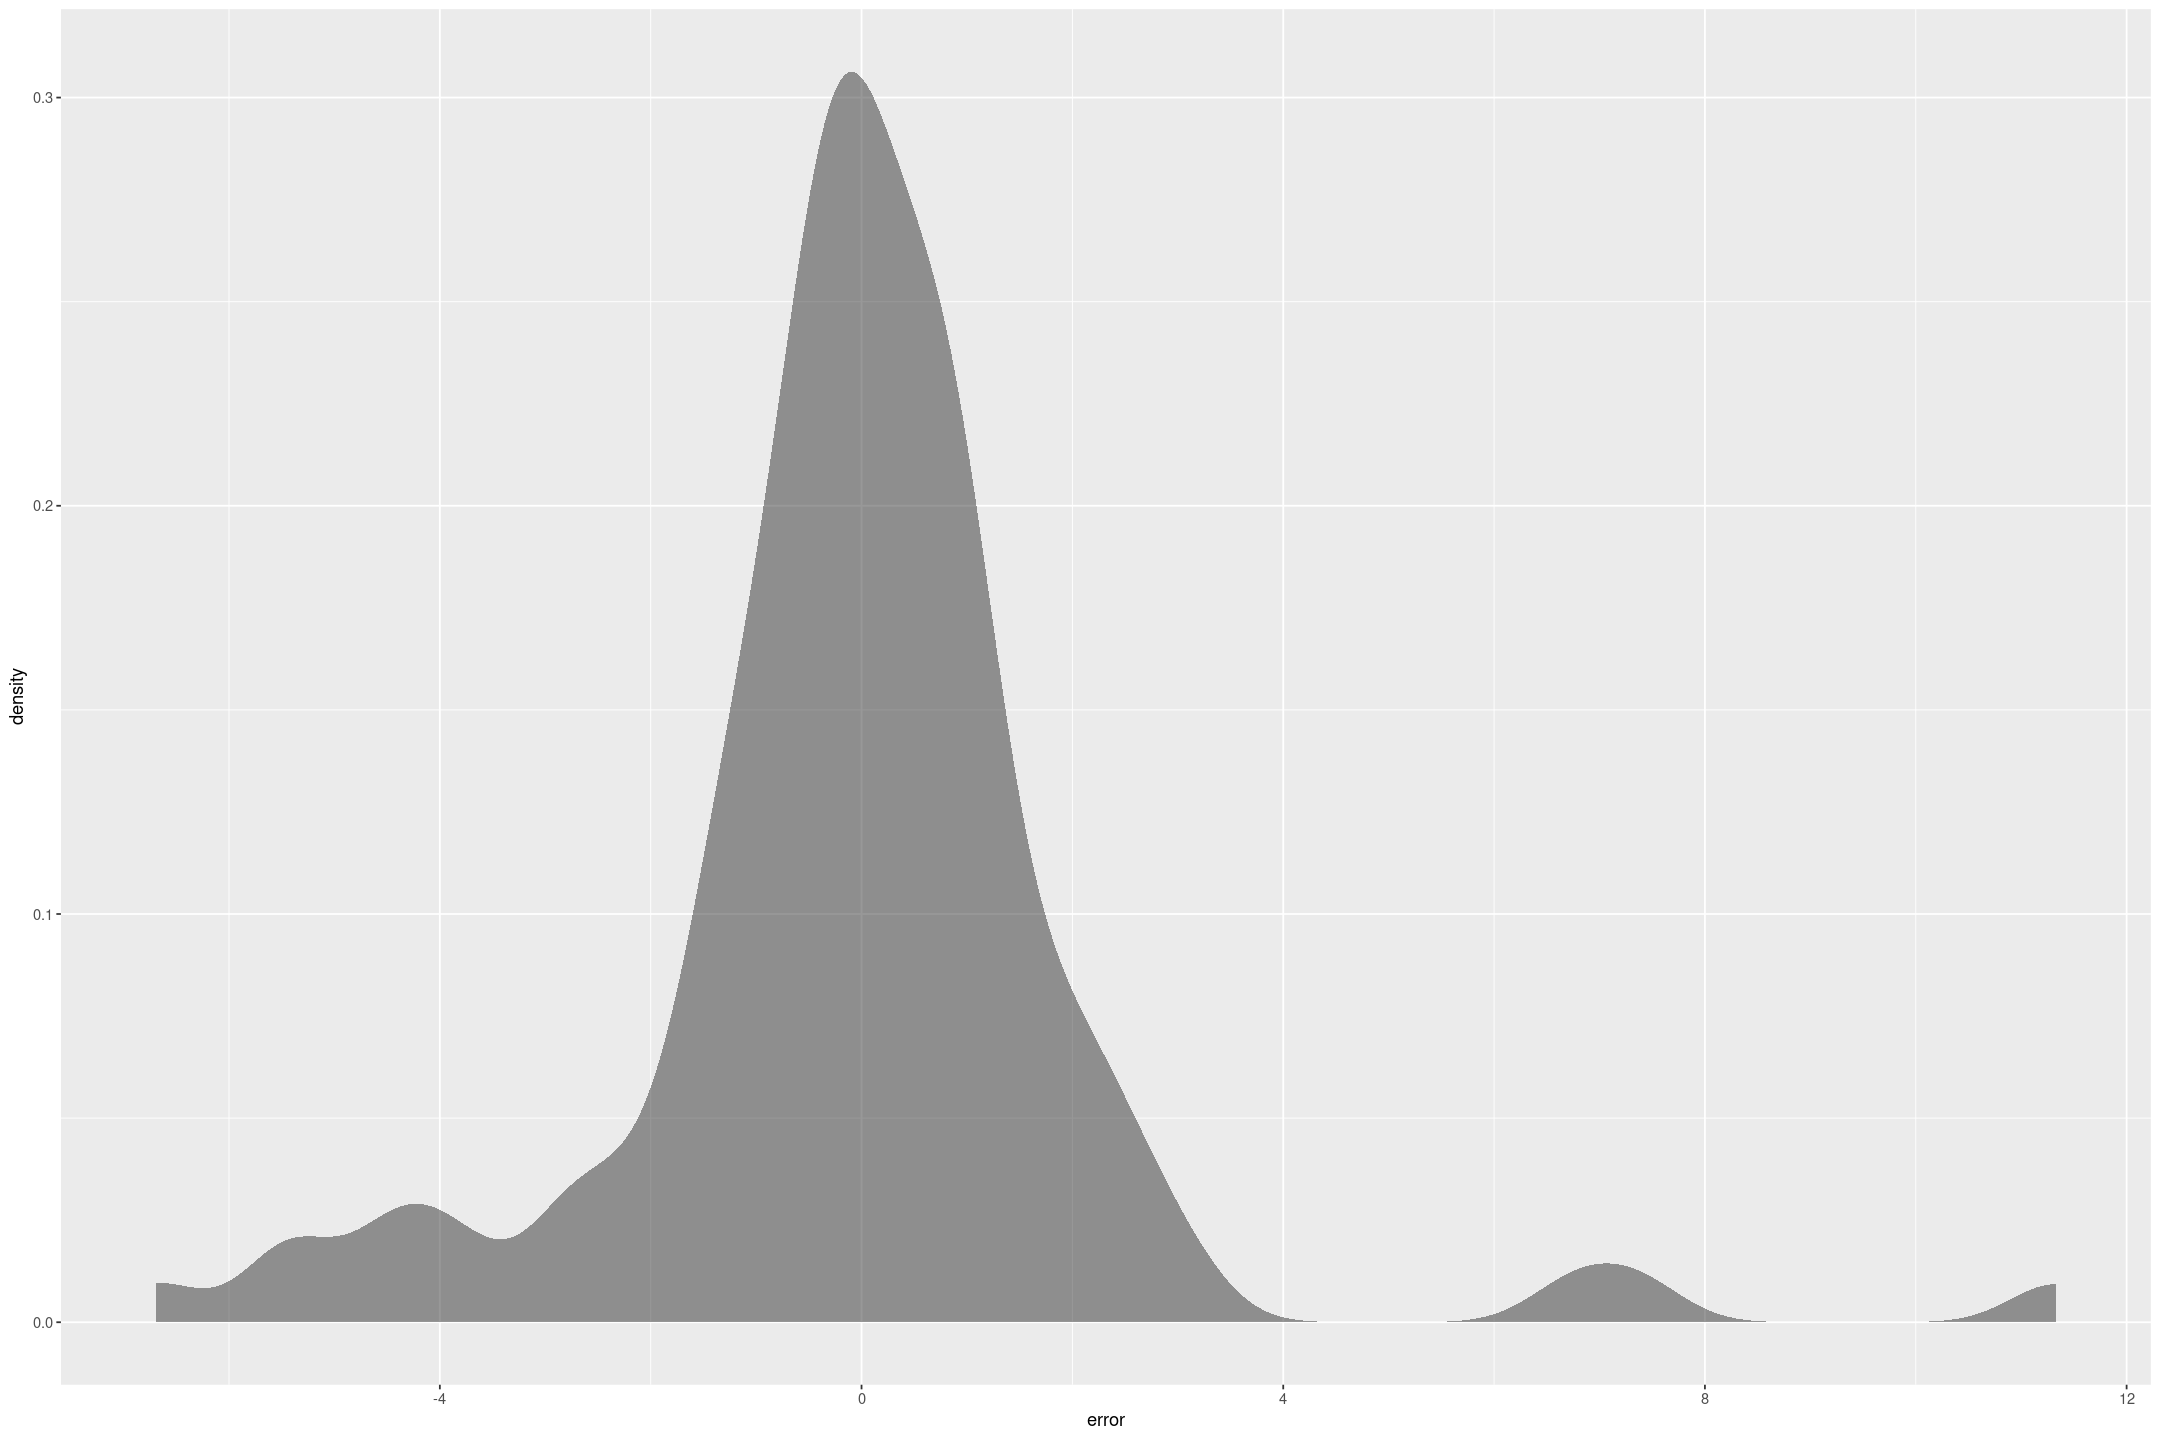

In [31]:
n <- 100
error <- rt(n, 2)
gf_density(~error)

In [32]:
simulate_error <- function() {
    x <- runif(n, 0, 10)
    eps <- rt(n,2)
    cor(x, eps) * sd(eps) / sd(x)
}

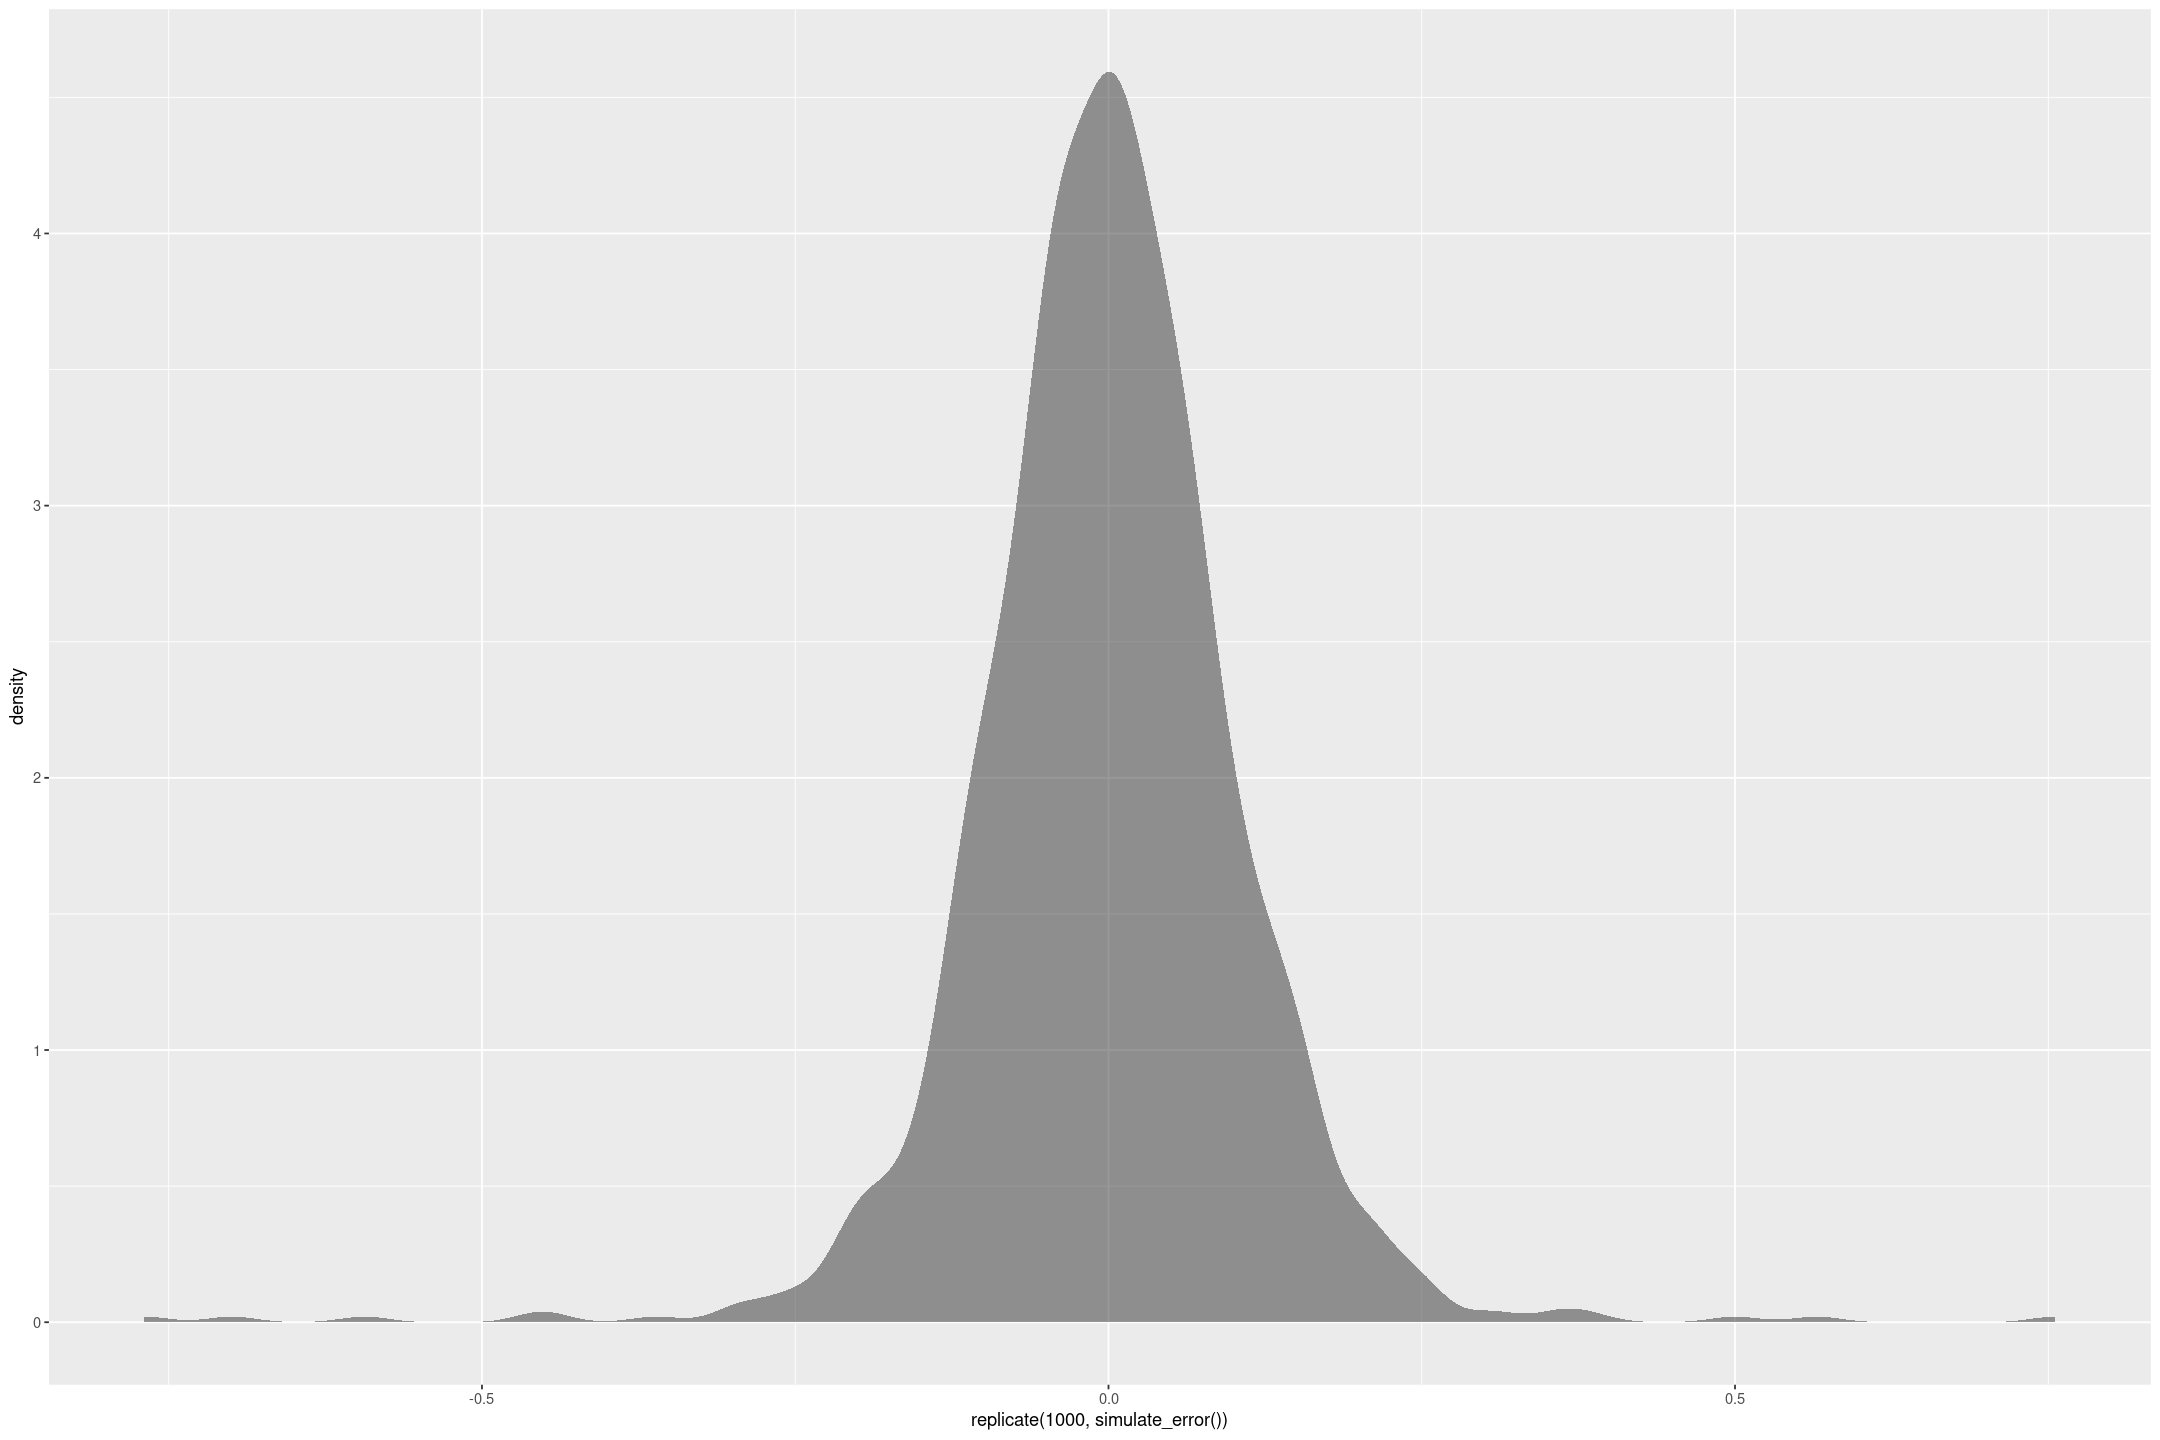

In [33]:
gf_density(~replicate(1000, simulate_error()))

In [34]:
run_simulation <- function() {
    n <- 100
    x <- runif(n, 0, 10)
    eps <- rt(n,2)
    y <- 2 + 3*x + eps

    model <- stan_glm(y ~ x, data=data.frame(x,y), refresh=0)

    x_median <- coef(model)[['x']]
    x_se <- se(model)[['x']]
    
    (x_median - 2*x_se < 3) & (x_median + 2*x_se > 3)
}

In [35]:
start_time <- Sys.time()
r2_samples <- replicate(1000, run_simulation()) 
Sys.time() - start_time

Time difference of 4.734976 mins

In [36]:
mean(r2_samples)

[1] 0.959

#### What if n is smaller?

In [37]:
run_simulation <- function() {
    n <- 10
    x <- runif(n, 0, 10)
    eps <- rt(n,2)
    y <- 2 + 3*x + eps

    model <- stan_glm(y ~ x, data=data.frame(x,y), refresh=0)

    x_median <- coef(model)[['x']]
    x_se <- se(model)[['x']]
    
    (x_median - 2*x_se < 3) & (x_median + 2*x_se > 3)
}

In [38]:
start_time <- Sys.time()
r2_samples <- replicate(200, run_simulation()) 
Sys.time() - start_time

Time difference of 58.06763 secs

In [39]:
mean(r2_samples)

[1] 0.955

### Conclusion?

It seems pretty robust when the mean of the error is zero (unbiased), but I don't know how to prove it!

Maybe we could appeal to some sort of central limit theorem?

$$ \hat{b} = b + \frac{1}{n \sigma_x^2}\sum_{i=1}^{n} (x_i - \bar{x}) \epsilon_i$$

We're averaging independent random terms with mean 0 (that are, moreover, the product of 2 independent random terms with mean 0).

But I'm not sure how to prove it!

# Interpreting residual plots

Anna takes continuous data $x_1$ and binary data $x2$, creates fake data $y$ from the model, $ y = a + b_1 x_1 + b_2 x_2 + b_3 x_1 x_2 + \rm{error}$, and gives these data to Barb, who, not knowing how the data were contructed, fits a linear regression predicting $y$ from $x_1$ and $x_2$ but without the interaction.
In these data, Barb makes a residual plot of $y$ vs $x_1$, using dots and circles to display points with $x_2 = 0$ and $x_2 = 1$, respectively.
The residual plot indicates that she should fit the interaction model.
Sketch with pen on paper a residual plot that Barb could have seen after fitting the regression without interaction.

When Barb fits the model $$ y = \hat{a} + \hat{b}_1 x_1 + \hat{b}_2 x_2 $$ the resulting coefficients will be:

The points, with Barb's regression lines in red, could look something like this:

![Regression Points](images/ros_1104_points.jpeg)

Then the residuals could look something like this, with the $ x_2 = 0$ points mostly below zero, the $ x_2 = 1 $ points mostly above zero, and the effect getting larger with $x_1$ (for negative $x_1$ the effect would reverse).

![Residuals](images/ros_1104_residuals.jpeg)

Let's check this with code.

In [40]:
n <- 50
x1 <- runif(n, 0, 5)
x2 <- sample(c(FALSE,TRUE), n, replace=TRUE)
a <- 2
b1 <- 3
b2 <- 2
b3 <- 3
y <- a + b1 * x1 + b2 * x2 + b3 * x1 * x2 + rnorm(n)

fake_data <- data.frame(x1, x2, y)

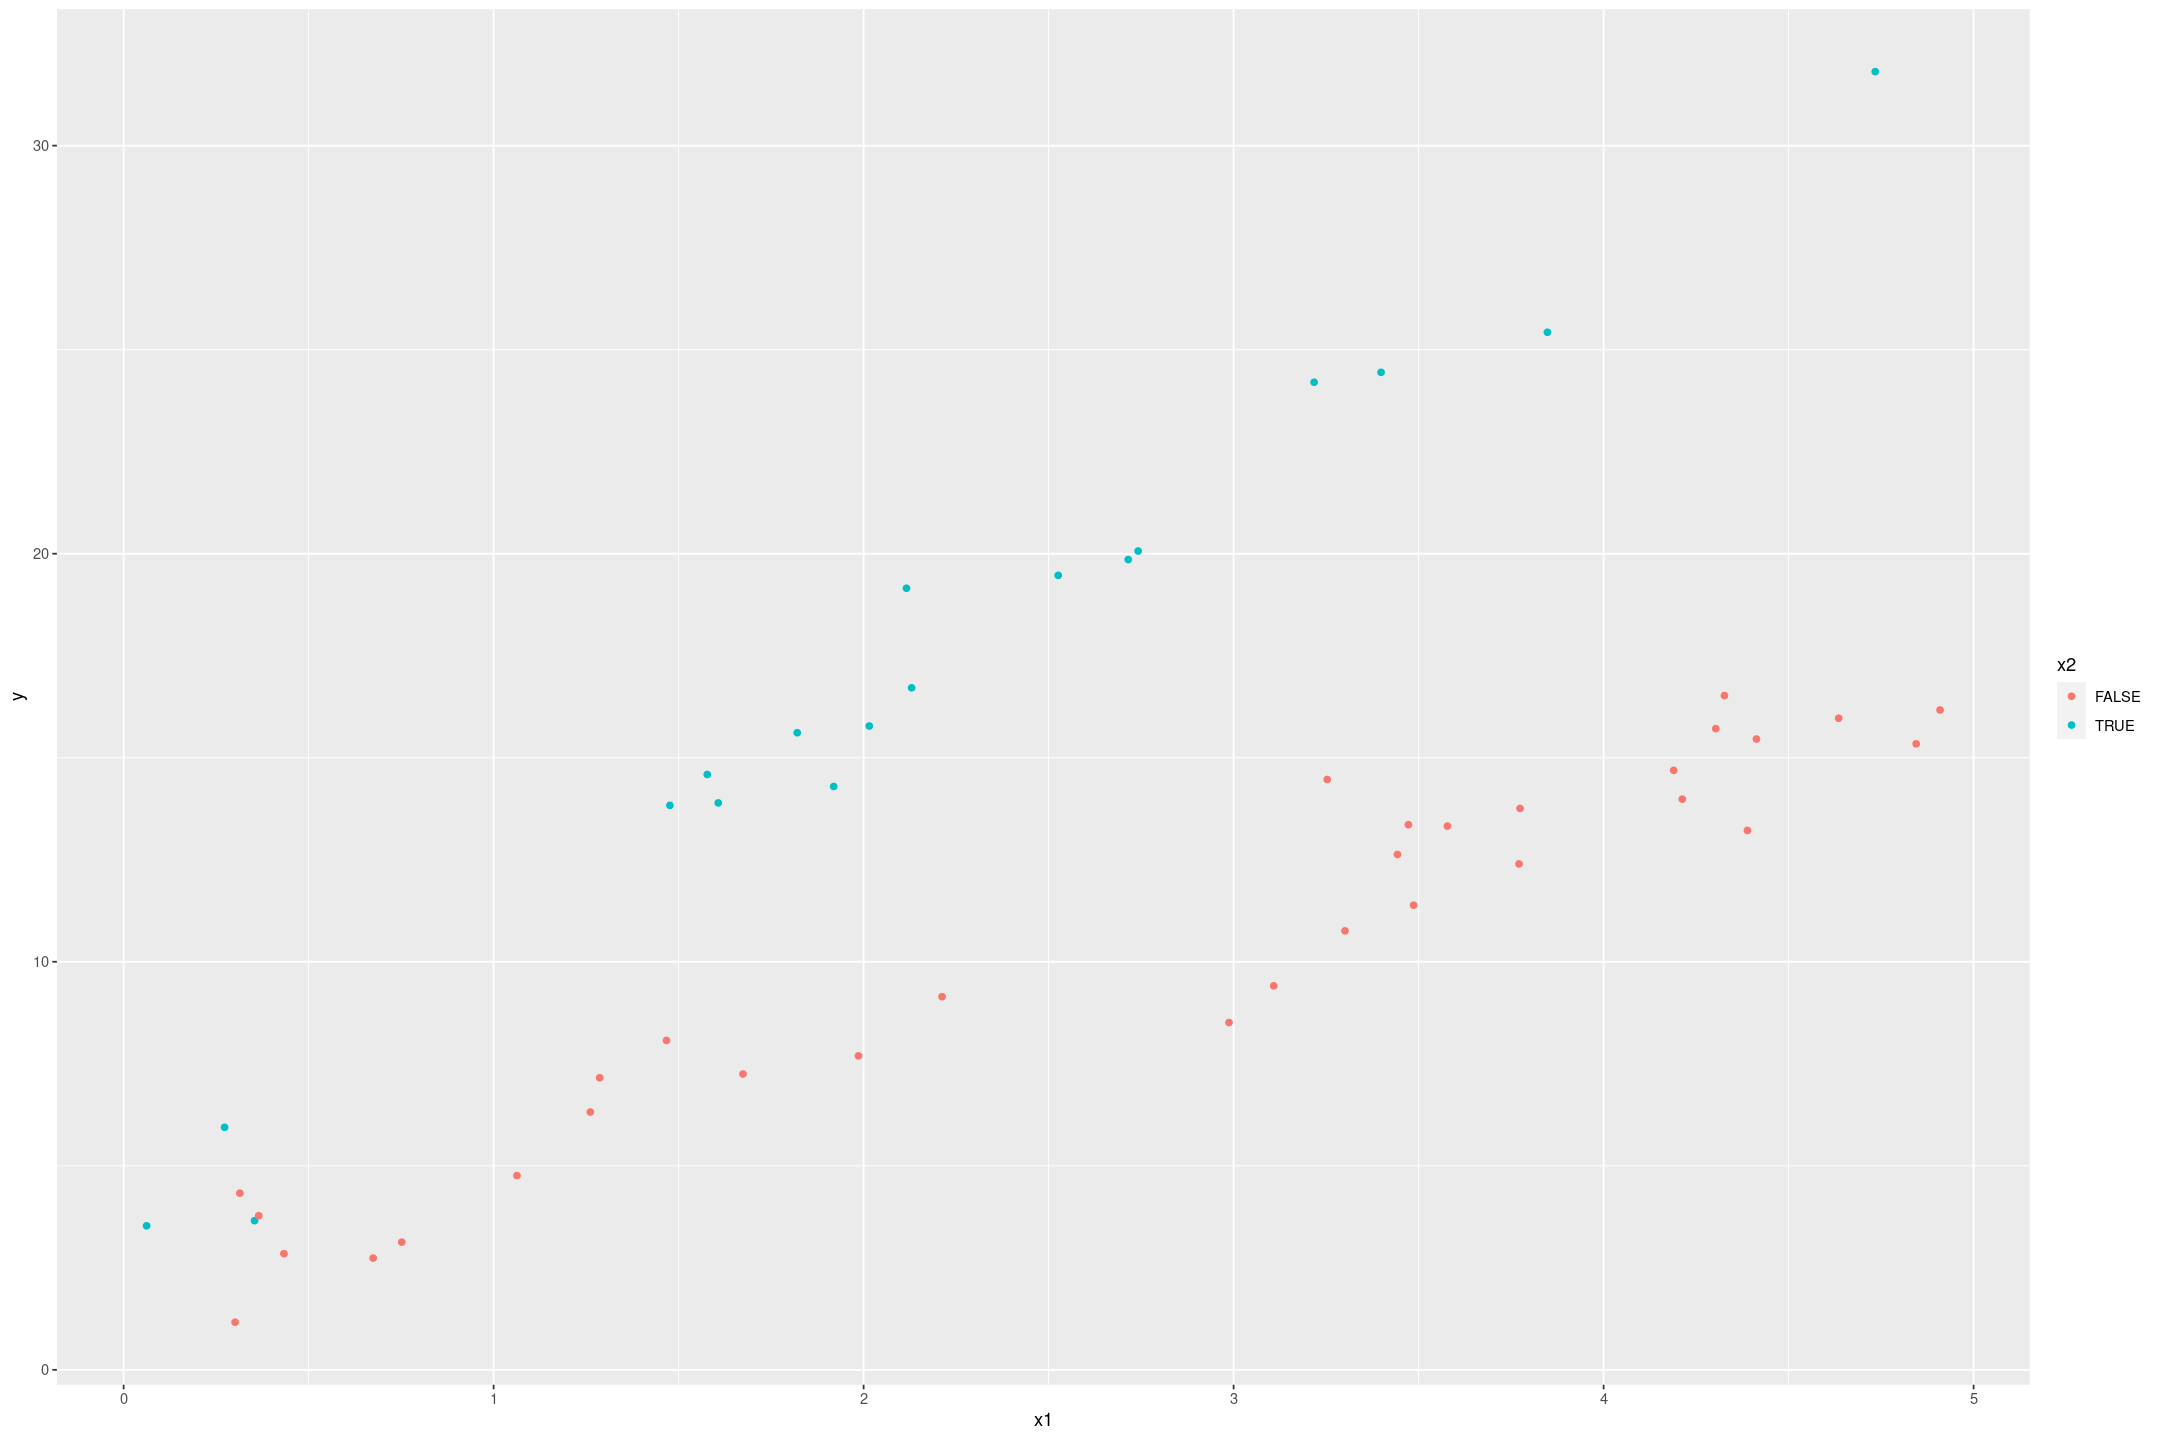

In [41]:
fake_data %>%
gf_point(y ~ x1, col=~x2)

In [42]:
barb_model <- stan_glm(y ~ x1 + x2, data=fake_data, refresh=0)
barb_model

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x1 + x2
 observations: 50
 predictors:   3
------
            Median MAD_SD
(Intercept) -0.1    0.8  
x1           3.7    0.2  
x2TRUE       8.9    0.7  

Auxiliary parameter(s):
      Median MAD_SD
sigma 2.3    0.2   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

The detail I missed in my sketch is the sign of the residuals changes - they slope in opposite directions.

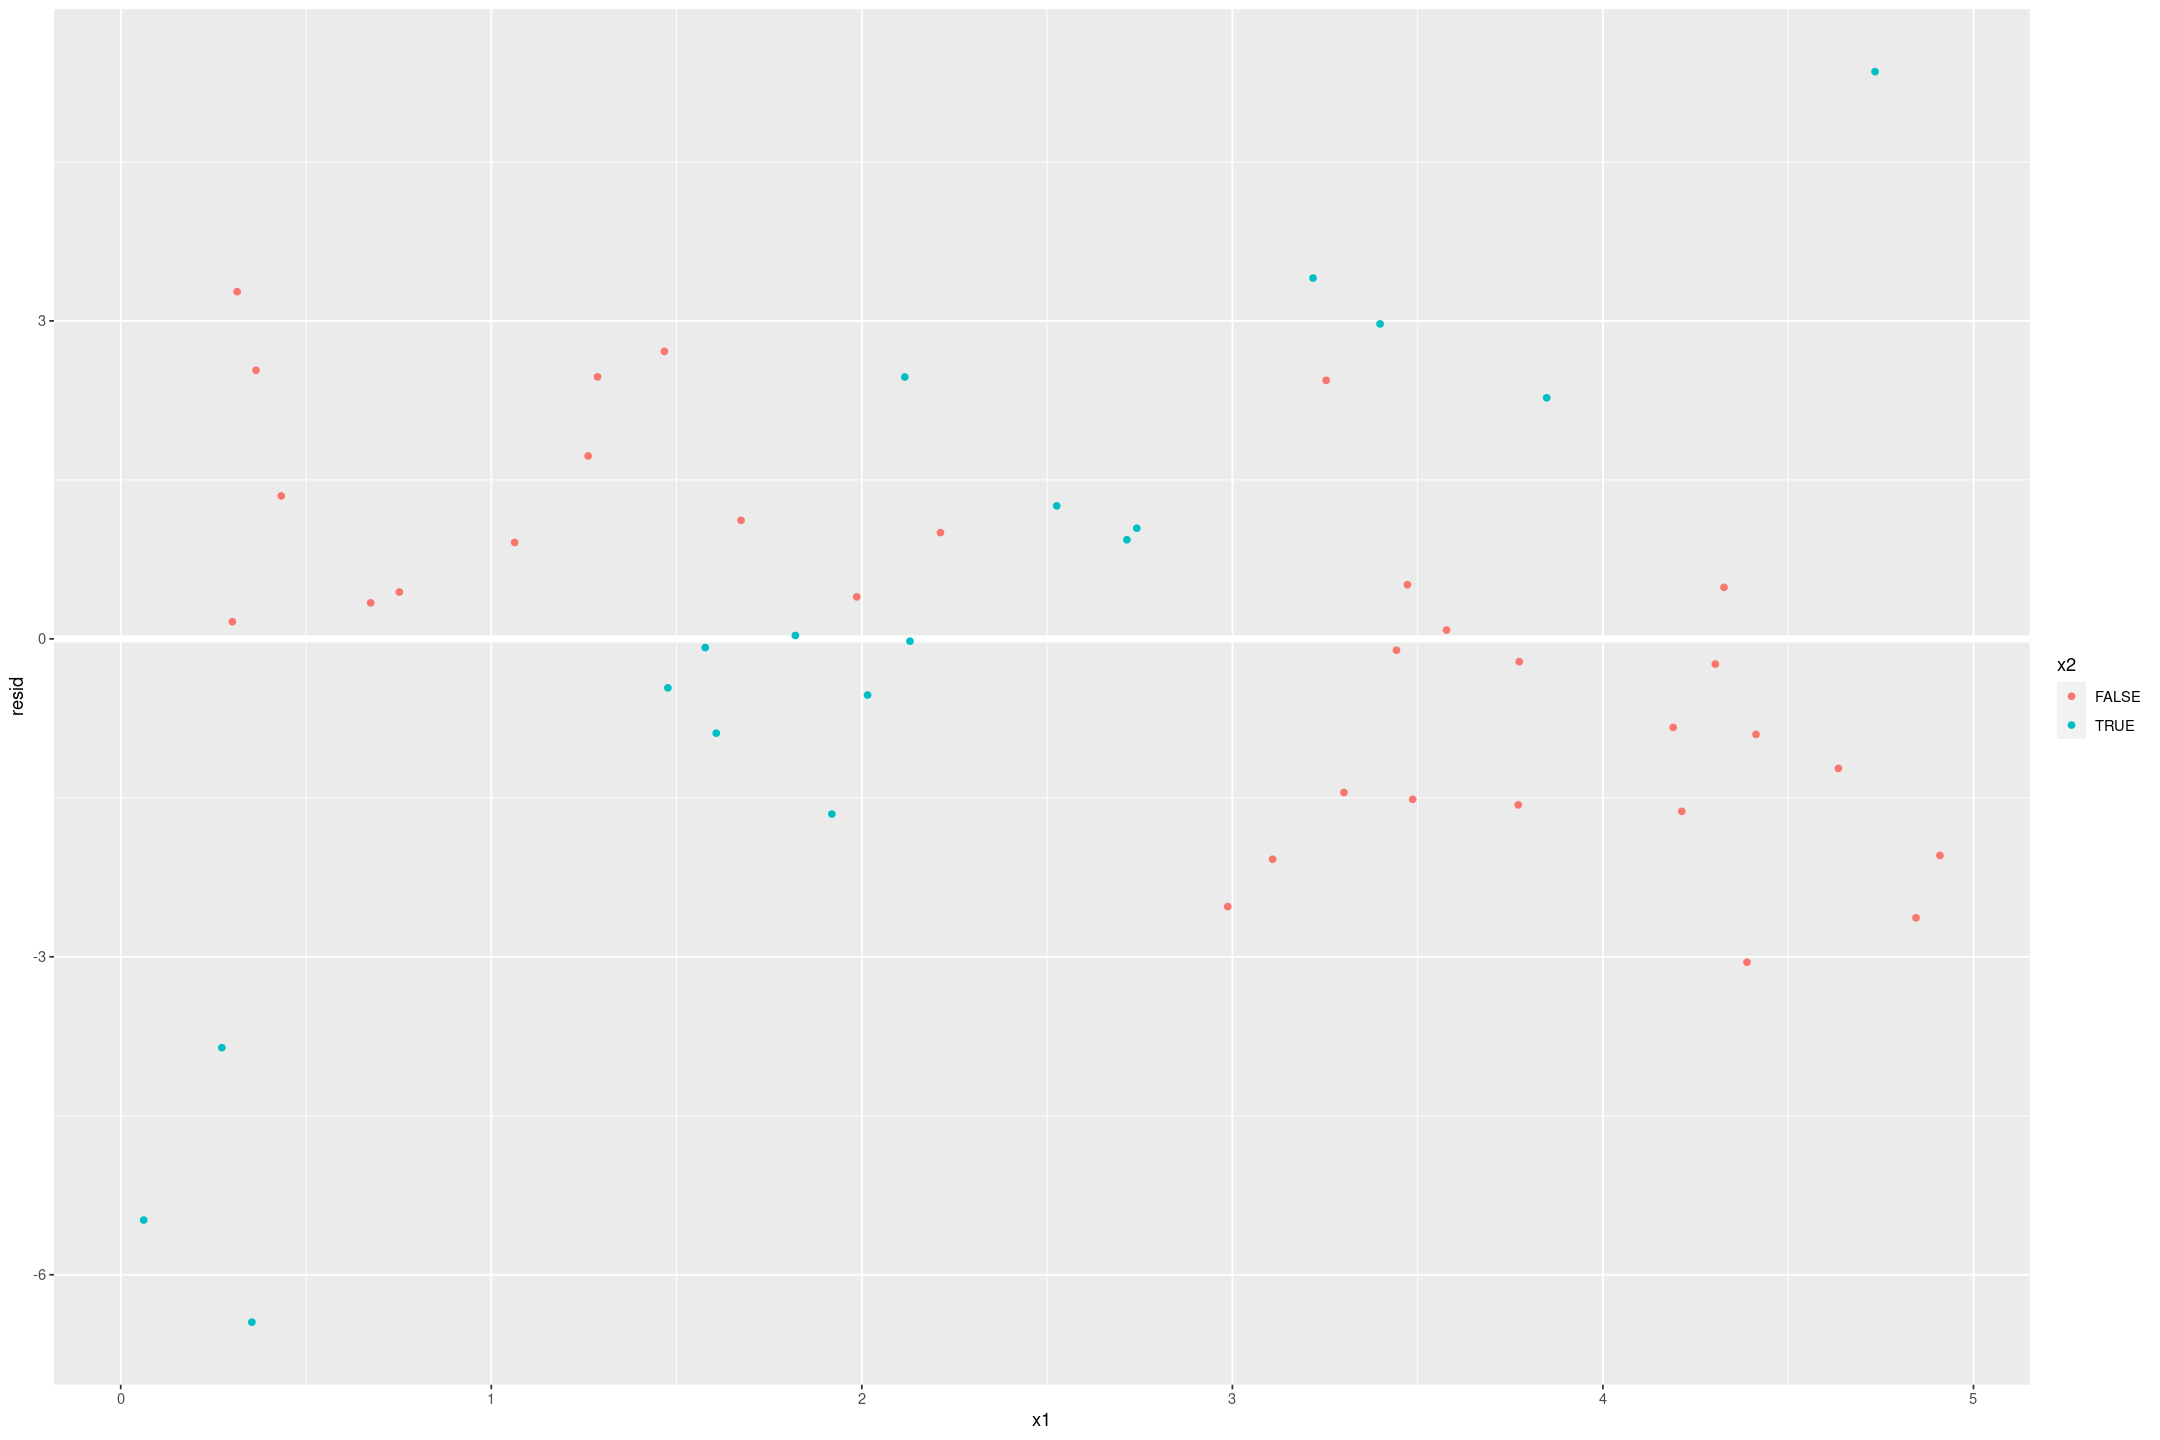

In [43]:
fake_data %>%
add_residuals(barb_model) %>%
gf_hline(yintercept = ~0, color = "white", size = 2) %>%
gf_point(resid ~ x1, col=~x2) 

# Residuals and predictions

The folder [`Pyth`](https://github.com/avehtari/ROS-Examples/tree/master/Pyth/) contains outcome $y$ and predictors $x_1$, $x_2$ for 40 data points, with a further 20 points with the predictors but no observed outcome.
Save the file to your working directory, then read it into R using `read.table()`.

In [44]:
filename <- "./data/Pyth/pyth.txt"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Pyth/pyth.txt')
pyth <- read.table(filename, header=TRUE)
pyth %>% t()

y,15.68,6.18,18.10,9.07,17.97,10.04,20.74,9.76,8.23,6.52,15.69,15.51,20.61,19.58,9.72,16.36,18.30,13.26,12.10,18.15,16.80,16.55,18.79,15.68,4.08,15.45,13.44,20.86,16.05,6.00,3.29,9.41,10.76,5.98,19.23,15.67,7.04,21.63,17.84,7.49,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
x1,6.87,4.40,0.43,2.73,3.25,5.30,7.08,9.73,4.51,6.40,5.72,6.28,6.14,8.26,9.41,2.88,5.74,0.45,3.74,5.03,9.67,3.62,2.54,9.15,0.69,7.97,2.49,9.81,7.56,0.98,0.65,9.00,7.83,0.26,3.64,9.28,5.66,9.71,9.36,0.88,9.87,9.99,8.39,0.80,9.58,4.82,2.97,8.80,6.07,0.19,4.19,5.39,6.58,2.36,2.37,1.52,2.07,6.70,2.02,9.63
x2,14.09,4.35,18.09,8.65,17.68,8.53,19.50,0.72,6.88,1.26,14.62,14.18,19.68,17.75,2.44,16.10,17.37,13.25,11.51,17.44,13.74,16.15,18.62,12.74,4.02,13.24,13.21,18.41,14.16,5.92,3.22,2.74,7.39,5.97,18.89,12.63,4.18,19.32,15.19,7.43,10.43,15.72,0.35,10.91,15.82,11.90,2.46,4.09,1.80,13.54,19.13,14.84,5.28,15.42,4.12,6.54,2.67,12.85,8.36,12.16


## Fit a model

Use R to fit a linear regression model predicting $y$ from $x_1$, $x_2$, using the first 40 data points in the file.
Summarize the inferences and check the fit of your model.

In [45]:
pyth_sample <- head(pyth, 40)
nrow(pyth_sample)

[1] 40

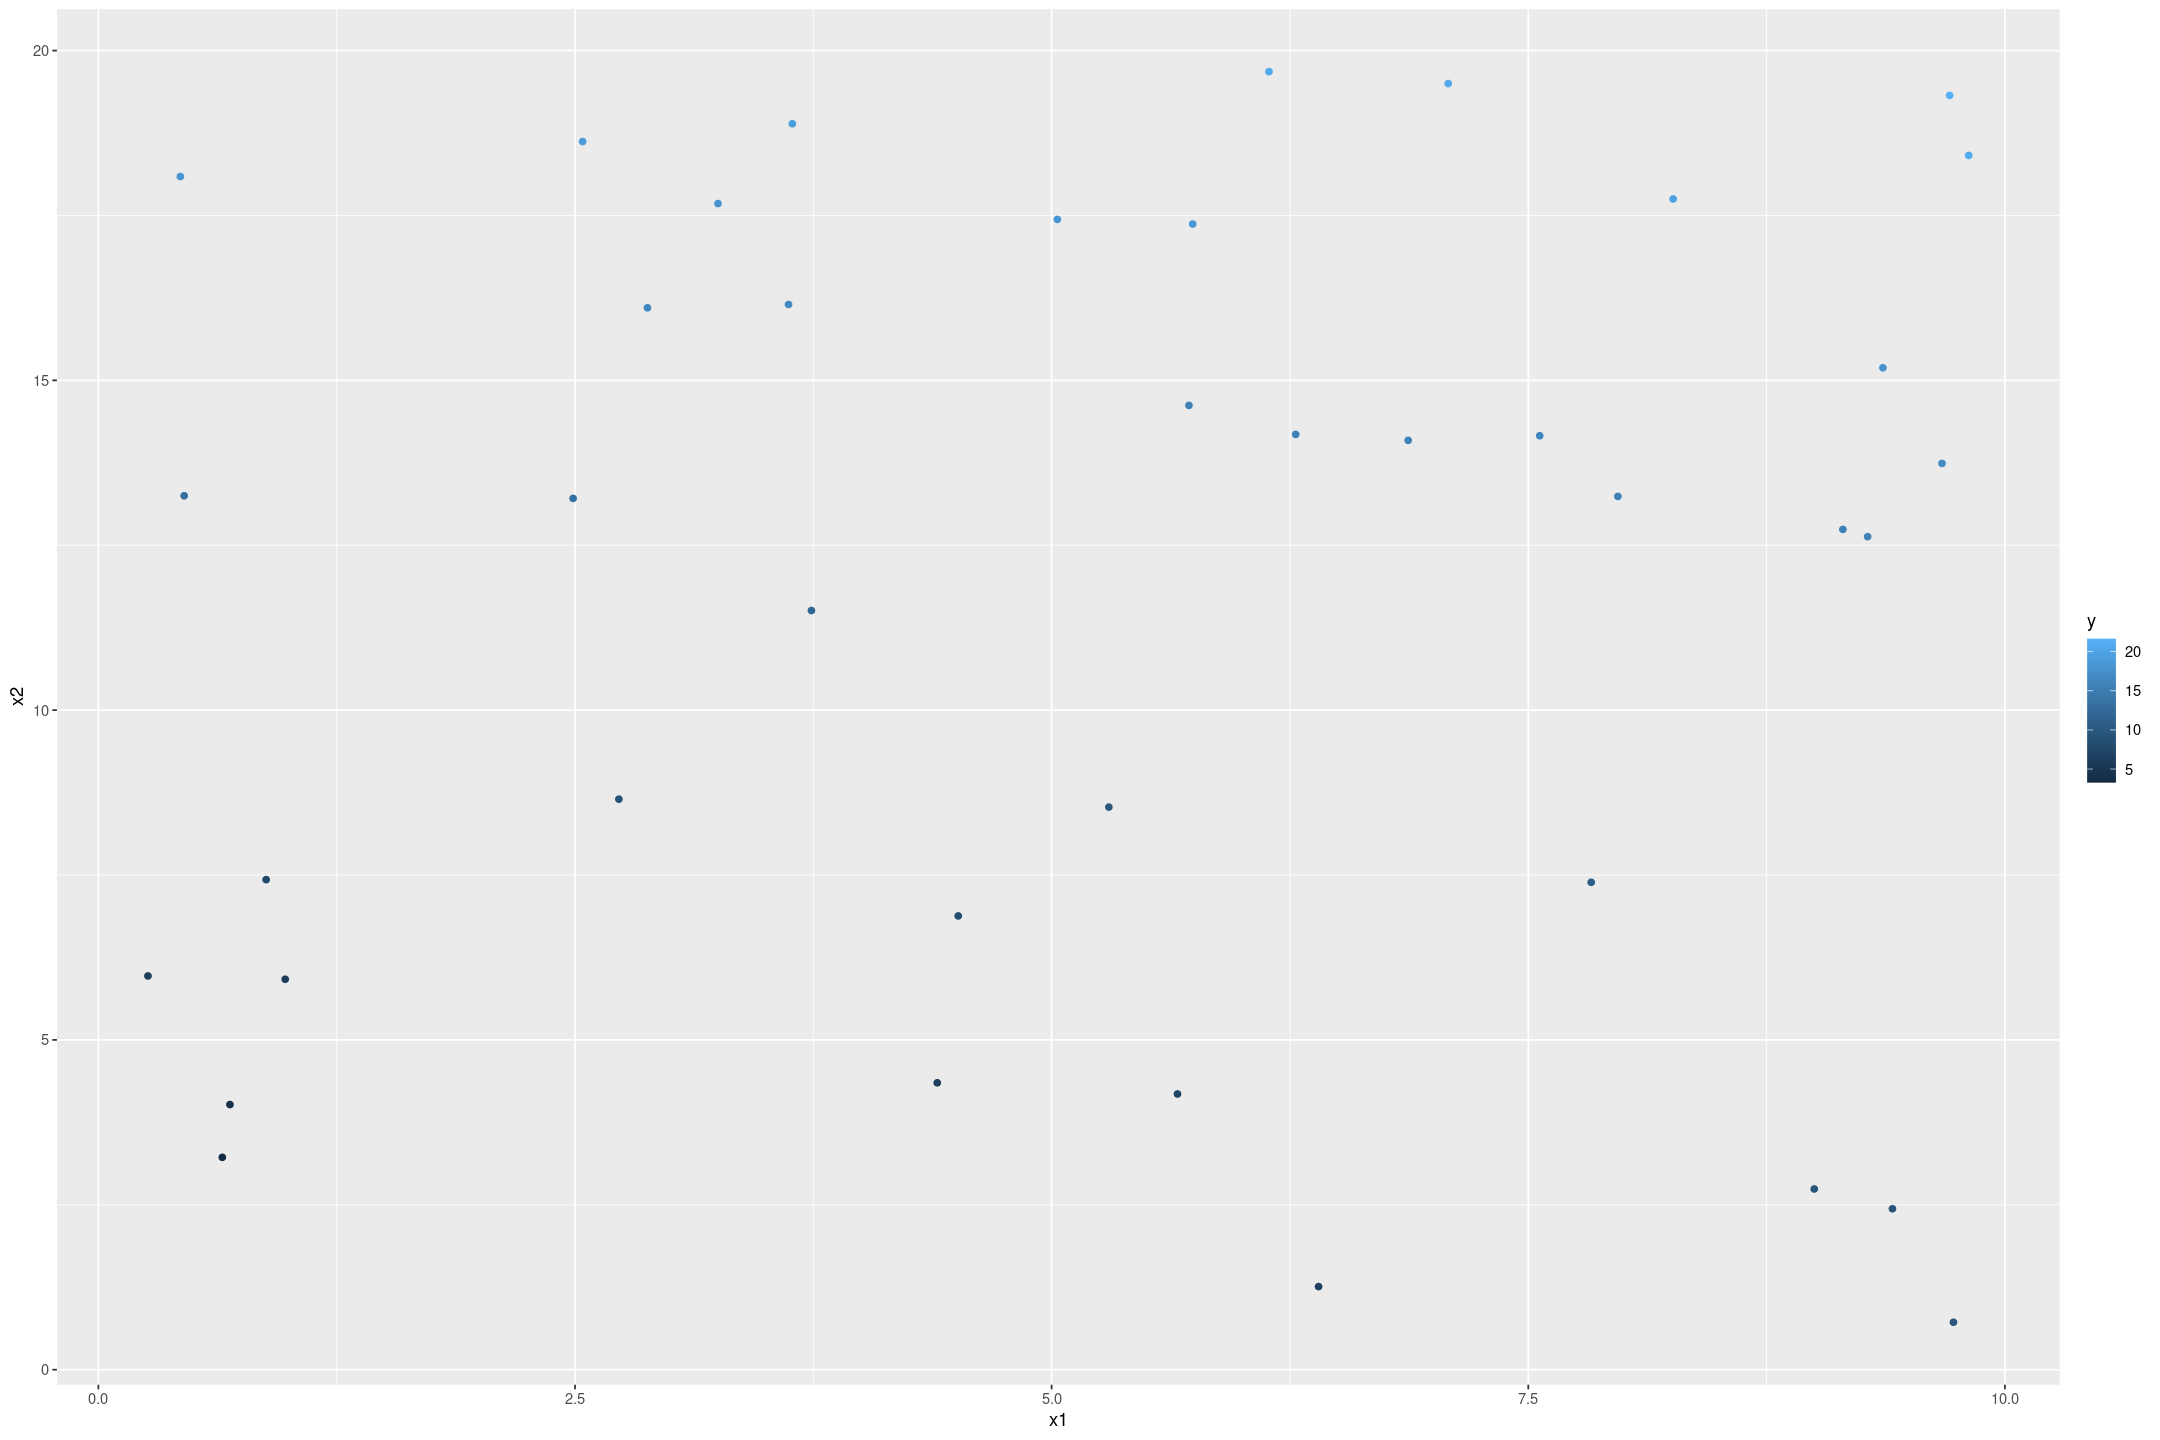

In [46]:
pyth_sample %>%
gf_point(x2 ~ x1, col=~y)

The model says:

* At 0,0 the value is ~1.3
* A point with 1 higher x_1 will, on average, have 0.5 higher y
* A point with 1 higher x_2 will, on average, have 0.8 higher y

The standard error $\sigma$ is about 1.

In [47]:
pyth_model <- stan_glm(y ~ x1 + x2, data=pyth_sample, refresh=0)
pyth_model

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x1 + x2
 observations: 40
 predictors:   3
------
            Median MAD_SD
(Intercept) 1.3    0.4   
x1          0.5    0.0   
x2          0.8    0.0   

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.9    0.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

## Graphing model

Display the estimated model graphically as in Figure 11.2

In [48]:
pyth_sample <-
pyth_sample %>%
add_predictions(pyth_model) %>%
add_residuals(pyth_model)

x1_slope <- coef(pyth_model)[['x1']]
x2_slope <- coef(pyth_model)[['x2']]
intercept <- coef(pyth_model)[['(Intercept)']]

Looking at x1 for average values of x2.

The regression line looks reasonable.

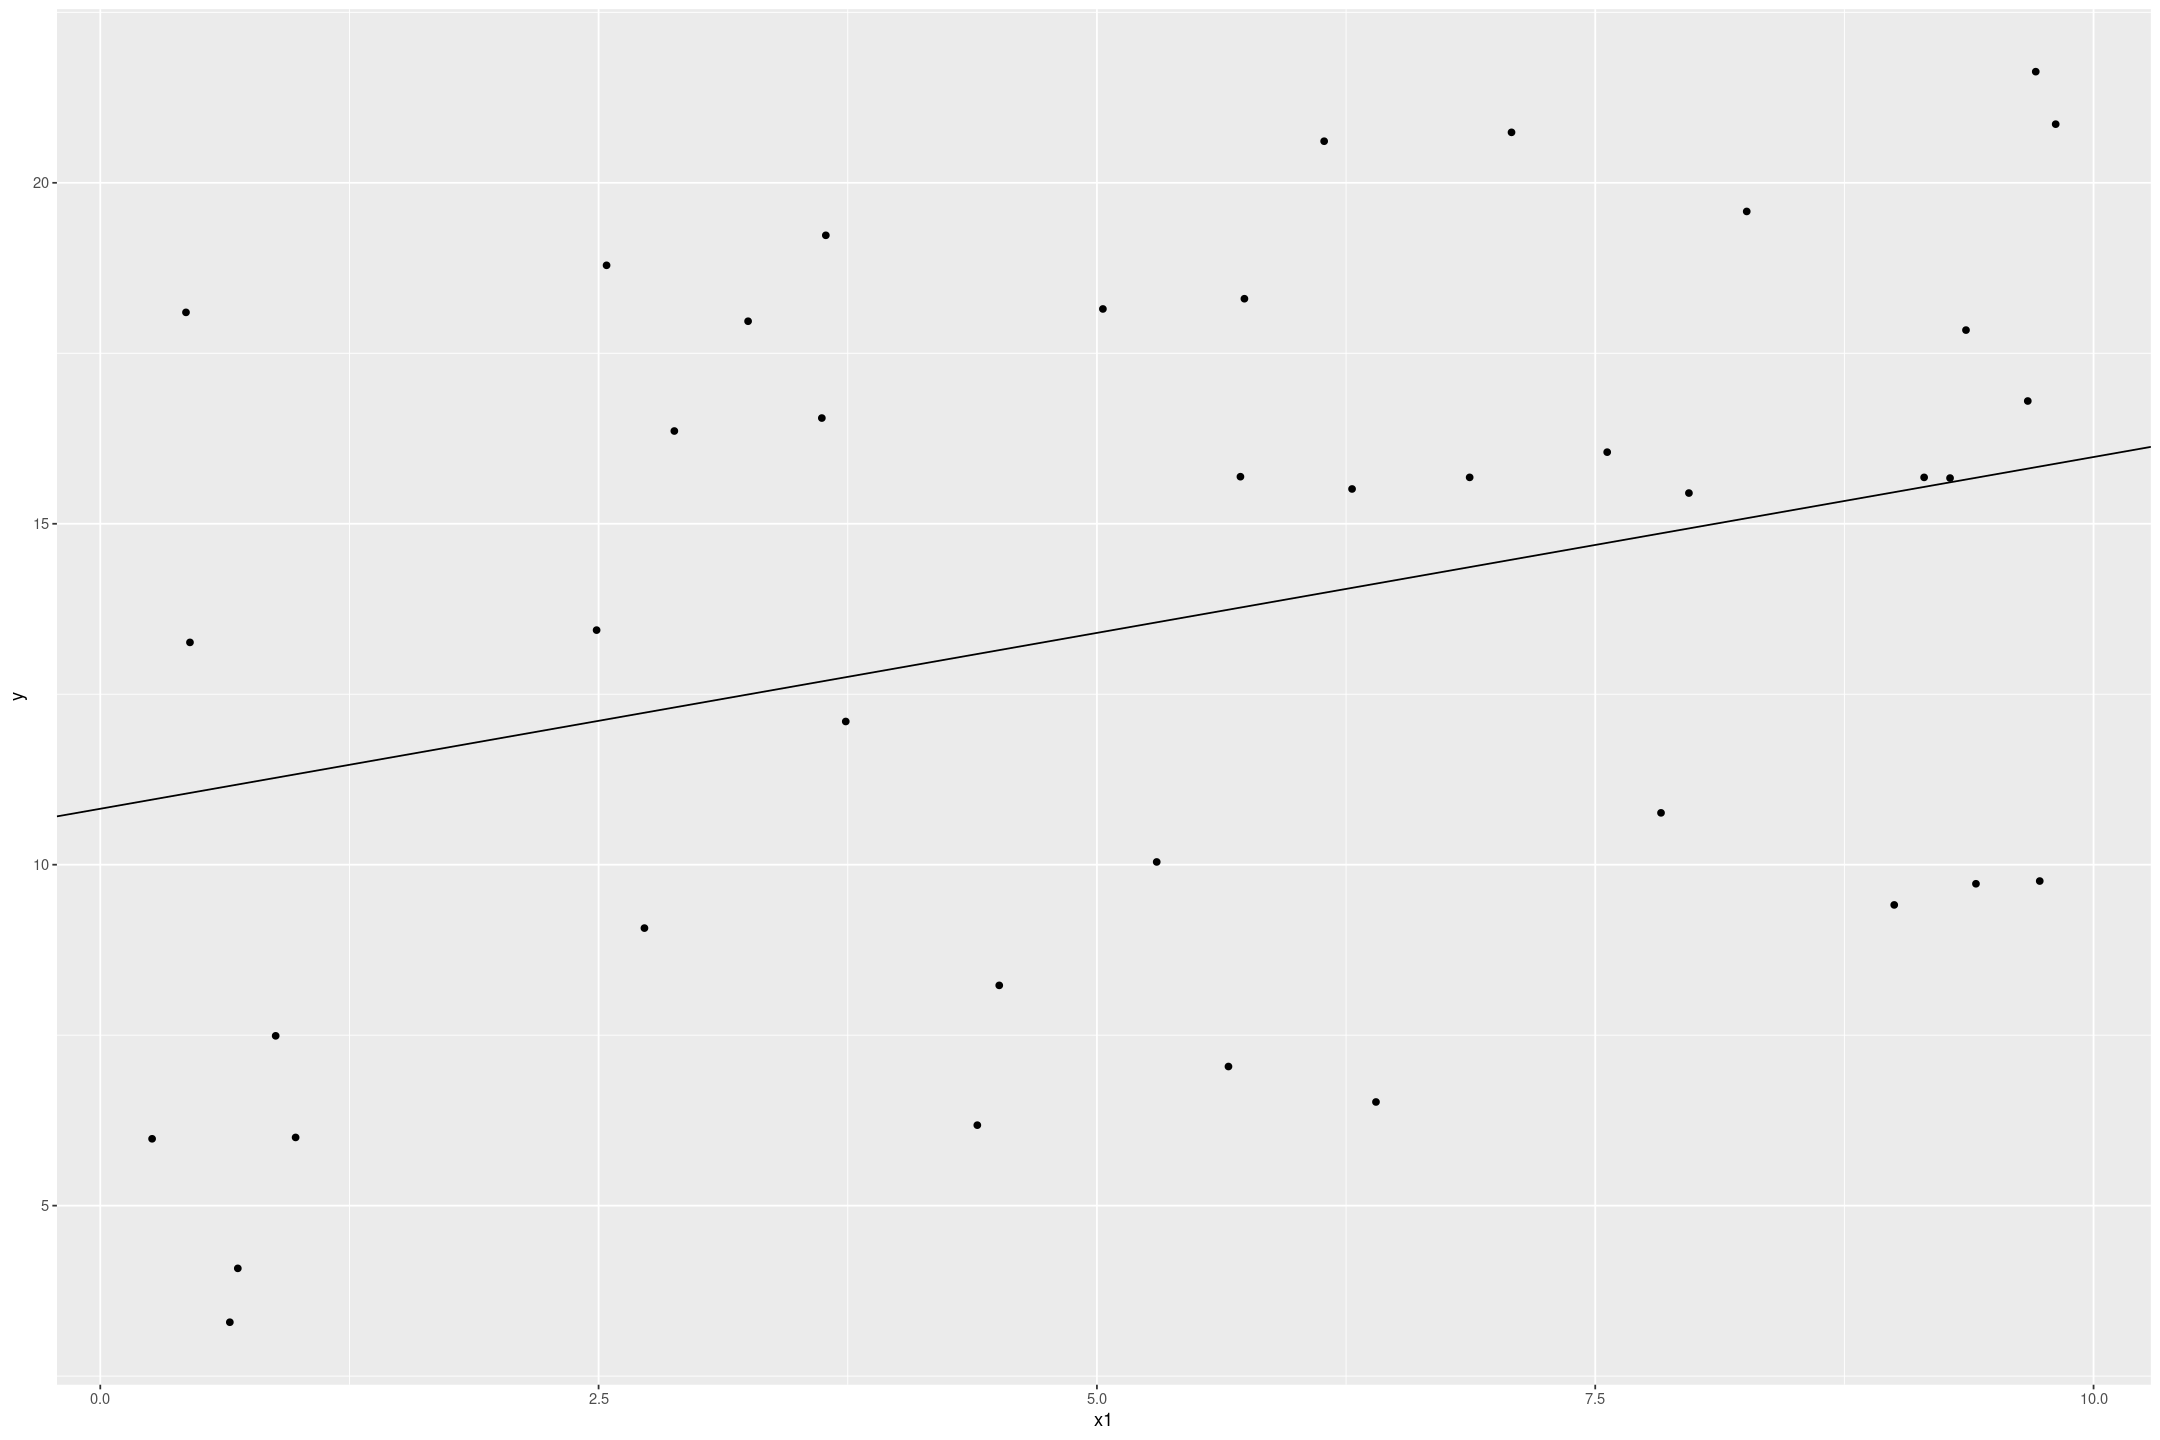

In [49]:
pyth_sample %>%
gf_point(y ~ x1) %>%
gf_abline(intercept=~intercept + mean(x2) * x2_slope, slope=~x1_slope)

Looking at x2 for average values of x1.
The regression line looks quite good.

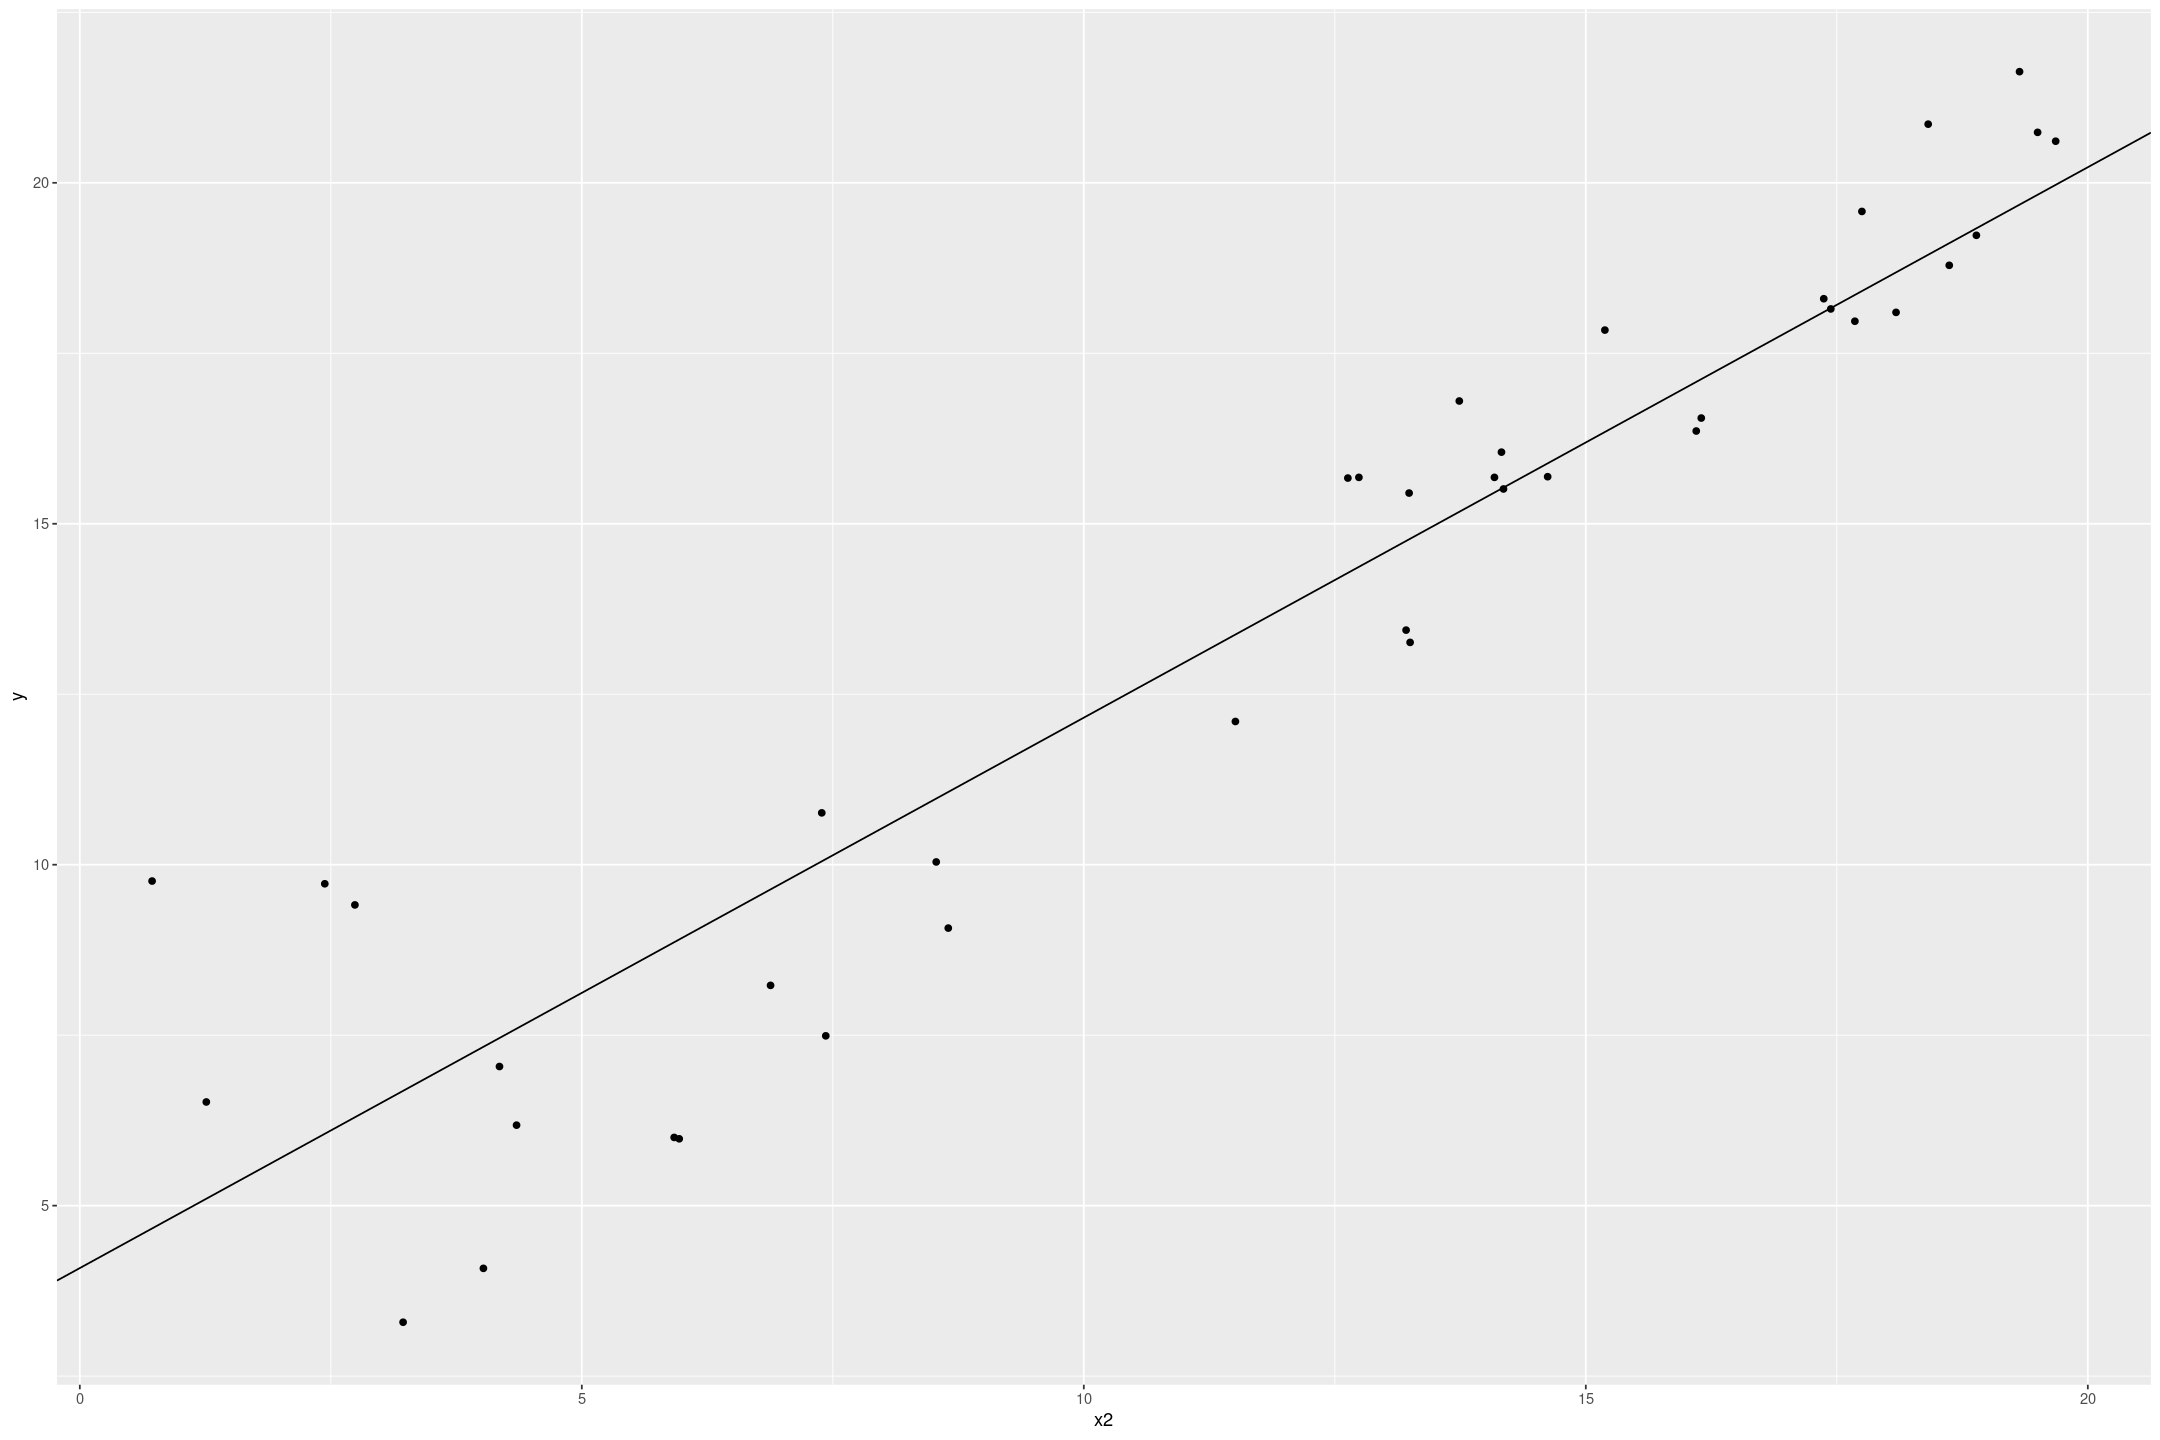

In [50]:
pyth_sample %>%
gf_point(y ~ x2) %>%
gf_abline(intercept=~intercept + mean(x1) * x1_slope, slope=~x2_slope)

## Assumptions

Make a residual plot for this model.
Do the assumptions appear to be met?

The residuals do not look to have equal variance and be normally distributed. 
It looks like they are higher in the positive direction, and that their variance decreases with increasing predicted value.

These assumptions do not appear to be met, which has impacts on the predictions.

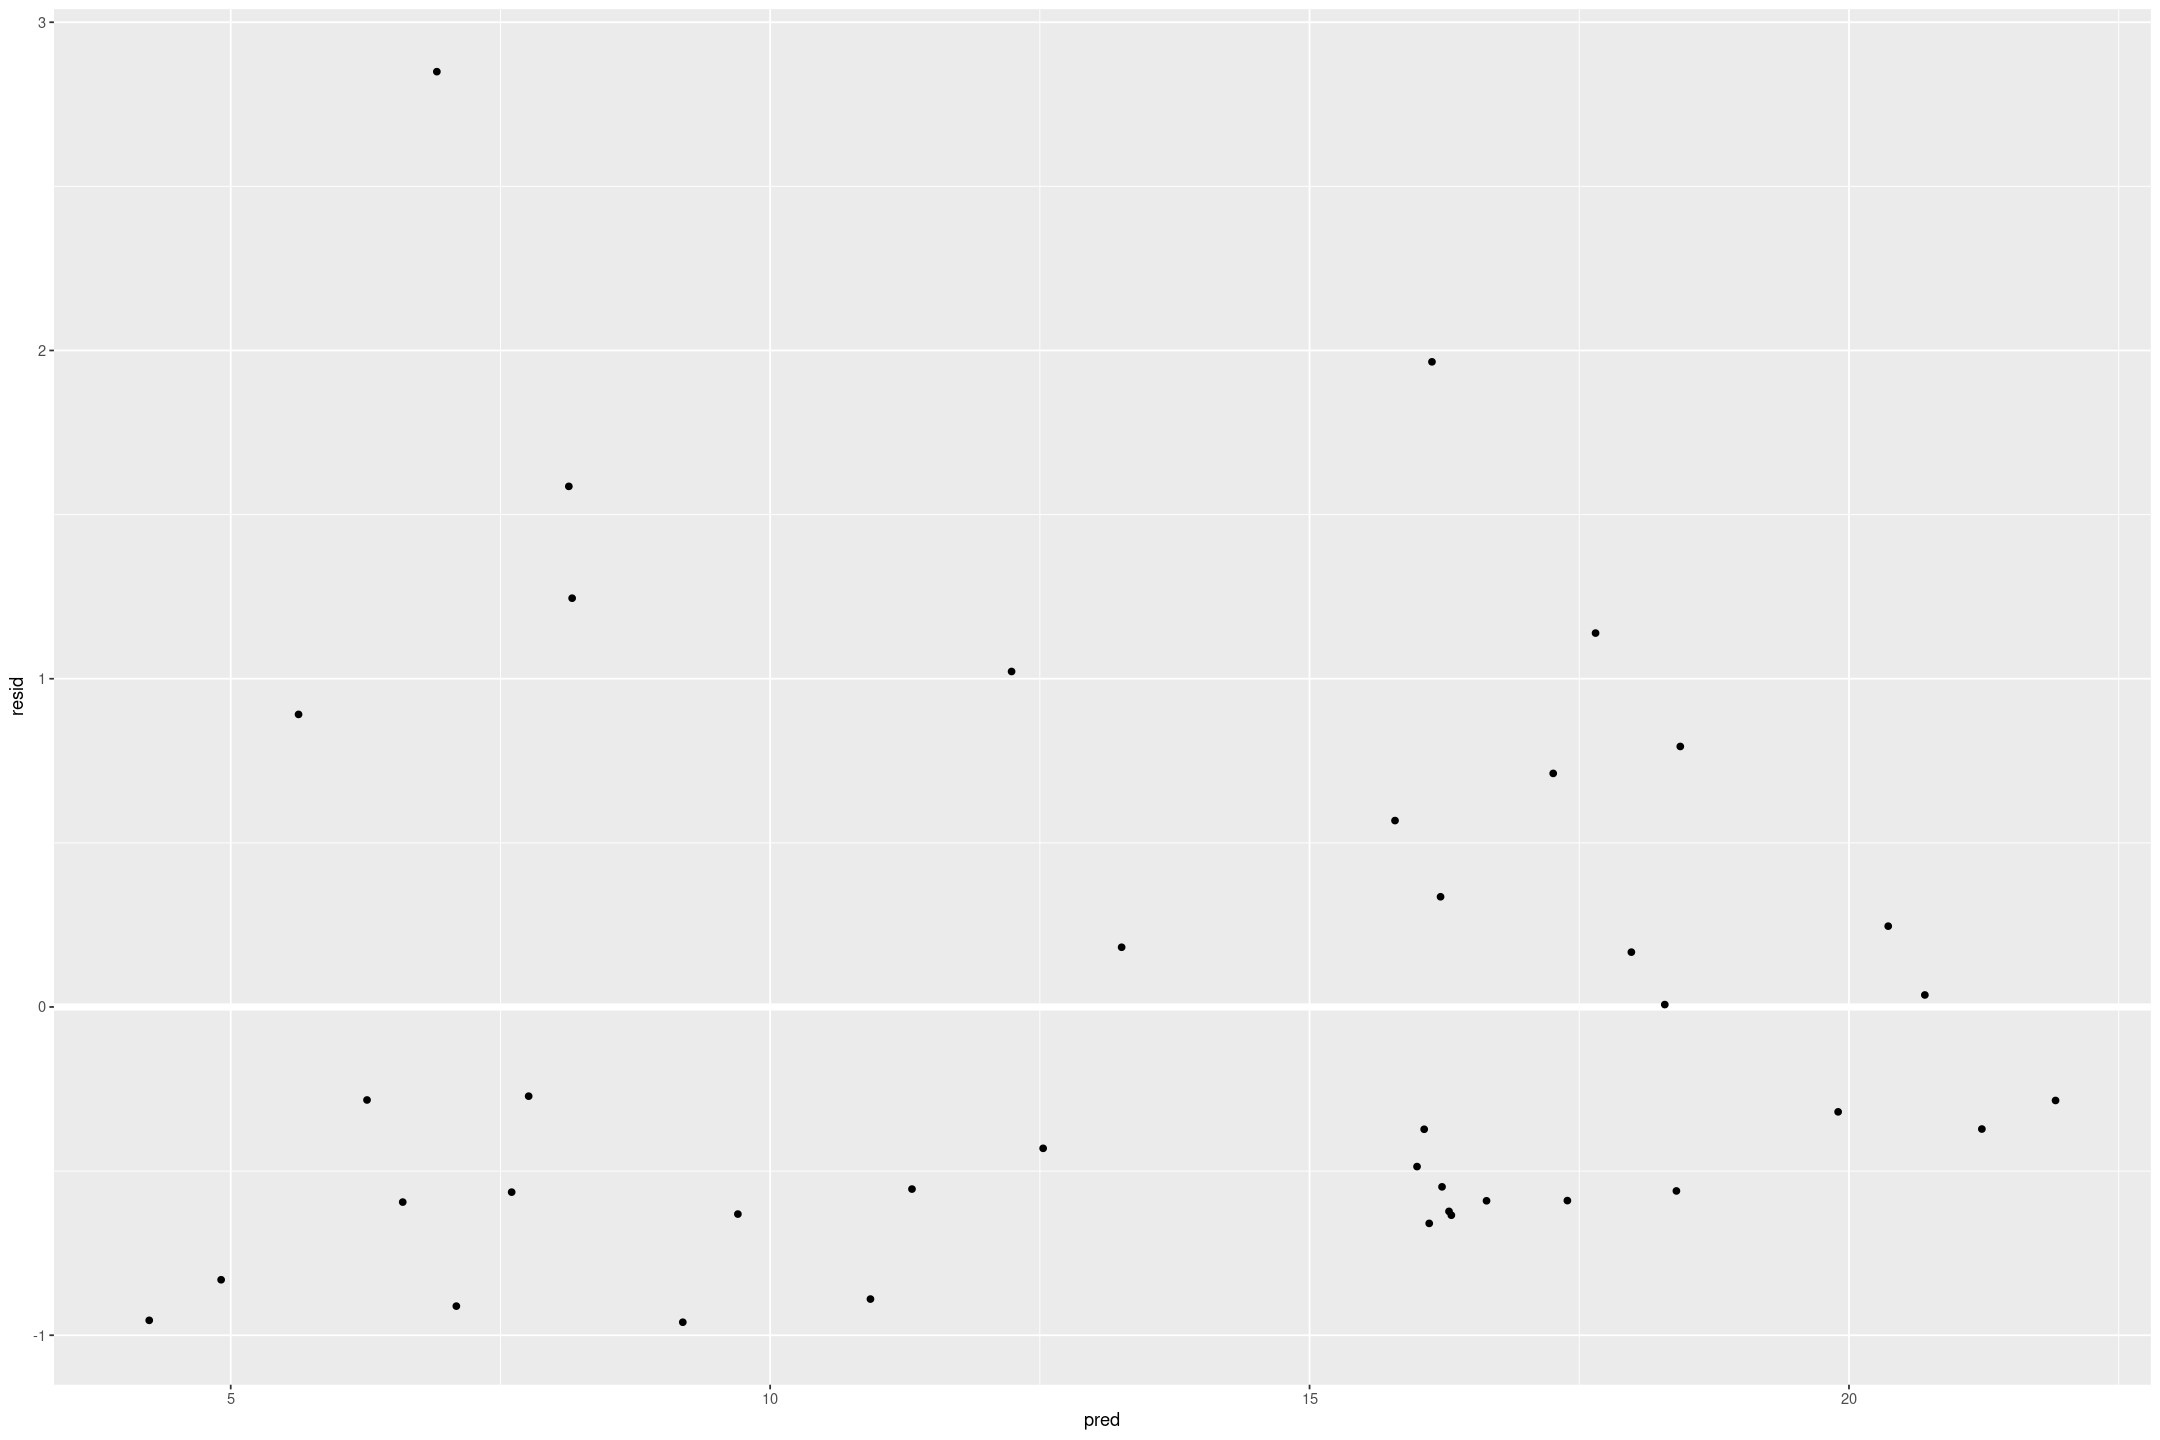

In [51]:
pyth_sample %>%
add_residuals(pyth_model) %>%
add_predictions(pyth_model) %>%
gf_hline(yintercept=~0, colour="white", size=2) %>%
gf_point(resid ~ pred)

A histogram makes the non-normality clearer.

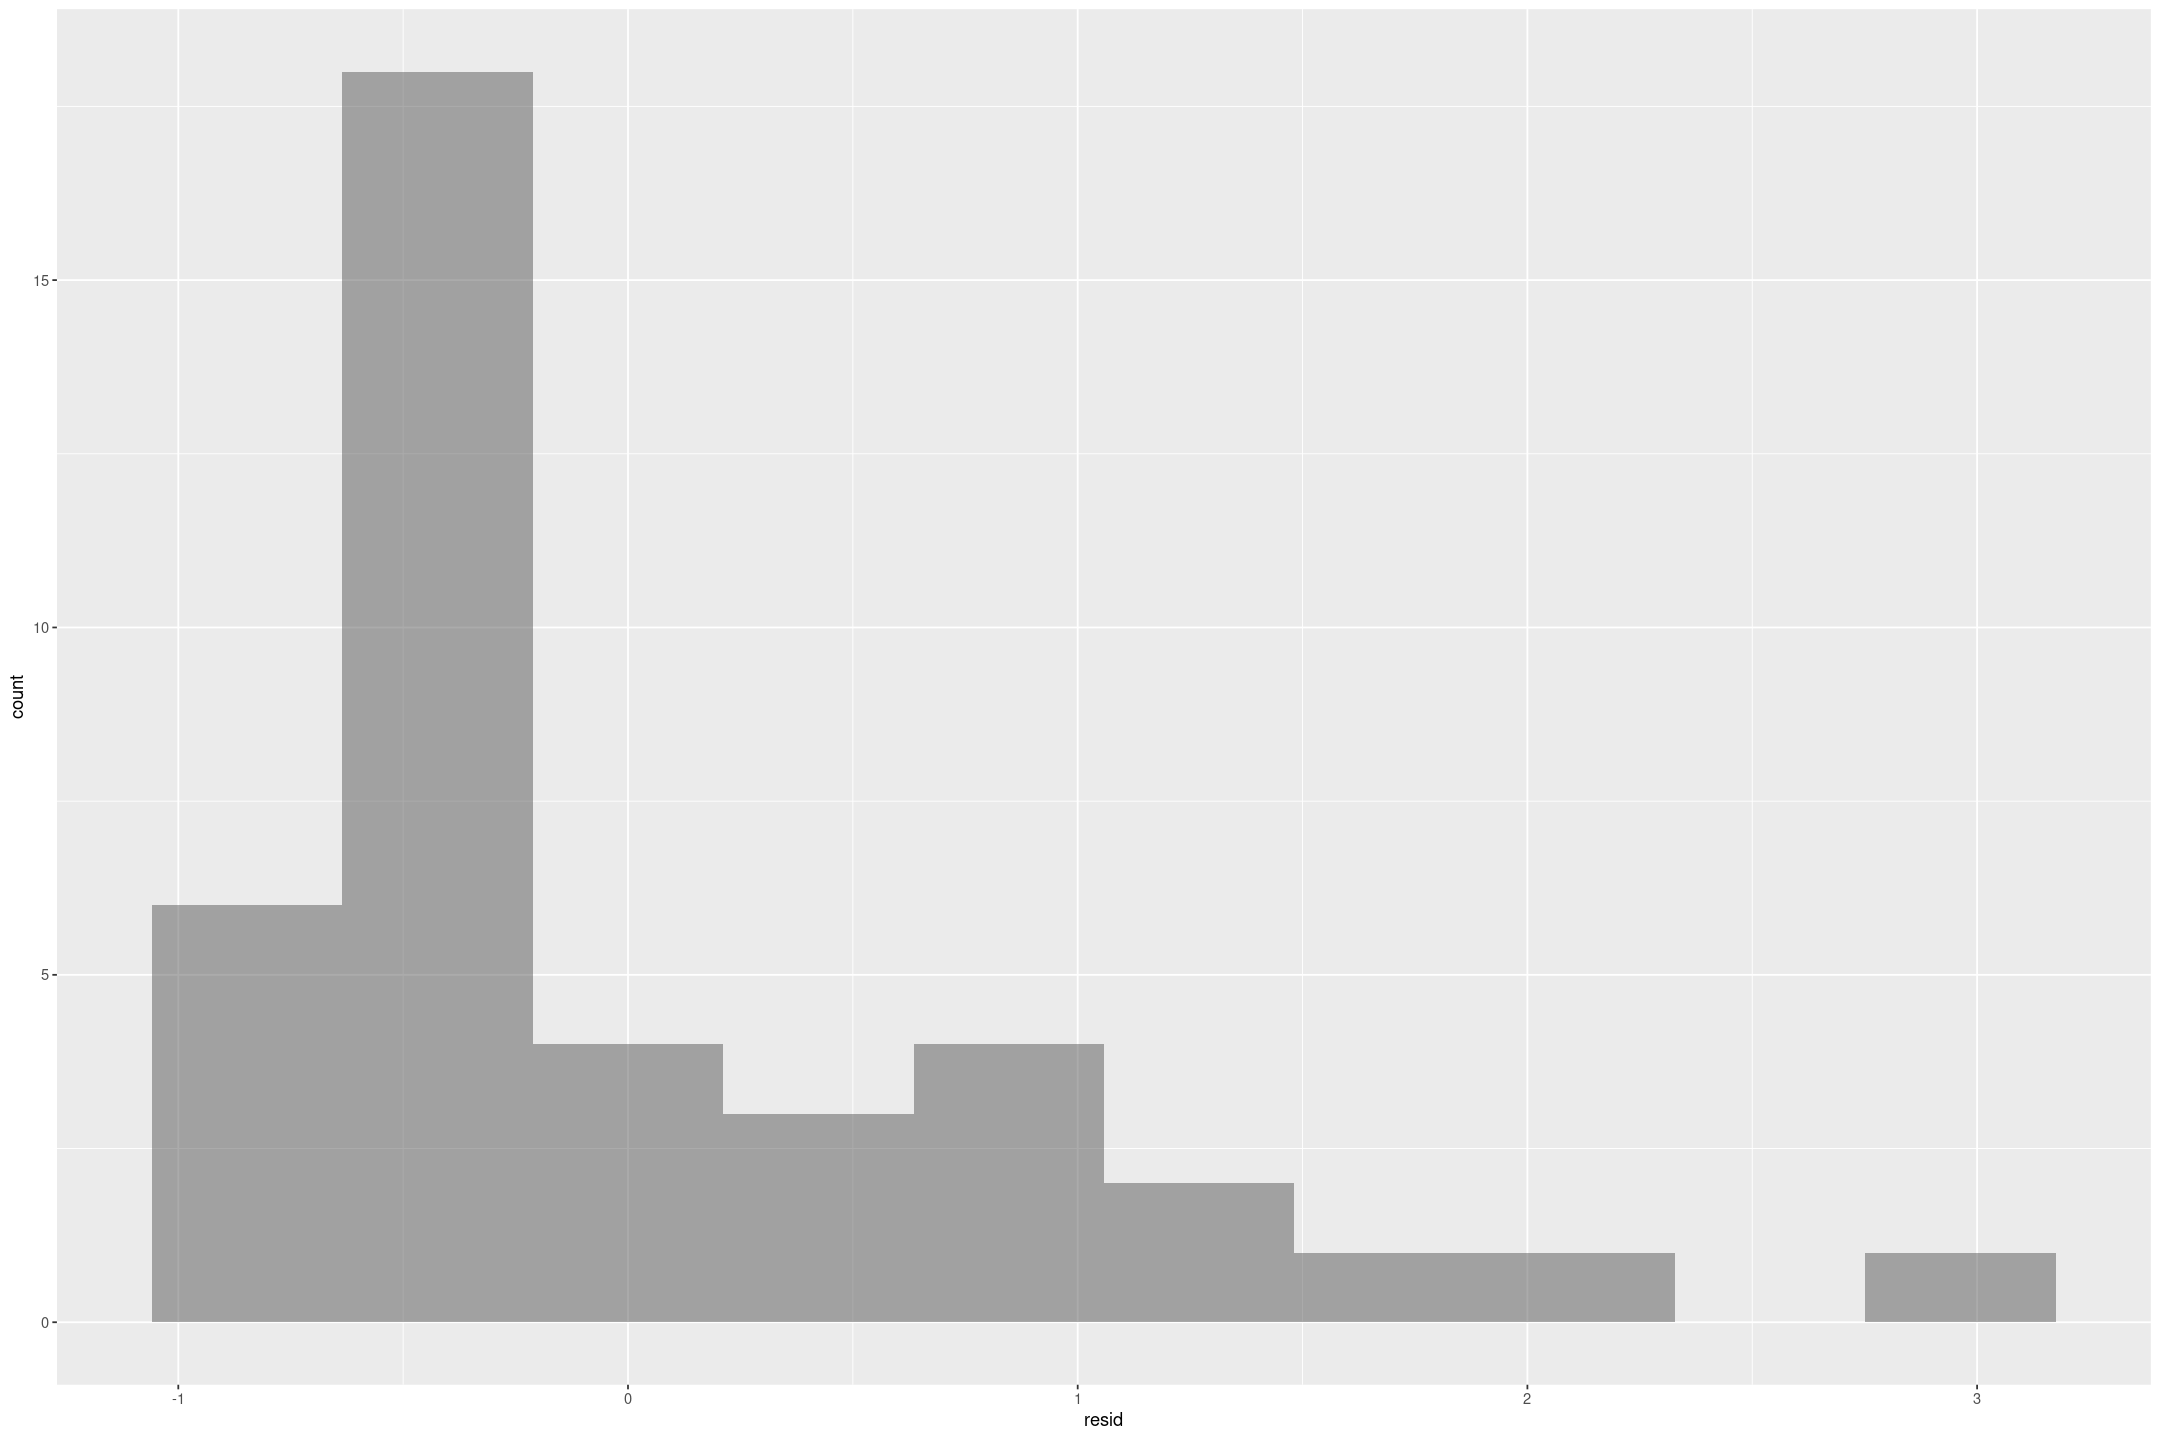

In [52]:
pyth_sample %>%
gf_histogram(~resid, bins=10)

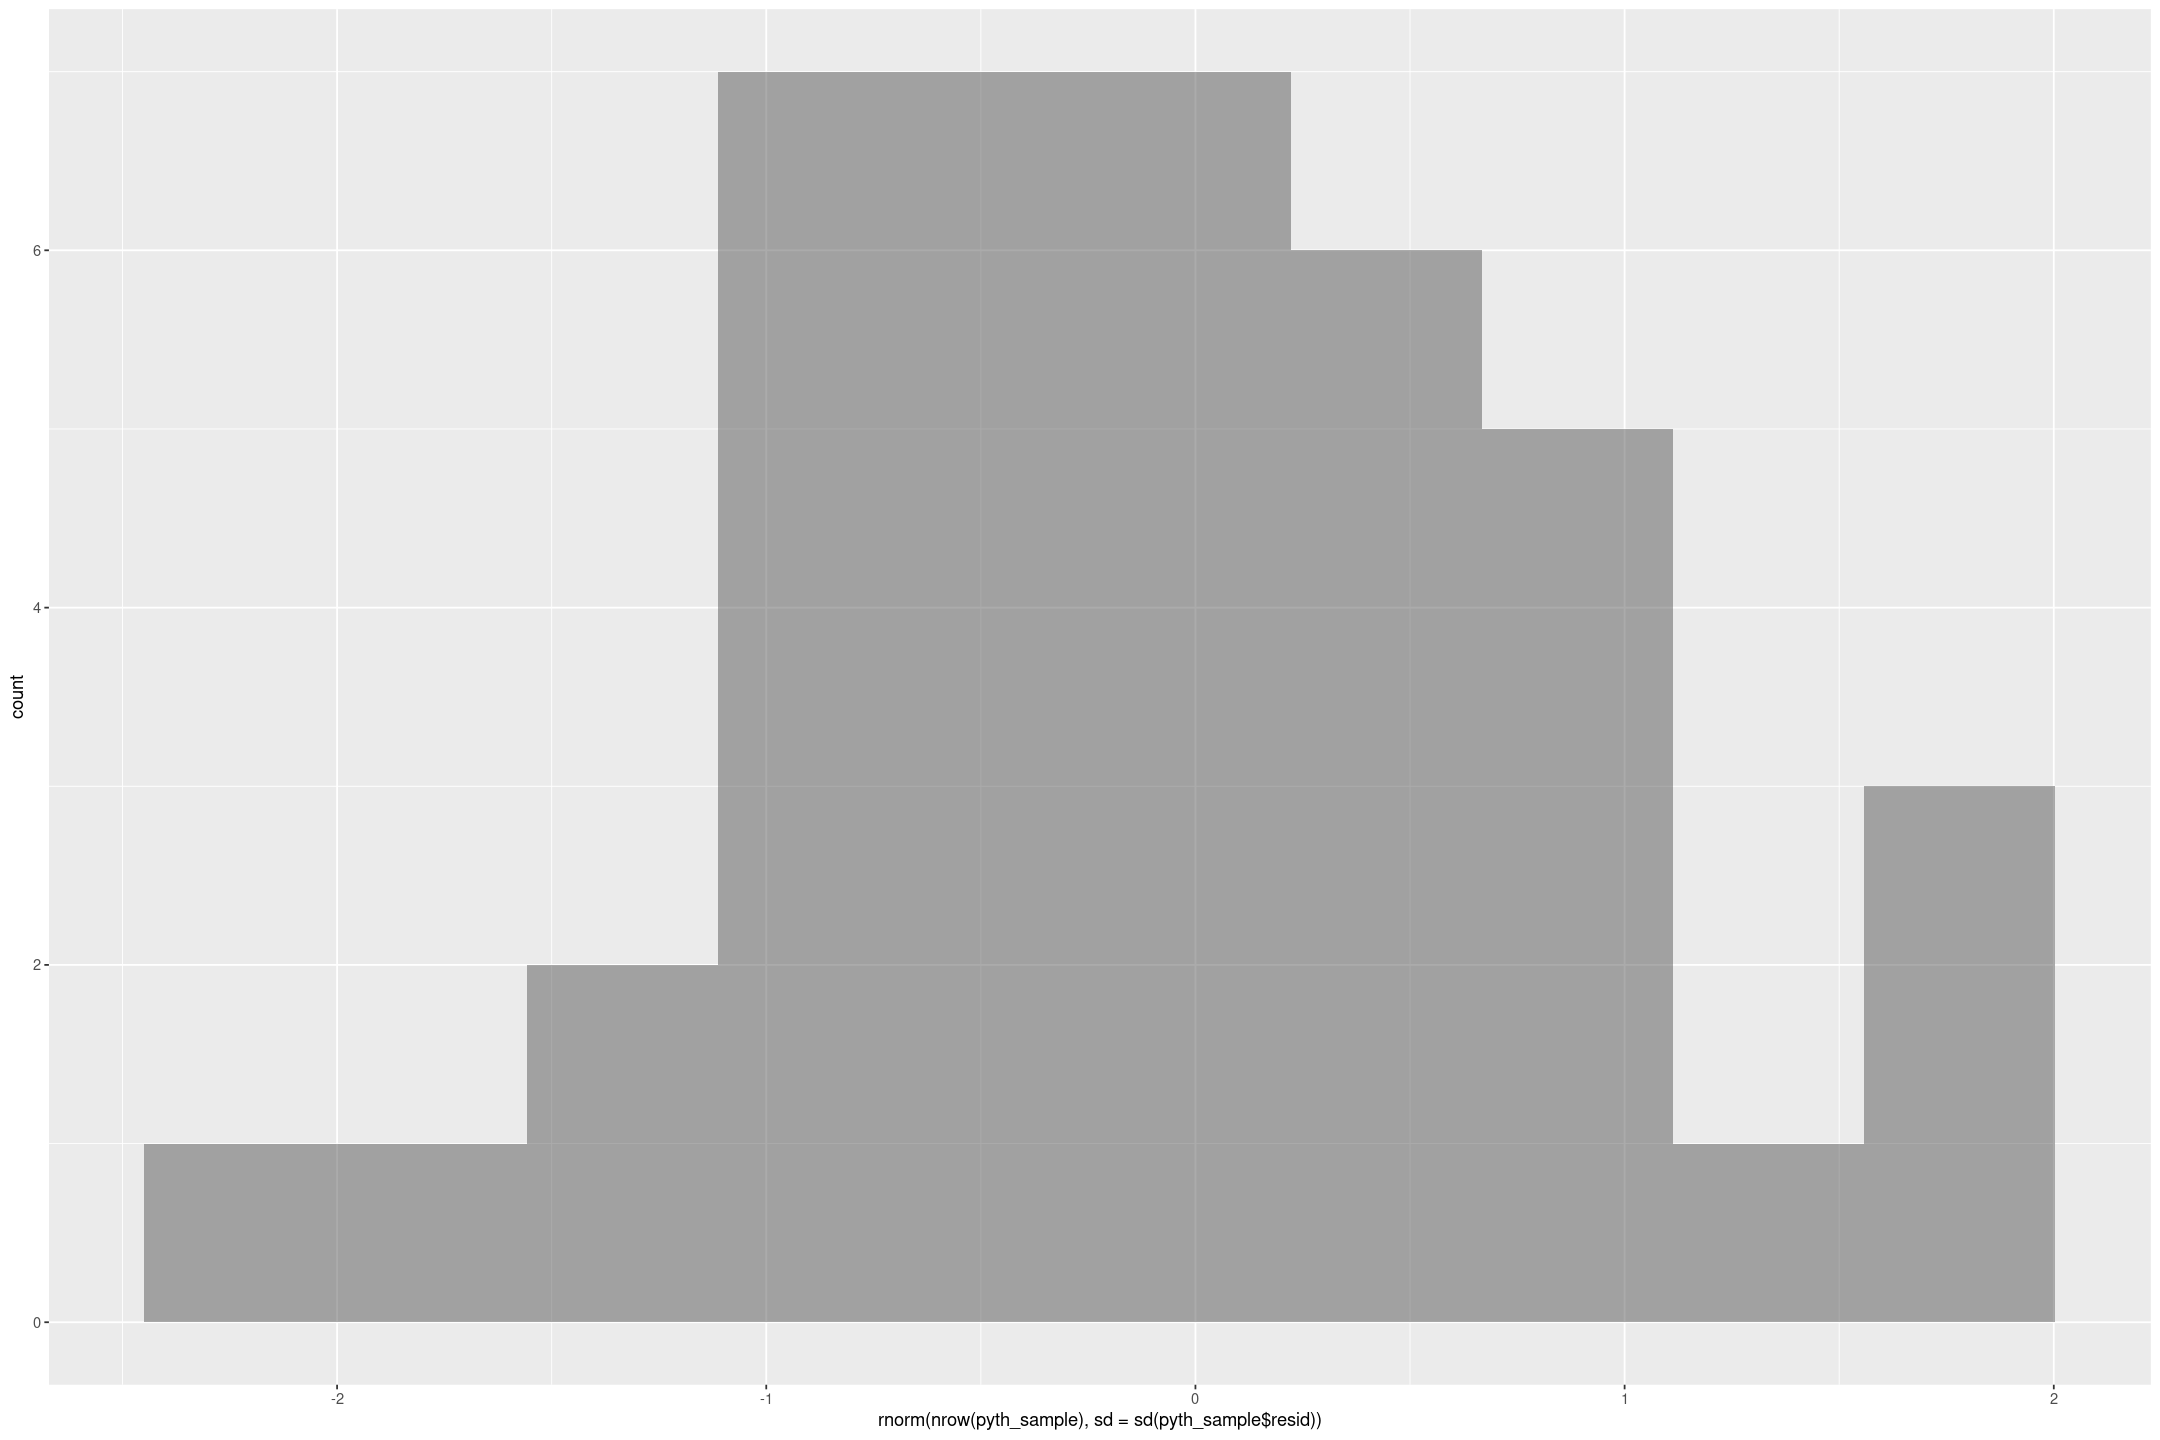

In [53]:
gf_histogram(~rnorm(nrow(pyth_sample), sd=sd(pyth_sample$resid)), bins=10)

In [54]:
sd(pyth_sample$resid)

[1] 0.8766608

Let's to a test on the smallest value

In [55]:
test_min_val <- function() {
    min(pyth_sample$resid) < min(rnorm(nrow(pyth_sample), sd=sd(pyth_sample$resid)))
}

Only 0.3% of the time is the lowest value of a normal distribution below the lowest value of the residuals.

In [56]:
mean(replicate(1000, test_min_val()))

[1] 0.003

## Assumptions

Make predictions for the remaining 20 data points in the file.
How confident do you feel about these predictions?

In [57]:
pyth_test <- tail(pyth, 20)
pyth_test$pred <- predict(pyth_model, newdata=pyth_test)

The last 20 points are mostly within the range of the sample data (first 40 points)

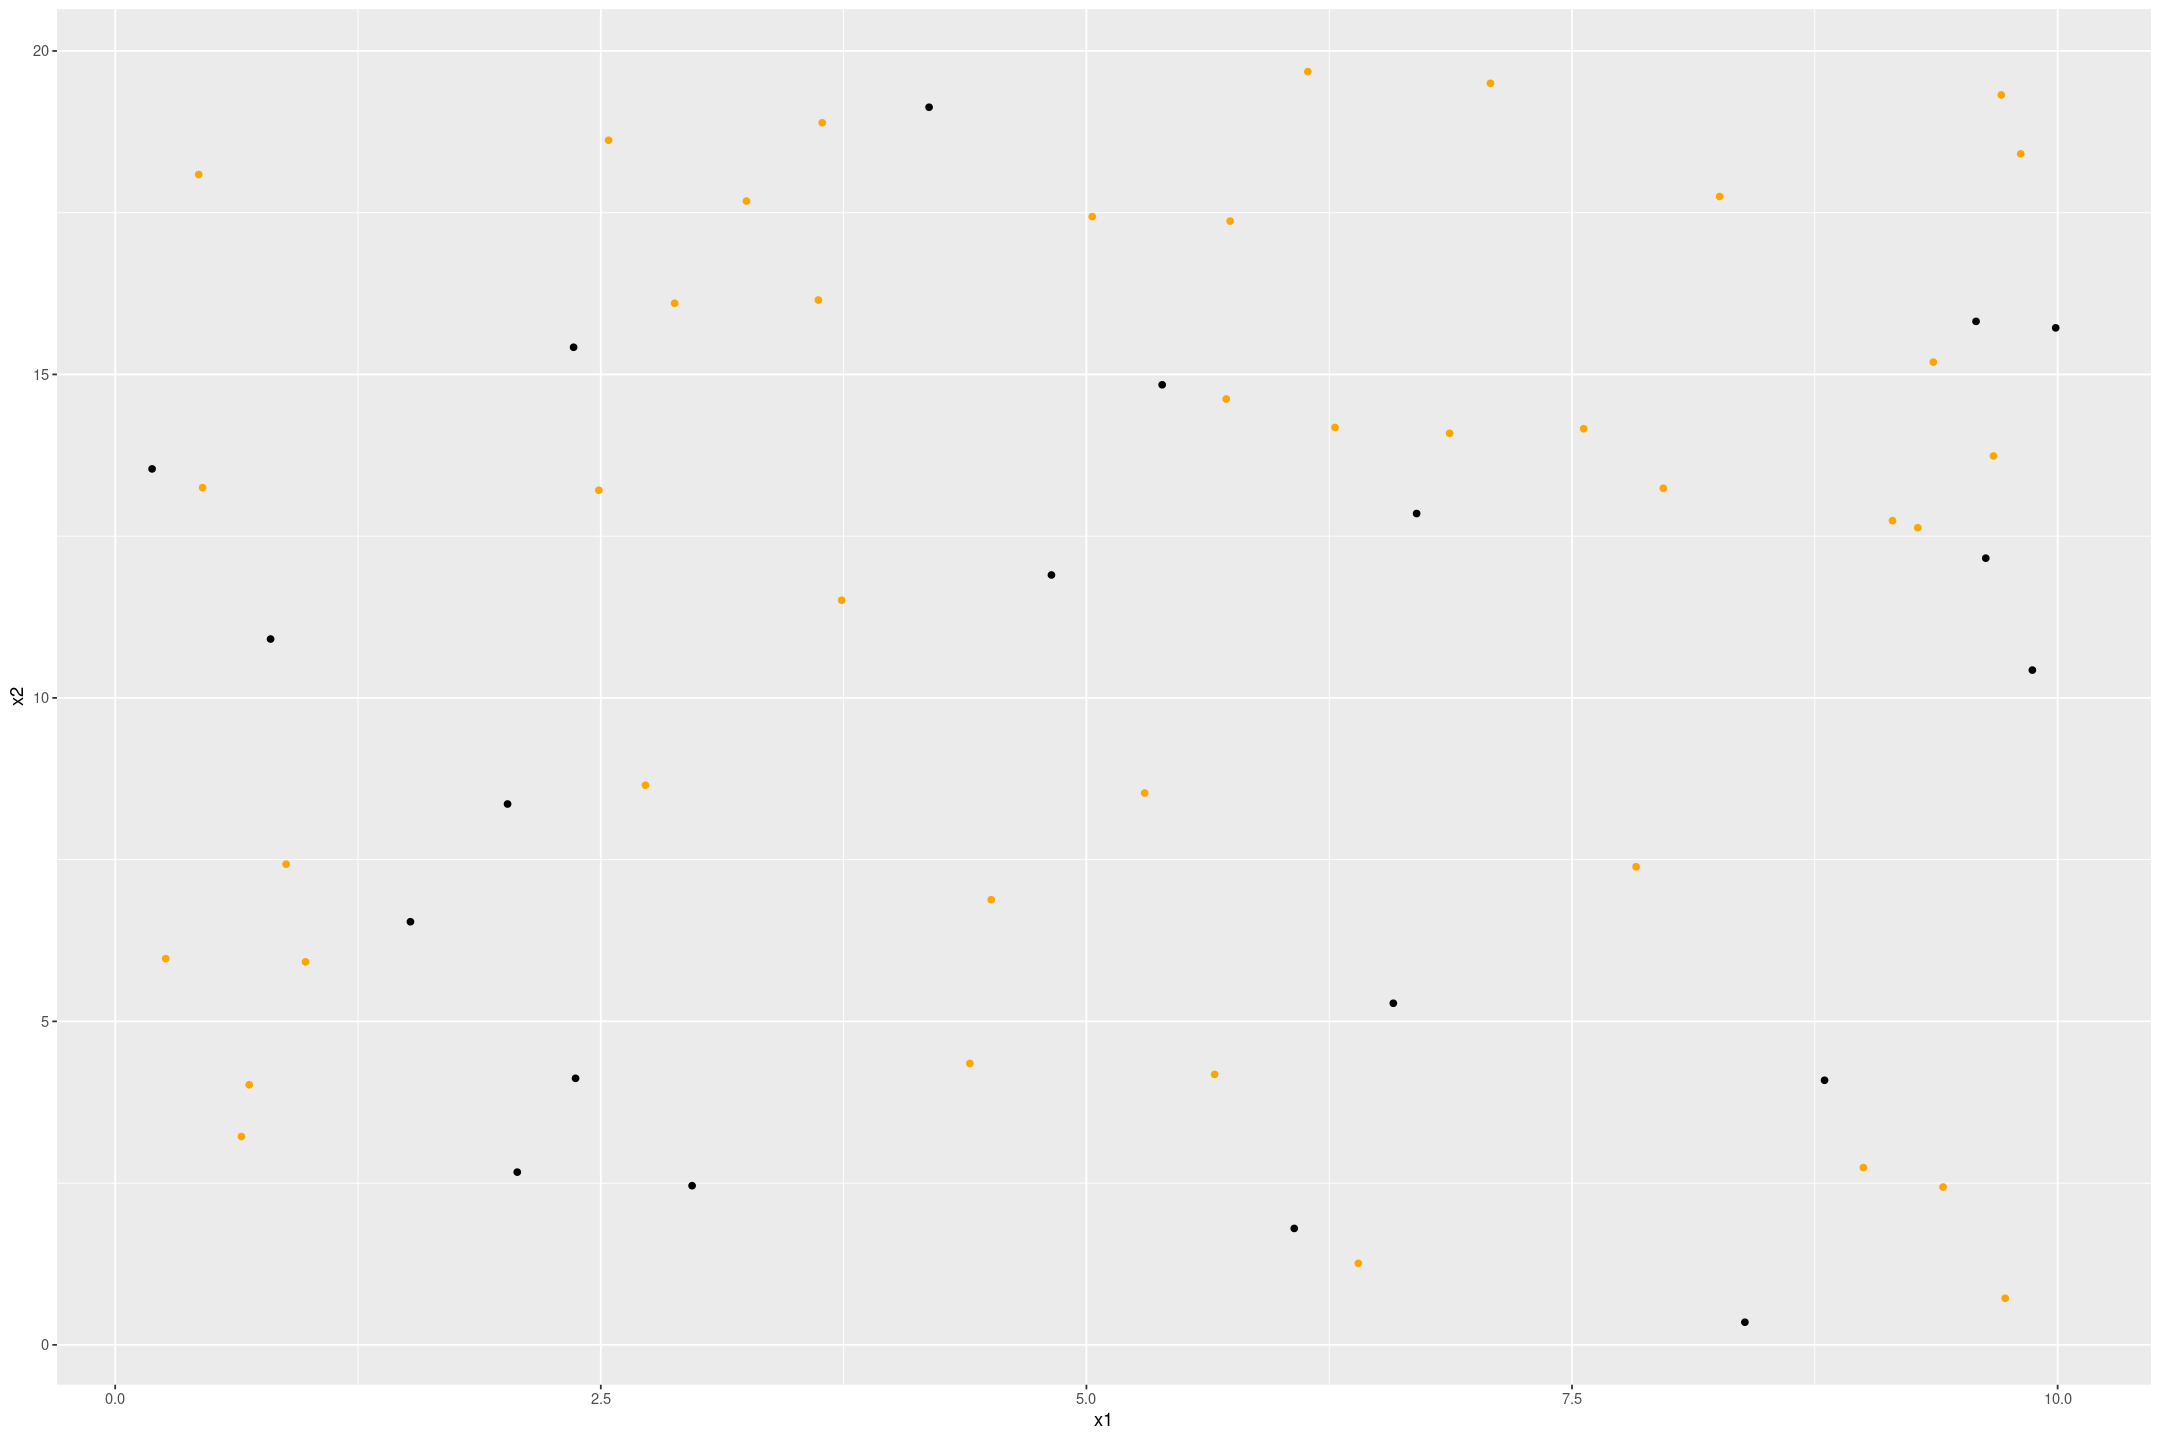

In [58]:
pyth_test %>%
gf_point(x2 ~ x1) %>%
gf_point(x2 ~ x1, data=pyth_sample, col="orange") 

I have reasonable confidence the predictions are in the right ballpark, but in general it's more likely to further undershoot, and the variation will be larger at smaller predictions.

I wonder if a transformation of the model (log?) would give better results.

## Data source

After doing this exercise, take a look at [Gelman and Nolan](http://www.stat.columbia.edu/~gelman/bag-of-tricks/) (2017, section 10.4) to see where these data came from.

On [Google Books](https://books.google.com.au/books?id=FpfJDgAAQBAJ&pg=PA160#v=onepage&q&f=false)

```
x1 <- runif(20, 0, 10)
x2 <- runif(20, 0, 20)
y <- sqrt(x1^2 + x2^2)
```

In [59]:
pyth_test <- pyth_test %>%
mutate(y = sqrt(x1^2 + x2^2)) %>%
mutate(resid=y - pred)

In [60]:
mean(pyth_test$resid)

[1] -0.1055556

In [61]:
sd(pyth_test$resid)

[1] 0.8957658

Again it's not not terrible - but it could get much worse outside of the range.

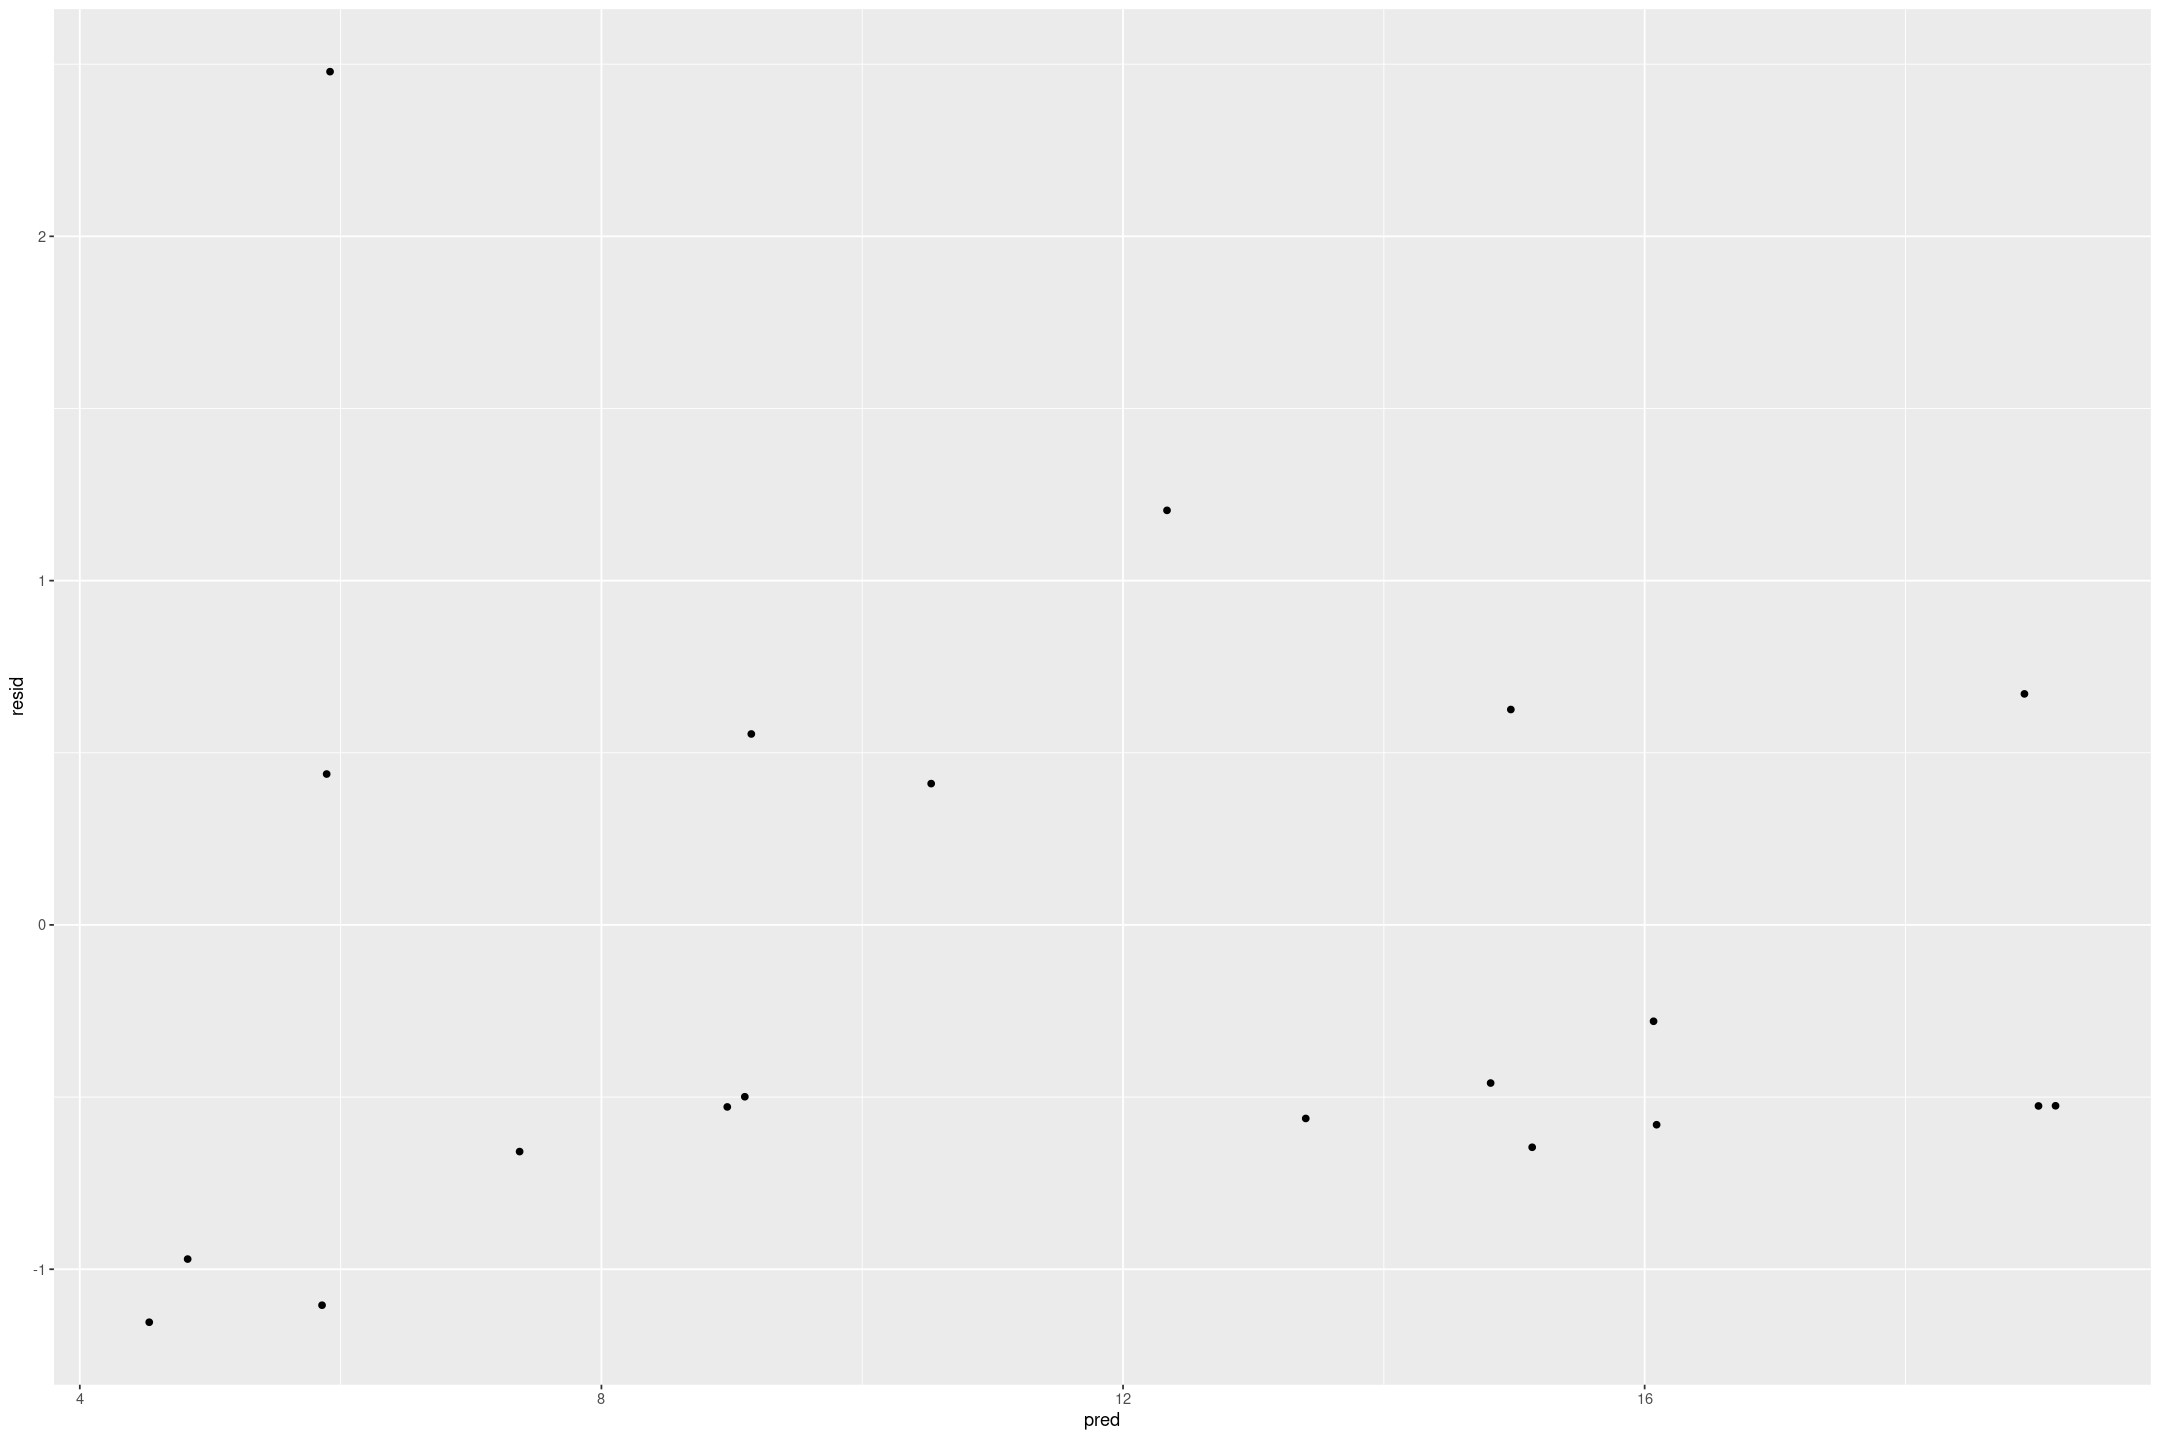

In [62]:
pyth_test %>% gf_point(resid ~ pred)

In [63]:
sqrt(125)

[1] 11.18034

In [64]:
125/25

[1] 5

In [65]:
2 /sqrt(5)

[1] 0.8944272

Essentially we're making a linear approximation of 

$$y = \sqrt{x_1^2 + x_2^2} $$

about (5,10) +/- (5,10).

Doing a Taylor expansion gives:

$$ y \approx \sqrt{125} + \frac{1}{\sqrt{5}}(x_1-5) + \frac{2}{\sqrt{5}}(x_2-10) + \rm{O}\left((x_1-5)^2, (x_2-10)^2\right) $$

Simplifying this gives:

$$ y \approx 0.45 x_1 + 0.89 x_2 $$

This isn't miles off of our model (which is different due to weightings and randomness):

In [66]:
pyth_model

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x1 + x2
 observations: 40
 predictors:   3
------
            Median MAD_SD
(Intercept) 1.3    0.4   
x1          0.5    0.0   
x2          0.8    0.0   

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.9    0.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

However this would have failed badly under extrapolation, and clearly there are much better models!

# Fitting a wrong model

Suppose you have 100 data points that arose from the following model: $ y= 3 + 0.1x_1 +0.5 x_2 + \rm{error}$, with independent errors drawn from a t distribution with mean 0, scale 5, and 4 degrees of freedom.
We shall explore the implications of fitting a standard linear regression to these data.

## Simulating

Simulate data from this model.
For simlicity, suppose the values of $x_1$ are simply the integers from 1 to 100, and that the values of $x_2$ are random and equally likely to be 0 or 1.
In R, you can define `x_1 <- 1:100`, simulate  `x_2` using `rbinom`, then create the linear predictor, and finally simulate the random errors in `y` using the `rt` function.
Fit a linear regression (with normal errors) to these data and see if the 68% confidence intervals for the regression coefficients (for each, the estimates $\pm 1 $ standard error) cover their true values.

In [67]:
n <- 100
x1 <- 1:n
x2 <- rbinom(n, 1, 0.5)
y0 <- 3 + 0.1 * x1 + 0.5 * x2
y <- y0 + 5 * rt(n, df=4)

fake_data <- data.frame(x1, x2, y0, y)

fake_model <- stan_glm(y ~ x1 + x2, data=fake_data, refresh=0)

In [68]:
model_covers <- function(model, coef_name, value, sds=1) {
    (coef(model)[[coef_name]] - sds * se(model)[[coef_name]] < value) & (coef(model)[[coef_name]] + sds * se(model)[[coef_name]] > value)
}

In [69]:
model_covers(fake_model, '(Intercept)', 3)

[1] FALSE

In [70]:
model_covers(fake_model, 'x1', 0.1)

[1] TRUE

In [71]:
model_covers(fake_model, 'x2', 0.5)

[1] TRUE

## Coverage

Put the above step in a loop and repeat 1000 times.
Calculate the confidence coverage for the 68% intervals for each of the three coefficients in the model.

In [72]:
coverage_t4 <- function() {
    n <- 100
    x1 <- 1:n
    x2 <- rbinom(n, 1, 0.5)
    y0 <- 3 + 0.1 * x1 + 0.5 * x2
    y <- y0 + 5 * rt(n, df=4)

    fake_data <- data.frame(x1, x2, y0, y)

    fake_model <- stan_glm(y ~ x1 + x2, data=fake_data, refresh=0)
    
    c('intercept'=model_covers(fake_model, '(Intercept)', 3), 
      'x1'=model_covers(fake_model, 'x1', 0.1), 
      'x2'=model_covers(fake_model, 'x2', 0.5))
    
}

In [73]:
start_time <- Sys.time()
coverage_t4_samples <- replicate(1000, coverage_t4())
Sys.time() - start_time

Time difference of 5.175658 mins

The coverages are still pretty close to 68%.
Is the takeaway here that the error distribution doesn't matter too much?

In [74]:
coverage_t4_samples %>% apply(1, mean)

intercept        x1        x2 
    0.678     0.651     0.672

# Correlation and explained variance

In a least squares regression with one predictor, show that $R^2$ equals the square of the correlation between $x$ and $y$.

Start with the classic definition:

$$ R^2 = 1 - \left(\hat{\sigma}^2 / s_y^2 \right) $$

And the estimate of the residual standard deviation for single variable regression (equation 8.5)

$$ \hat{\sigma} = \sqrt{\frac{1}{n-2}\sum_{i=1}^{n} \left(y_i - (\hat{a} + \hat{b}x_i)\right)^2} $$

We can further substitue in the least squares estimates of the coefficients (equations 8.3 and 8.4)

$$ \hat{a} = \bar{y} - \hat{b} \bar{x} $$


$$ \hat{b} = \frac{\sum_{i=1}^{n} (x_i - \bar{x}) y_i}{\sum_{i=1}^{n}(x_i - \bar{x})^2} = \rho(x, y) \frac{\sigma_y}{\sigma_x}$$

So

$$ \begin{align}
(n-2)\hat{\sigma}^2 &= \sum_{i=1}^{n} \left(y_i - (\bar{y} - \hat{b} \bar{x} + \hat{b} x_i)\right)^2 \\
                    &= \sum_{i=1}^{n} \left(y_i - \bar{y} - \hat{b} (x_i - \bar{x})\right)^2 \\
                    &= \sum_{i=1}^{n} (y_i - \bar{y})^2 - 2 \hat{b} (y_i - \bar{y}) (x_i - \bar{x}) + \hat{b}^2 (x_i - \bar{x}) ^2 \\
                    &= n \sigma_y^2 - 2 n \hat{b} \rho(x,y) \sigma_x \sigma_y + n\hat{b}^2 \sigma_x^2\\
                    &= n \sigma_y^2 - 2 n \rho(x,y)^2 \sigma_y^2 + n \rho(x,y)^2 \sigma_y^2 \\
                    &= n \sigma_y^2 \left(1 - \rho(x,y)^2 \right)
\end{align}$$

Thus

$$ R^2 = 1 - \frac{n}{n-2}(1 - \rho(x,y)^2) = \frac{n}{n-2} \rho(x,y)^2 - \frac{2}{n-2}$$

Notice that if we had used the standard deviation of the residuals to estimate $\hat{\sigma}$ we would have gotten $ R^2 = \rho(x,y)^2 $. Adjusting for degrees of freedom the equality is only true in the limit of large sample size $n$.

# Using simulation to check the fit of a time-series model

Find time-series data and fit a first-order autoregression model to it.
Then use predictive simulation to check the fit of this model as in Section 11.5.

install.packages('readabs')

In [75]:
library(readabs)

Environment variable 'R_READABS_PATH' is unset. Downloaded files will be saved in a temporary directory.
You can set 'R_READABS_PATH' at any time. To set it for the rest of this session, use
	Sys.setenv(R_READABS_PATH = <path>)



Let's look at the quarterly percentage change in pay rates across Australia (i.e. wage growth).

In [76]:
wage_price_index <- read_abs(series_id="A83895396W") %>%
filter(series_type=='Seasonally Adjusted') %>%
filter(!is.na(value)) %>%
arrange(date)

wage_price_index %>% summarise(n(), n_distinct(date))

Finding URLs for tables corresponding to ABS series ID 

Attempting to download files from series ID , Wage Price Index, Australia


Extracting data from downloaded spreadsheets

Tidying data from imported ABS spreadsheets



n(),n_distinct(date)
<int>,<int>
91,91


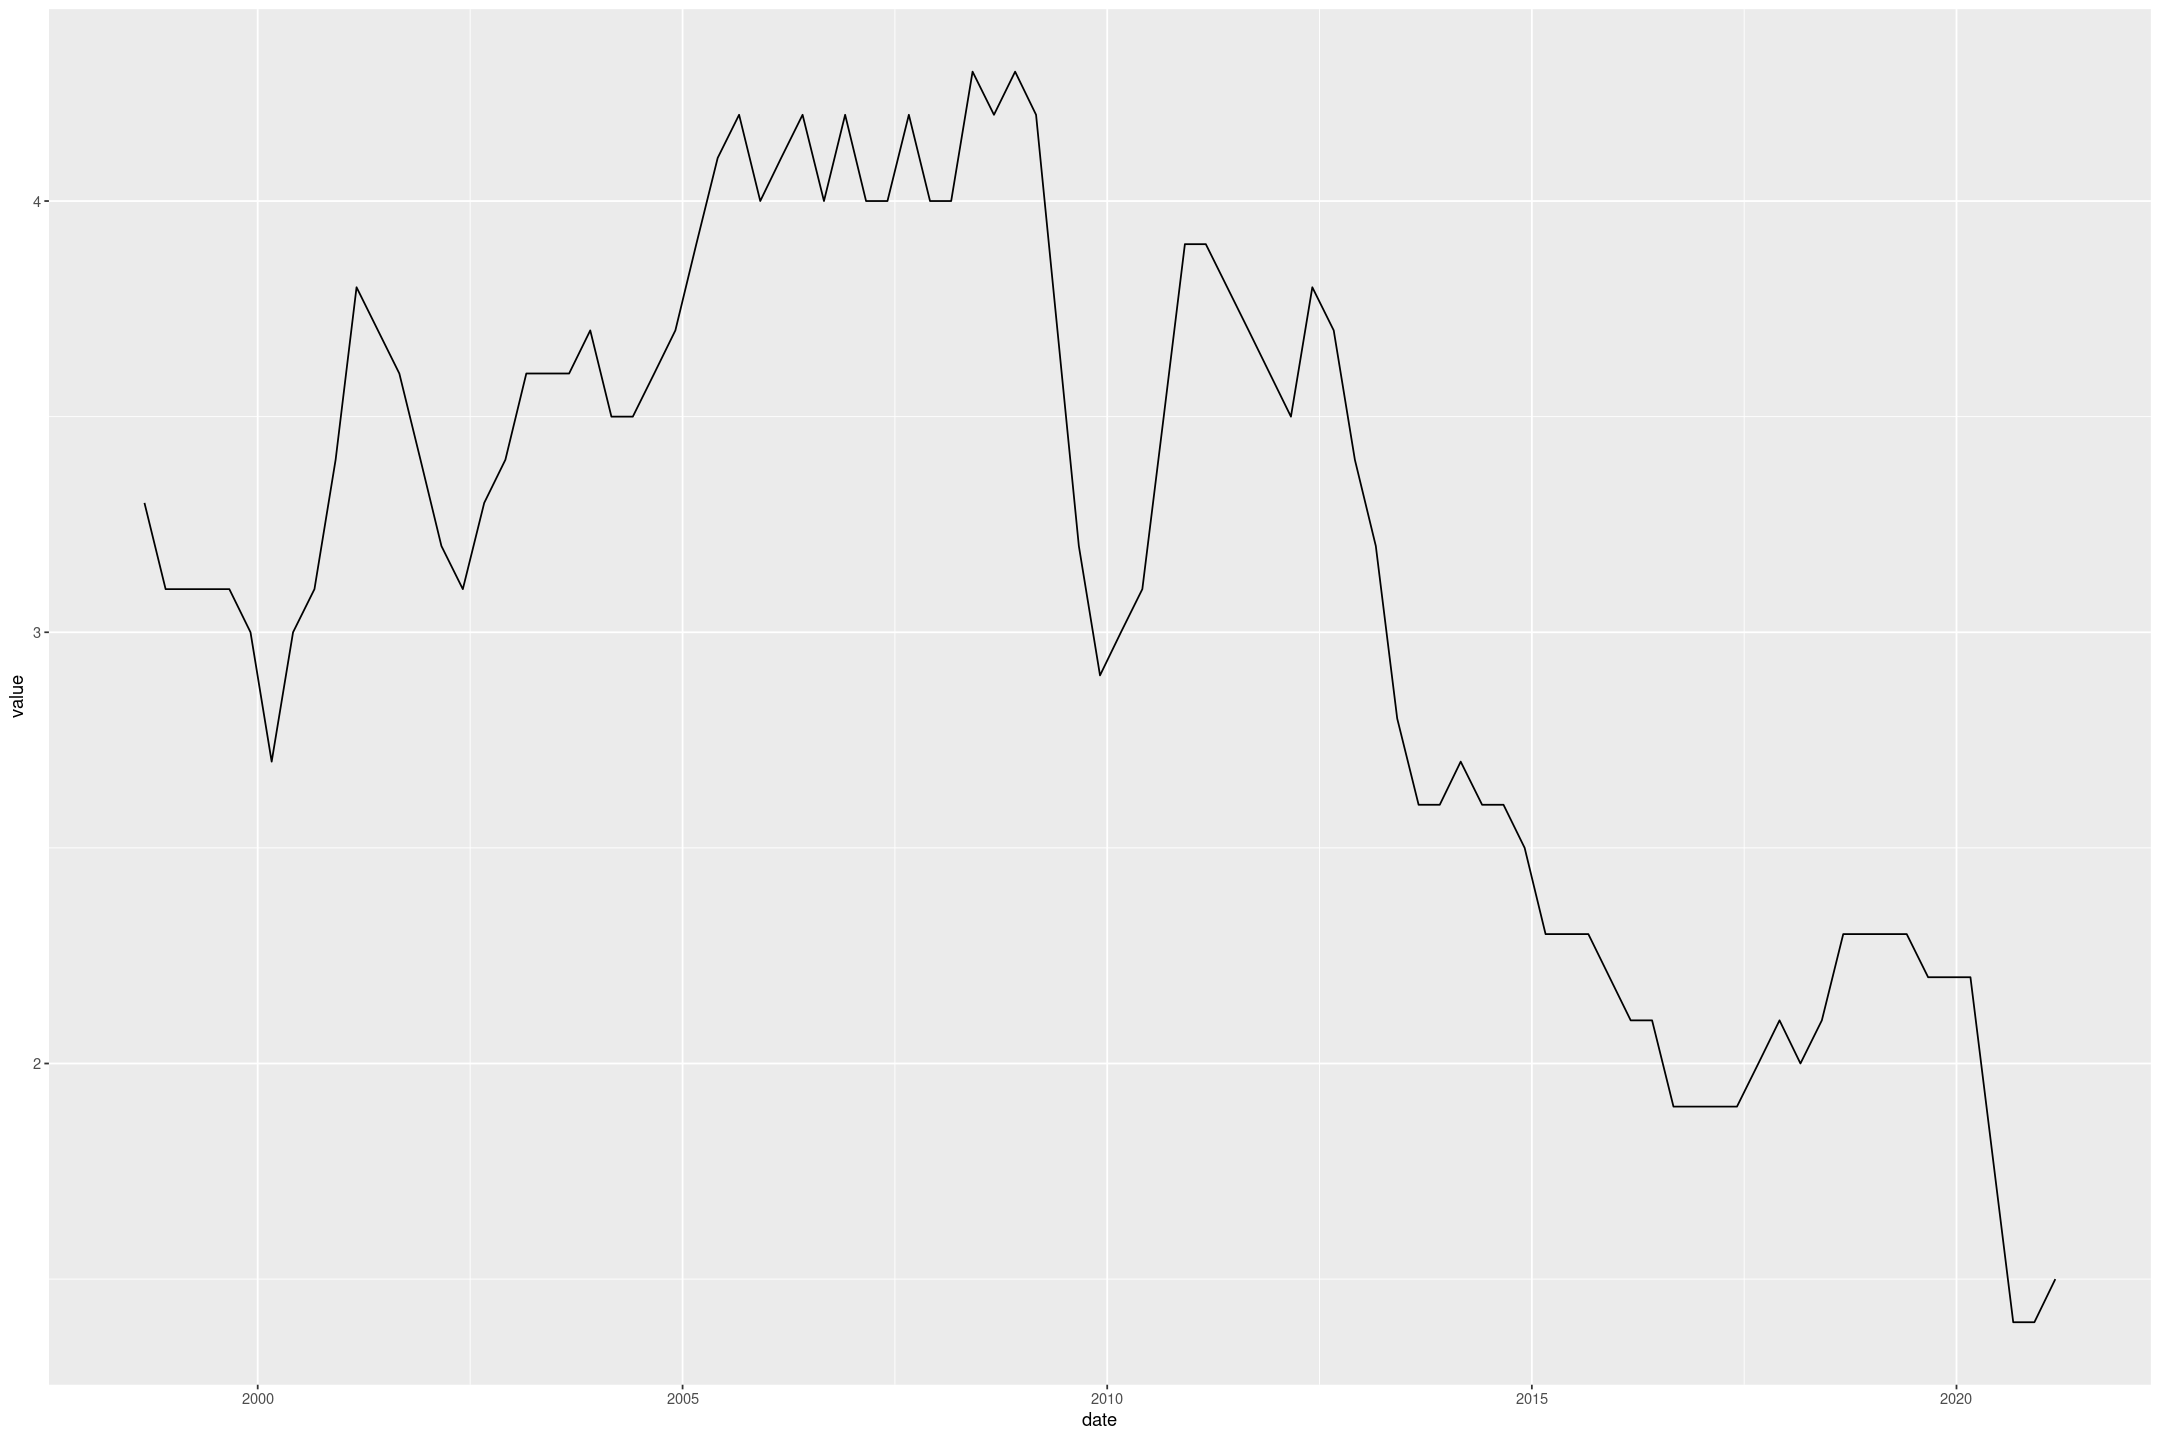

In [77]:
wage_price_index %>%
gf_line(value ~ date)

Fitting an autoregression

In [78]:
fit_lag <- stan_glm(value ~ lag(value), data=wage_price_index, refresh=0)
fit_lag

stan_glm
 family:       gaussian [identity]
 formula:      value ~ lag(value)
 observations: 90
 predictors:   2
------
            Median MAD_SD
(Intercept) 0.0    0.1   
lag(value)  1.0    0.0   

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.2    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [79]:
sims <- as.matrix(fit_lag)
n_sims <- nrow(sims)
n <- nrow(wage_price_index)

y_rep <- array(NA, c(n_sims, n))
for (s in 1:n_sims) {
    y_rep[s,1] <- y[1]
    for (t in 2:n) {
        y_rep[s,t] <- sims[s,"(Intercept)"] + sims[s, "lag(value)"] * y_rep[s,t-1] + rnorm(1,0, sims[s,"sigma"])
    }
}

In [80]:
wage_sims <- as.data.frame(y_rep %>% t())
wage_sims$date <- wage_price_index$date

In [81]:
library(tidyr)

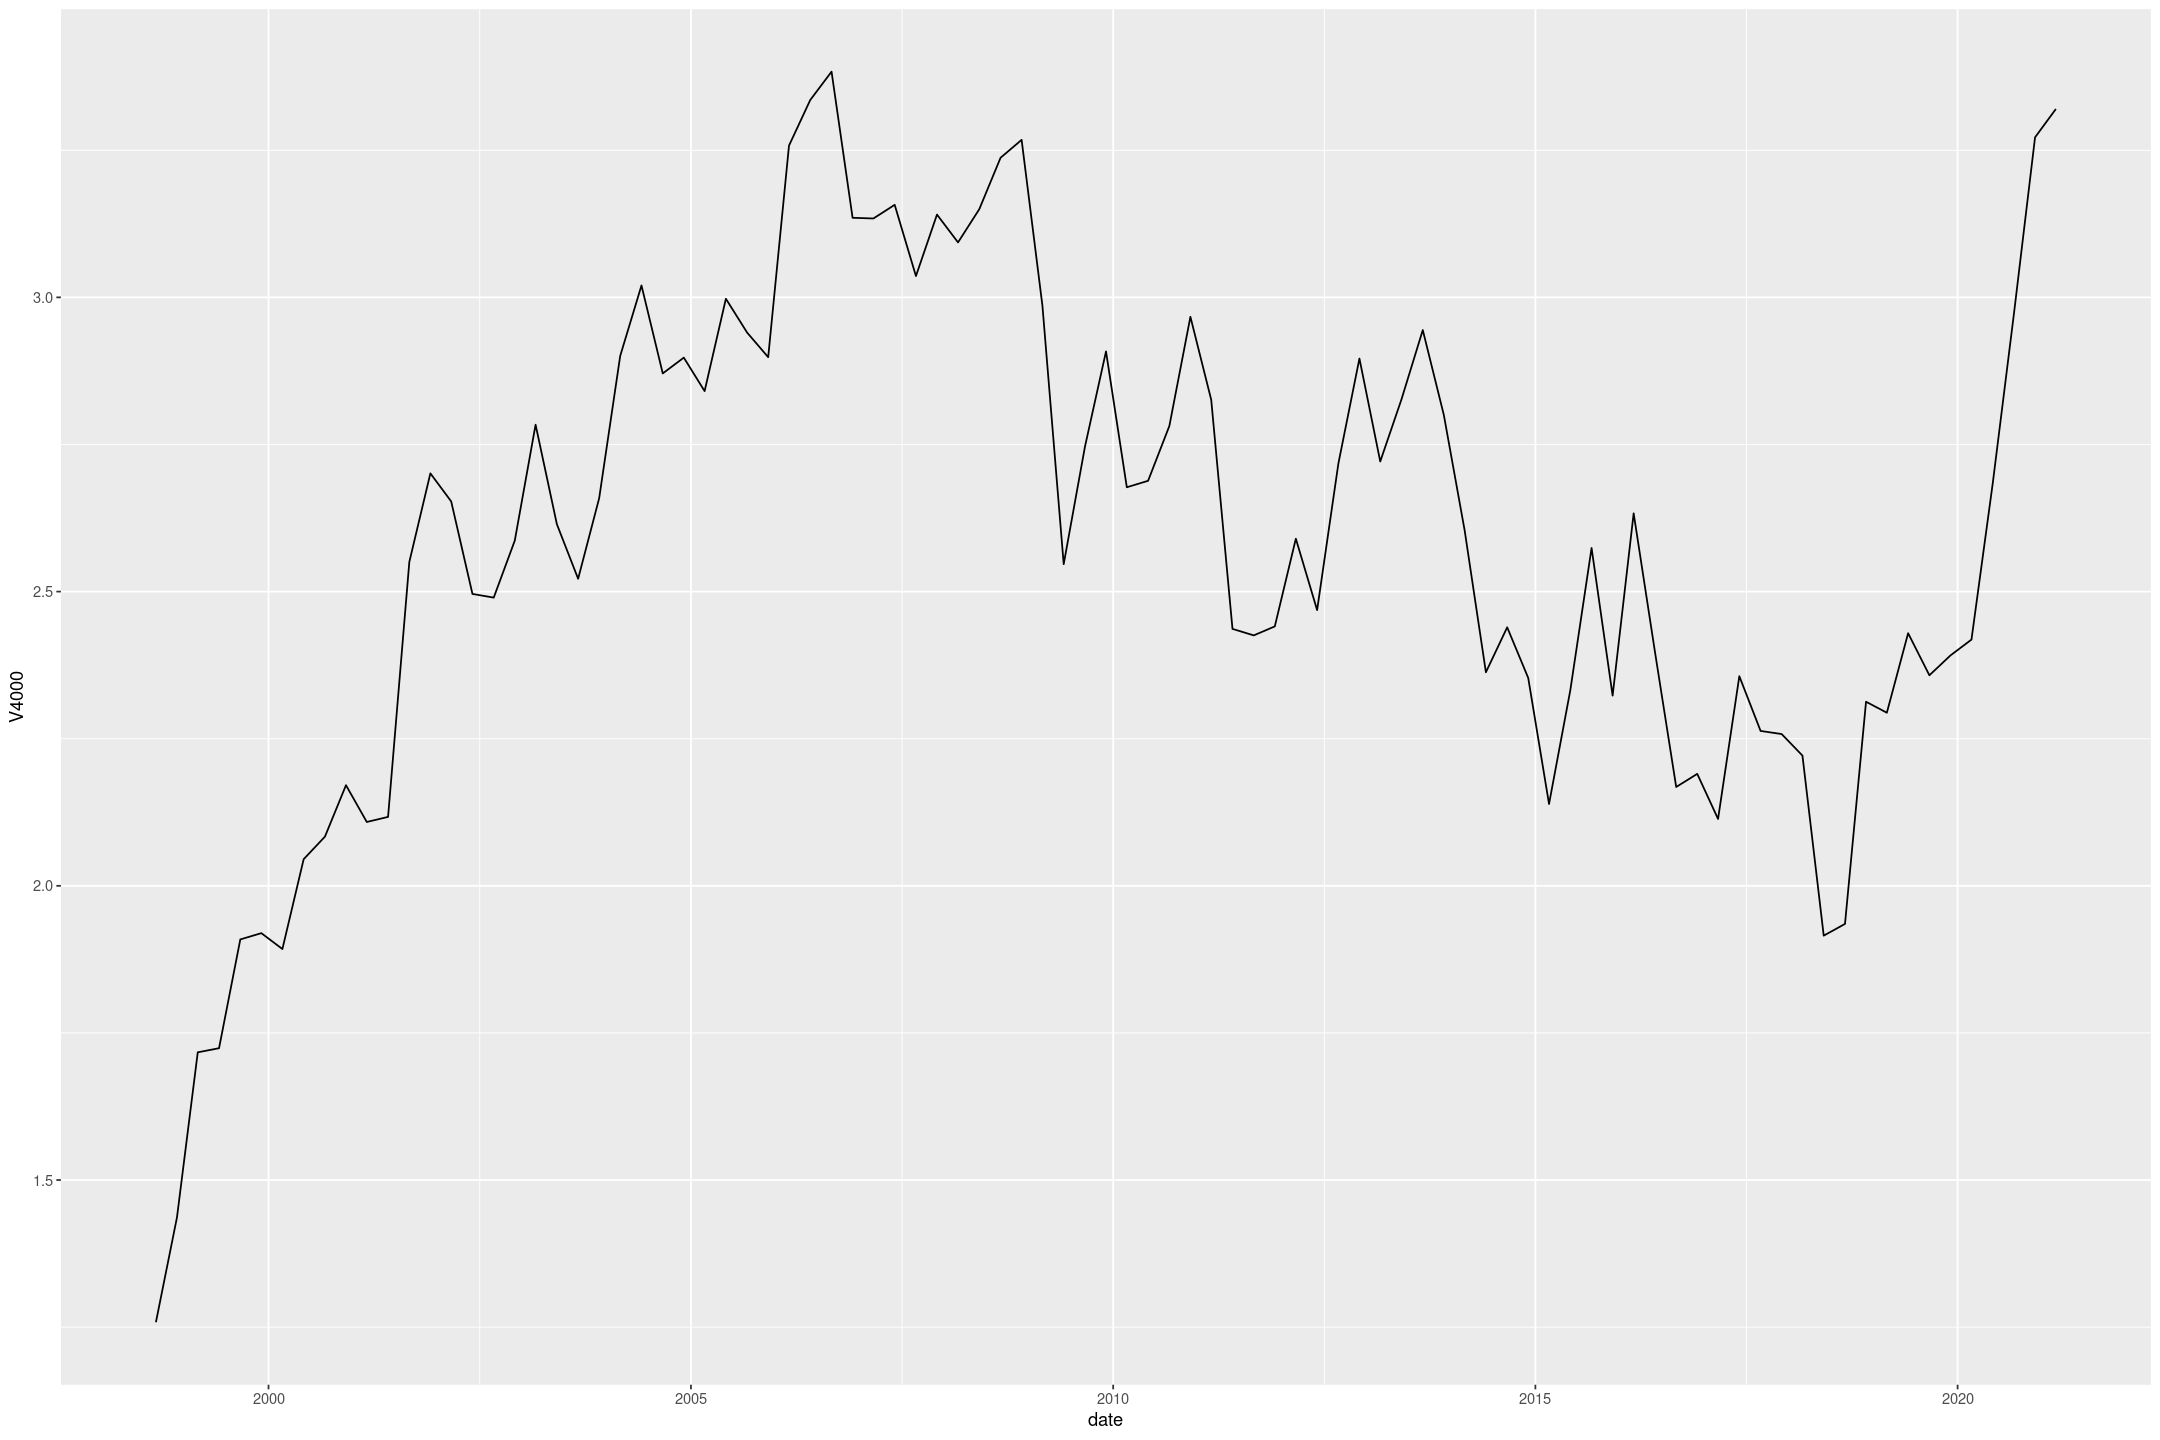

In [82]:
wage_sims %>% gf_line(V4000 ~ date)

The simulations actually look rather good

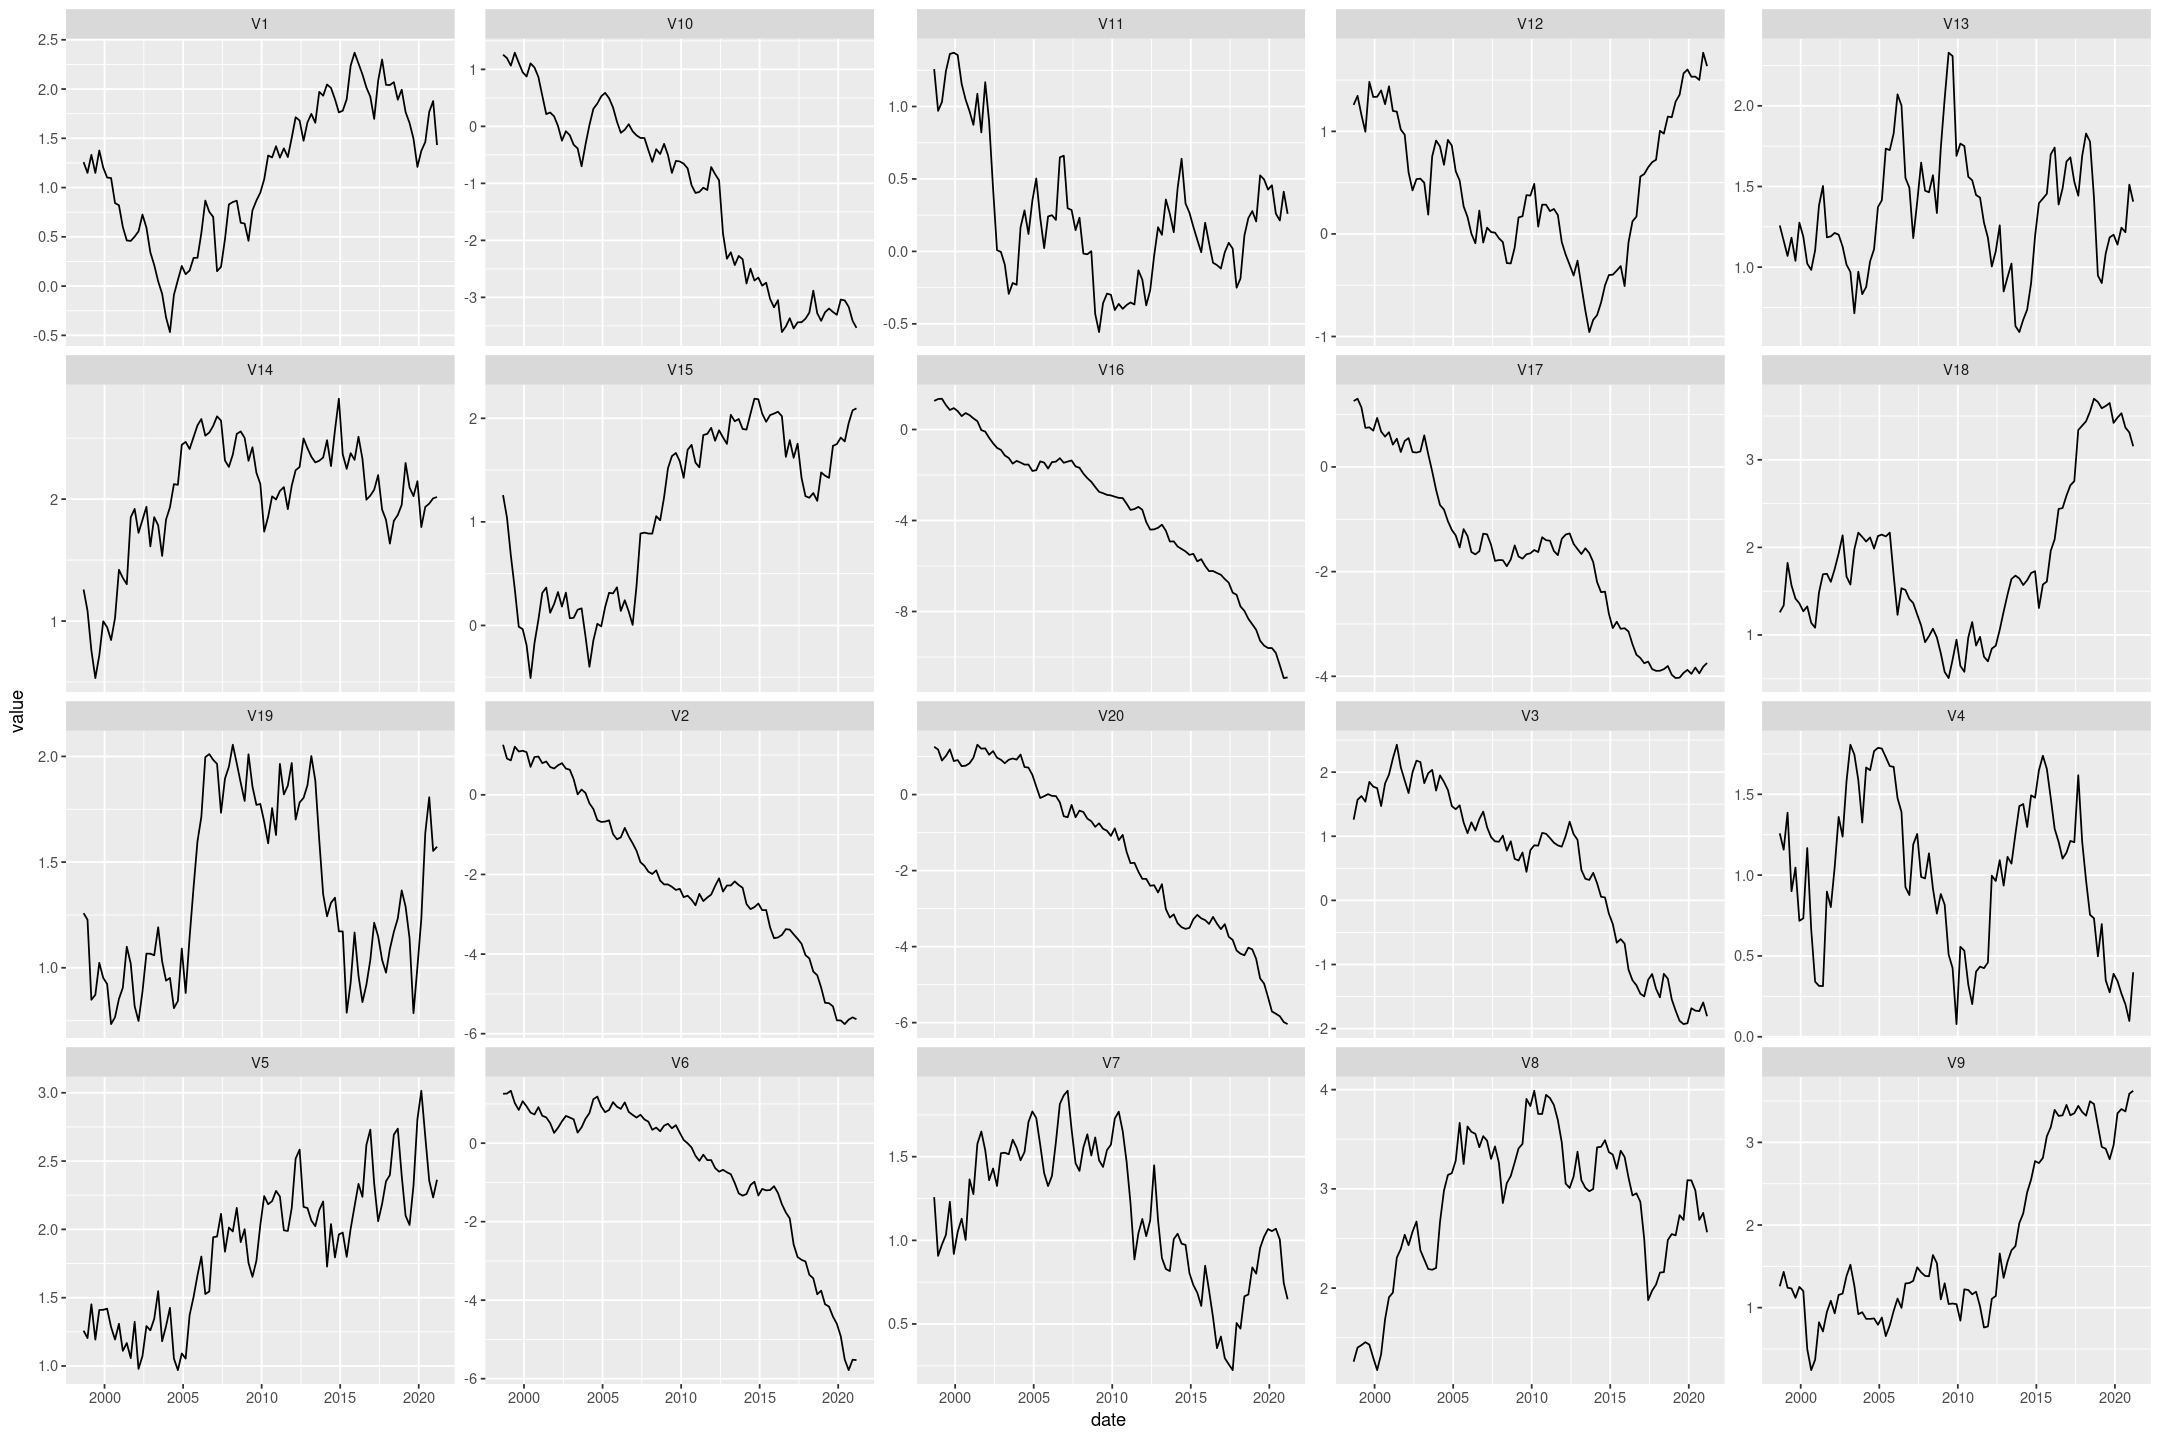

In [83]:
wage_sims %>%
select(date,num_range("V",1:20)) %>%
pivot_longer(num_range("V",1:20)) %>%
gf_line(value ~ date) %>%
gf_facet_wrap(~name, scales="free_y")

# Leave-one-out cross validation

Use LOO to compare different models fit to the beauty and teaching evaluations example from Exercise 10.6

In [84]:
filename <- "./data/Beauty/beauty.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Beauty/data/beauty.csv')
beauty <- read.csv(filename)

beauty

eval,beauty,female,age,minority,nonenglish,lower,course_id
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
4.3,0.2015666,1,36,1,0,0,3
4.5,-0.8260813,0,59,0,0,0,0
3.7,-0.6603327,0,51,0,0,0,4
4.3,-0.7663125,1,40,0,0,0,2
4.4,1.4214450,1,31,0,0,0,0
4.2,0.5002196,0,62,0,0,0,0
4.0,-0.2143501,1,33,0,0,0,4
3.4,-0.3465390,1,51,0,0,0,0
4.5,0.0613435,1,33,0,0,0,0


##  Comparing LOO
Discuss the LOO results for the different models and what this implies, or should imply, for model choice in this example.

In [85]:
beauty_model_simple <- stan_glm(eval ~ beauty, data=beauty, refresh=0)
beauty_model_simple_loo <- loo(beauty_model_simple)

In [86]:
beauty_model_gender <- stan_glm(eval ~ beauty + female, data=beauty, refresh=0)
beauty_model_gender_loo <- loo(beauty_model_gender)

In [87]:
beauty_model_gender_minority <- stan_glm(eval ~ beauty + female + minority, data=beauty, refresh=0)
beauty_model_gender_minority_loo <- loo(beauty_model_gender_minority)

In [88]:
beauty_model_nonenglish <- stan_glm(eval ~ beauty + nonenglish, data=beauty, refresh=0)
beauty_model_nonenglish_loo <- loo(beauty_model_nonenglish)

In [89]:
beauty_model_minority <- stan_glm(eval ~ beauty + minority, data=beauty, refresh=0)
beauty_model_minority_loo <- loo(beauty_model_minority)

In [90]:
beauty_model_gender_minority_nonenglish <- stan_glm(eval ~ beauty + female + minority + nonenglish, data=beauty, refresh=0)
beauty_model_gender_minority_nonenglish_loo <- loo(beauty_model_gender_minority_nonenglish)

In [91]:
beauty_model_all <- stan_glm(eval ~ beauty + female + minority + nonenglish + lower, data=beauty, refresh=0)
beauty_model_all_loo <- loo(beauty_model_all)

In [92]:
beauty_model_all_interactions <- stan_glm(eval ~ beauty + female + minority + nonenglish + lower + female:beauty + minority:beauty + minority:female, data=beauty, refresh=0)
beauty_model_all_interactions_loo <- loo(beauty_model_all_interactions)

In this case the model with the most predictors and the interactions has the lowest log score, and so the model is the best of the consideration set.

There are other interesting insights: adding `nonenglish` to the base model gives a much larger improvement than adding `minority` (but it still gives some improvmenent).

In [93]:
loo_compare(beauty_model_simple_loo,
            beauty_model_gender_loo,
            beauty_model_minority_loo,
            beauty_model_gender_minority_loo,
            beauty_model_nonenglish_loo,
            beauty_model_gender_minority_nonenglish_loo,
            beauty_model_all_loo,
            beauty_model_all_interactions_loo)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
beauty_model_all_interactions,0.000000,0.000000,-364.1436,15.21298,9.771116,0.8384221,728.2872,30.42595
beauty_model_all,-3.836584,3.842044,-367.9802,15.16327,7.055109,0.5698226,735.9604,30.32654
beauty_model_gender_minority_nonenglish,-4.581466,4.260585,-368.7251,15.26990,6.042871,0.5302558,737.4502,30.53980
beauty_model_gender,-7.707063,4.775044,-371.8507,14.86411,3.927230,0.3678129,743.7014,29.72821
beauty_model_gender_minority,-7.878072,4.901671,-372.0217,15.05827,5.189507,0.4538637,744.0434,30.11654
beauty_model_nonenglish,-10.068887,5.547219,-374.2125,15.02856,3.734903,0.3786753,748.4250,30.05713
beauty_model_minority,-13.615766,6.063150,-377.7594,14.97095,4.140687,0.3829056,755.5188,29.94189
beauty_model_simple,-14.274164,5.864484,-378.4178,14.62394,3.028098,0.3064028,756.8356,29.24788


## Pointwise errors as outliers
Compare predictive errors pointwise.
Are there some data points that have high predictive errors for all the fitted models?

Yes! This family of models doesn't change much across predictions.

In [94]:
beauty %>%
add_residuals(beauty_model_simple, "resid_simple") %>%
add_residuals(beauty_model_gender, "resid_gender") %>%
add_residuals(beauty_model_gender, "resid_all") %>%
add_residuals(beauty_model_gender, "resid_interactions") %>%
arrange(desc(abs(resid_interactions)))

eval,beauty,female,age,minority,nonenglish,lower,course_id,resid_simple,resid_gender,resid_all,resid_interactions
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2.1,-0.8260813,0,59,0,0,0,0,-1.8005982,-1.8725458,-1.8725458,-1.8725458
2.2,-1.5112680,0,60,0,0,0,0,-1.6096265,-1.6713228,-1.6713228,-1.6713228
2.3,0.3198185,1,41,0,0,0,15,-1.7527385,-1.6433666,-1.6433666,-1.6433666
2.7,0.1432643,0,35,1,1,0,4,-1.3292975,-1.4157476,-1.4157476,-1.4157476
2.5,-0.3465390,1,51,0,0,1,0,-1.4642667,-1.3449253,-1.3449253,-1.3449253
3.0,1.2610460,0,33,0,0,0,22,-1.1777046,-1.2808781,-1.2808781,-1.2808781
2.6,-1.5112680,0,60,0,0,0,0,-1.2096265,-1.2713228,-1.2713228,-1.2713228
3.0,1.0675310,0,34,0,0,1,0,-1.1520118,-1.2522900,-1.2522900,-1.2522900
3.1,1.0675310,0,34,0,0,0,0,-1.0520118,-1.1522900,-1.1522900,-1.1522900


# K-fold cross validation

Repeat part (a) of the previous example, but using 5-fold cross validation

## Sampling
Randomly partition the data into five parts using the `sample` function in R

In [95]:
split <- sample(1:5, nrow(beauty), replace=TRUE)

## Fitting the folds
For each part, re-fitting the model excluding that part, then use each fitted model to predict the outcomes for the left-out part, and compute the sum of squared errors for the prediction.

In [96]:
beauty$split <- split

In [97]:
library(purrr)


Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard




In [98]:
formula <- eval ~ beauty + female + minority + nonenglish + 
                  lower + female:beauty + 
                  minority:beauty + minority:female

In [99]:
sum_squared_errors <- function(data, model, value="eval") {
    preds <- predict(model, newdata=data)
    resid <- data[[value]] - preds
    sum(resid^2)
}

In [100]:
cross_validate <- function(formula) {
    split_models <- map(1:5, ~stan_glm(formula, data=filter(beauty, split!=.), refresh=0))
    
    sses <- map(1:5, ~sum_squared_errors(filter(beauty, split==.), split_models[[.]]))

    as.double(sses)
}

In [101]:
cross_validate(formula)

[1] 27.99047 25.82732 22.11122 20.36639 33.59398

## Assessing cross-validated scores.

For each model, add up the sum of squared errors for the five steps in (b).
Compare the different models based on this fit.

Actually adding minority appears to increase the squared error!

We get similar results to LOO.

In [102]:
sum(cross_validate(eval ~ beauty + minority))

[1] 137.6229

In [103]:
sum(cross_validate(eval ~ beauty))

[1] 138.0819

In [104]:
sum(cross_validate(eval ~ beauty + nonenglish))

[1] 135.4217

In [105]:
sum(cross_validate(eval ~ beauty + female))

[1] 133.8218

In [106]:
sum(cross_validate(eval ~ beauty + female + minority + nonenglish + 
                  lower))

[1] 131.0418

In [107]:
sum(cross_validate(eval ~ beauty + female + minority + nonenglish + 
                  lower + female:beauty))

[1] 131.4227

In [108]:
sum(cross_validate(eval ~ beauty + female + minority + nonenglish + 
                  lower + female:beauty + 
                  minority:beauty + minority:female))

[1] 129.8567